In [1]:
!python -V

Python 3.10.8


In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['VECLIB_MAXIMUM_THREADS'] = '8'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ["MKL_NUM_THREADS"] = '6' # export MKL_NUM_THREADS=6
os.environ["NUMEXPR_NUM_THREADS"] = '6' # export NUMEXPR_NUM_THREADS=6

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy as sp
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os, psutil

from IPython.display import display, clear_output

from joblib import Parallel, delayed
N_JOBS=2
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 
warnings.formatwarning = lambda s, *args: "Warning: " + str(s)+'\n'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [4]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/in

In [5]:
from numba import njit, jit, prange, objmode, vectorize
import numba
numba.set_num_threads(8)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
from matplotlib.ticker import MaxNLocator

In [7]:
print(np.finfo(np.clongdouble))
print(np.finfo(np.cdouble))
print(np.finfo(np.csingle))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-30

In [8]:
dtype = np.cdouble
dtyper = np.float64

In [9]:
use_cache = False
output_prefix = "output/entangled_halo_proj/("+\
                datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + \
                str("T" if use_cache else "F") + \
                ") "
output_ext = ".pgz.pkl"
print(output_prefix)

output/entangled_halo_proj/(20230209-093720-F) 


In [10]:
import platform
if not use_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation Parameters

In [11]:
nx = 120+1
nz = 90+1
xmax = 50 # Micrometers
# xmax = 20 * 0.001 # Millimeters
zmax = (nz/nx)*xmax
dt = 5e-4 # Milliseconds
# dt = 1e-5 # Seconds
# dt = 0.1 # Microseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
# hb = 0.0635077993 # ("AtomicMassUnit" ("Micrometers")^2)/("Microseconds")
# hb = 0.0000635077993 #  ("AtomicMassUnit" ("Millimeters")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
print("(dpx,dpz) = ", (dpx, dpz))

print(round((nx*nz)**2/1000/1000,3),"million grid points (ideally want around 1M magnitude)")
print(round((nx*nz)**2*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

assert ((nx*nz)**2 < 1000**4), "This is in the terra range! too big!"

zmax = 37.60330578512397
(dx,dz) = (0.8333333333333334, 0.8356290174471994)
rotate phase = 0.005699999521978021j
pxmax = 243.40907826929285
pzmax = 243.40907826929285
(dpx,dpz) =  (3.9903127585129976, 5.305800481099699)
121.242 million grid points (ideally want around 1M magnitude)
2.02 minutes/grid_op (for 1μs/element_op)


In [12]:
wavelength = 1.083 #Micrometers
# k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 0.03 * 2*pi / wavelength
k = pi / (4*dx)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v3 = hb*k/m3
v4 = hb*k/m4
print("v3 =",v3, "µm/ms")
print("v4 =",v4, "µm/ms")
print("sigma_x =", hb/10, " handwavy heisenberg momentum uncertainty ")
print(2*pi / (2*k), "x-period of cosin bragg lattice")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
assert (dpx < hb/2 and dpz < hb/2), "momentum resolution step too big"
# assert (2*pi / (2*k) > 10*dx), "not even ten x-steps in cosin wave!"

k  = 0.9424777960769379 1/µm
p  = 119.70938275538992 u*µm/ms
v3 = 19.951563792564986 µm/ms
v4 = 14.96367284442374 µm/ms
sigma_x = 6.35078  handwavy heisenberg momentum uncertainty 
3.3333333333333335 x-period of cosin bragg lattice


AssertionError: momentum resolution too small

In [13]:
# dopd = 60.1025 # 1/ms Doppler detuning (?)
dopd = v3**2 * m3 / hb
print(dopd)
warnings.warn("why? TODO: check")

18.80390587150508


In [14]:
pi / (8*dx)

0.47123889803846897

In [15]:
a4 = 0.007512 # scattering length 
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
print("tBraggPi     =", round(tBraggPi,3),"µs")
print("tBraggCenter =", round(tBraggCenter,3),"µs")
print("tBraggEnd    =", round(tBraggEnd,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
    
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

V0 = 6350.780000000001
tBraggPi     = 0.003 µs
tBraggCenter = 0.016 µs
tBraggEnd    = 0.031 µs
7.873048664888407e-06j term infront of Bragg potential
6.341670455467974j max(V)


In [16]:
xlin = np.linspace(-xmax,+xmax, nx, dtype=dtyper)
zlin = np.linspace(-zmax,+zmax, nz, dtype=dtyper)
psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
psi=np.random.rand(nx,nz, nx,nz) + 1j*np.random.rand(nx,nz, nx,nz)
print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

xgrid = np.tensordot(xlin, np.ones(nz, dtype=dtyper), axes=0)
cosXGrid = np.cos(2*k*xgrid)
x3grid = np.tensordot(xgrid, np.ones((nx,nz),dtype=dtyper), axes=0)
x4grid = np.tensordot(np.ones((nx,nz),dtype=dtyper), xgrid, axes=0)
# cosX3Grid = np.cos(2*k*x3grid)
# cosX4Grid = np.cos(2*k*x4grid)

process = psutil.Process(os.getpid())
def current_py_memory(): return process.memory_info().rss;
def current_py_memory_print(): print(str(round(current_py_memory()/1000**2,3)) + "MB of system memory used")
momory_bytes = current_py_memory()
if (momory_bytes/1000**3 > 1): 
    warnings.warn(str(round(momory_bytes/1000**3,3))+" GB of system memory used already! careful!")
else:
    print(momory_bytes/1000**2 , "MB of system memory used")
del momory_bytes

1939.874 MB per psi 2d*2d array


In [17]:
x3grid.dtype

dtype('float64')

In [56]:
pxlin = np.linspace(-pxmax,+pxmax,nx,dtype=dtyper)
pzlin = np.linspace(-pzmax,+pzmax,nz,dtype=dtyper)

expP34Grid = np.zeros((nx,nz,nx,nz),dtype=dtype)
for (iz3, pz3) in enumerate(pzlin):
    for (ix4, px4) in enumerate(pxlin):
        for (iz4, pz4) in enumerate(pzlin):
            expP34Grid[:,iz3,ix4,iz4] = np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin**2 + pz3**2) \
                                               -(1j/hb) * (0.5/m4) * (dt) * (  px4**2 + pz4**2))


# expP3Grid = np.zeros((nx,nz),dtype=dtype)
# for indx in range(nx):
#     expP3Grid[indx, :] = np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
# expP4Grid = np.zeros((nx,nz),dtype=dtype)
# for indx in range(nx):
#     expP4Grid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
    
# # expPGrid = np.zeros((nx,nz,nx,nz),dtype=dtype)
# # for iz3 in range(nz):
# #     for ix4 in range(nx):
# #         for iz4 in range(nz):
# #             expPGrid[:, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 

# expP3Grid = np.tensordot(expP3Grid, np.ones((nx,nz)), axes=0)
# expP4Grid = np.tensordot(np.ones((nx,nz)), expP4Grid, axes=0)

In [19]:
current_py_memory_print()

6068.437MB of system memory used


### Contact Potential?

In [20]:
(dx,dz)

(0.8333333333333334, 0.8356290174471994)

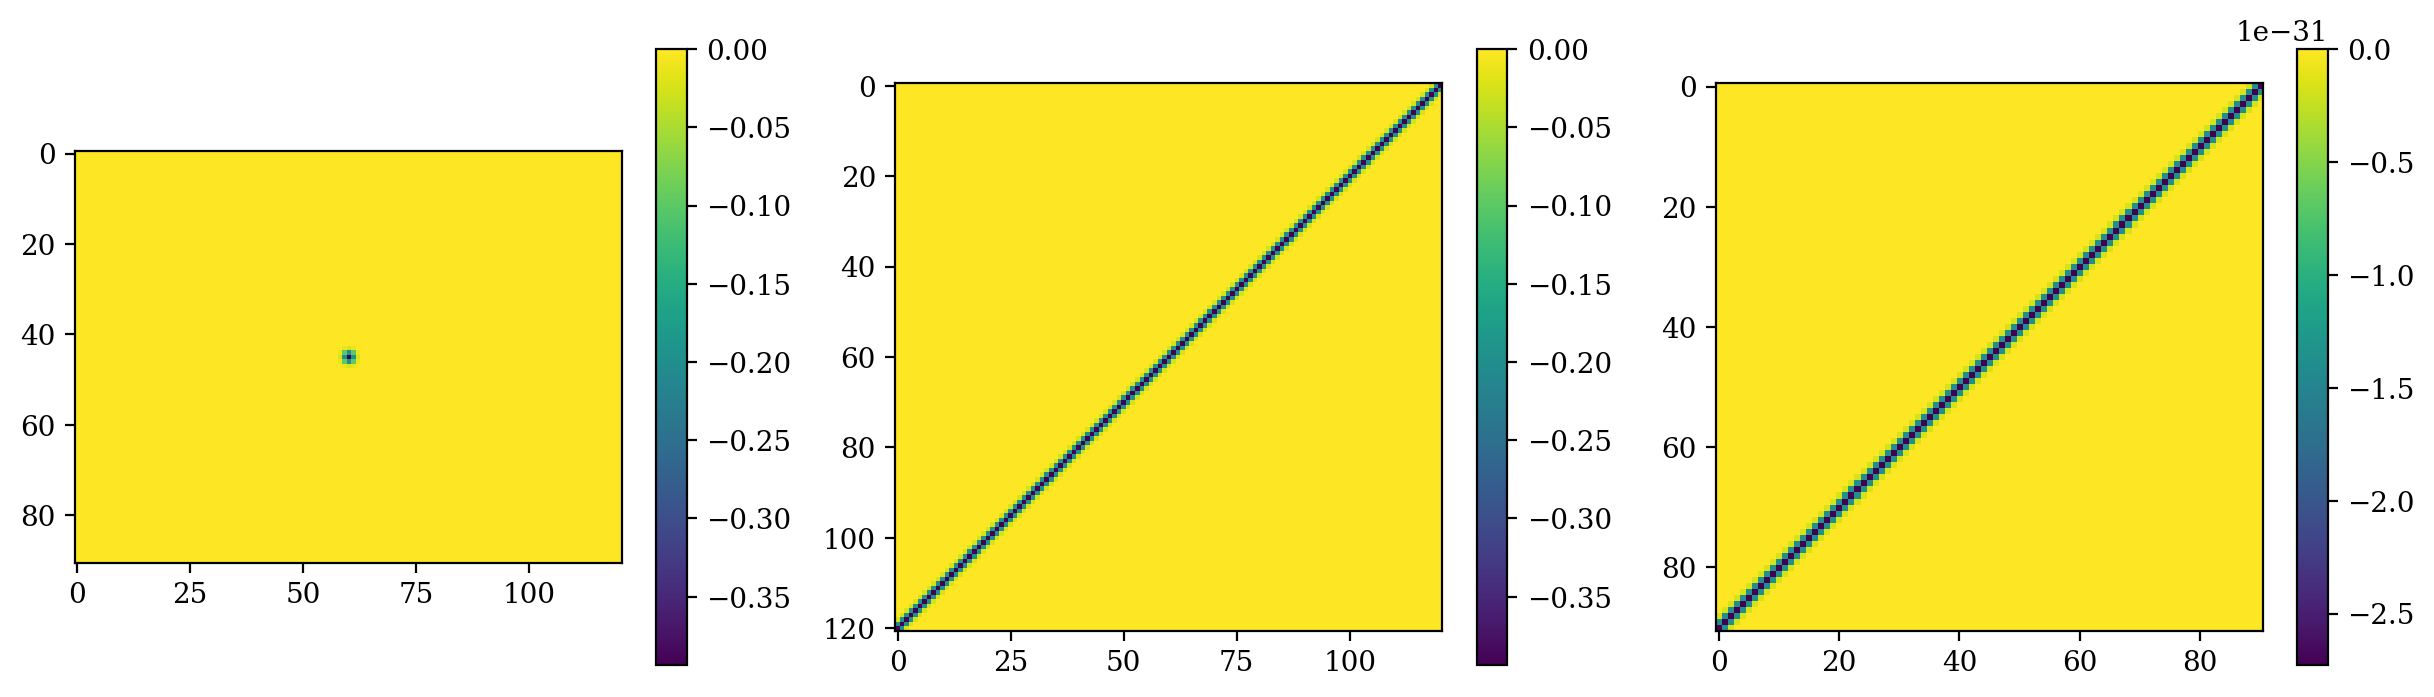

In [21]:
# a34 = 0.029 #µm
a34 = 0.5 #µm
strength34 = 1e5 # I don't know

expContact = np.zeros((nx,nz, nx,nz),dtype=dtype)
for (iz3, z3) in enumerate(zlin):
    for (ix4, x4) in enumerate(xlin):
        for (iz4, z4) in enumerate(zlin):
            expContact[:,iz3,ix4,iz4] = np.exp(-(1j/hb) * # this one is unitary time evolution operator
                                        strength34 *
                                        np.exp(-((xlin-x4)**2 +(z3-z4)**2)/(4*a34**2))
                                               # inside the guassian contact potential
                                               *0.5*dt
                                        )
            
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(np.angle(expContact[:,:,60,45]).T)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.flipud(np.angle(expContact[:,45,:,45]).T))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.flipud(np.angle(expContact[50,:,60,:]).T))
plt.colorbar()

In [22]:
expContact.dtype

dtype('complex128')

In [23]:
((nx-1)/2,(nz-1)/2)

(60.0, 45.0)

In [24]:
current_py_memory_print()

8094.188MB of system memory used


### Checking parameters

78


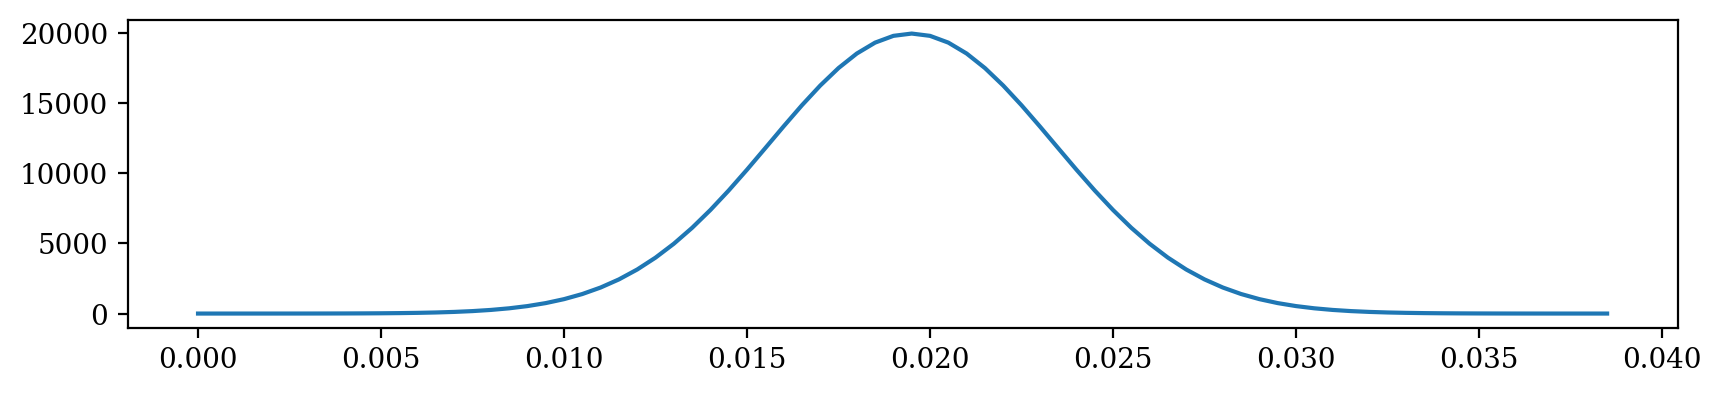

In [25]:
tauPi  = 39*0.0001
tauMid = tauPi*5
tauEnd = tauPi*10

# smooth bragg in time
tbtest = np.arange(0, tauEnd,dt)
# plt.plot(tbtest, V(tbtest))
print(tbtest.size)
plt.figure(figsize=(10,2))
plt.plot(tbtest, VBF(tbtest,tauMid,tauPi))

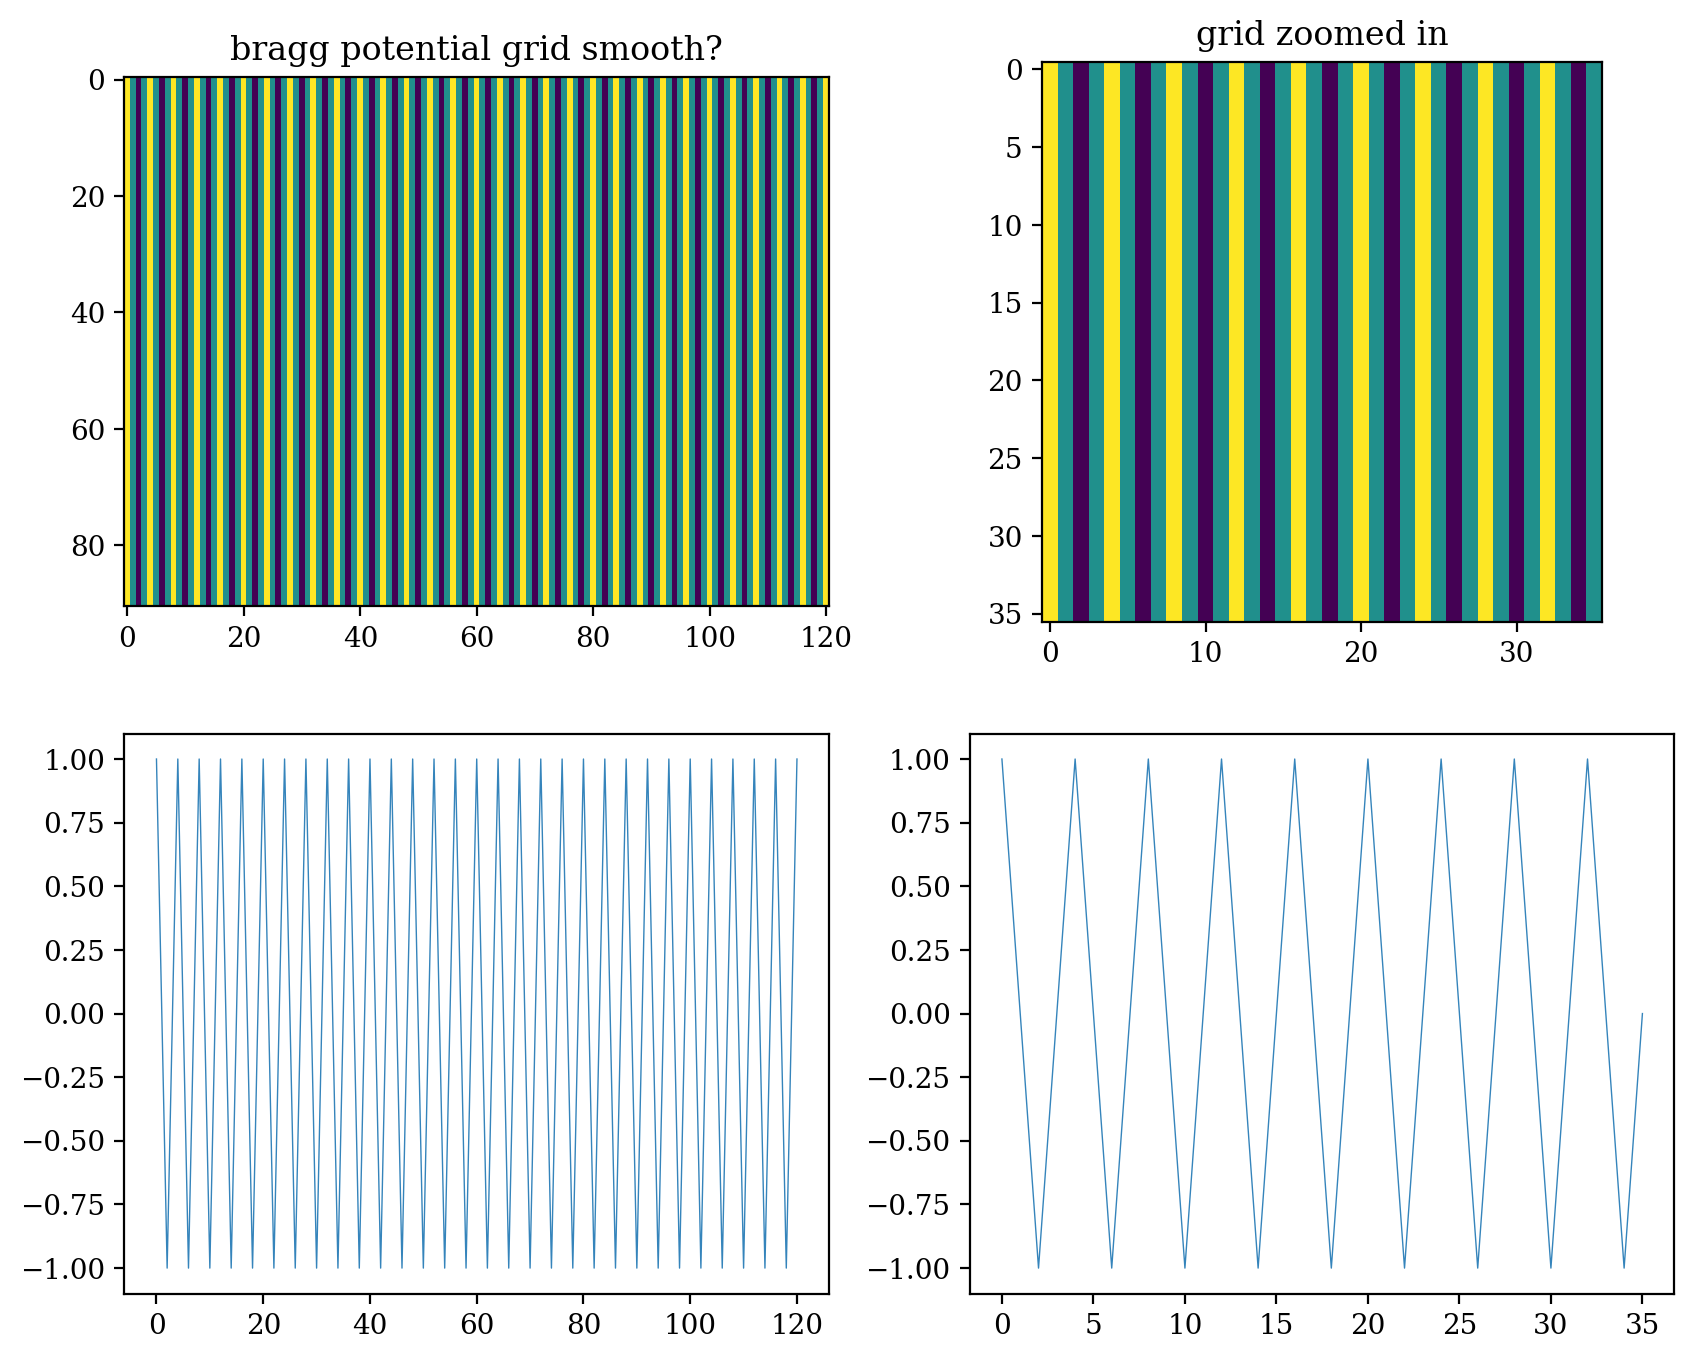

In [26]:
# vtest = np.cos(2*k*xlin)
ncrop = int(0.3*nx)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cosXGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosXGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosXGrid[:,0],alpha=0.9,linewidth=0.5)

plt.subplot(2,2,4)
plt.plot(cosXGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()
del ncrop

## initial wave function

In [27]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [28]:
np.trapz(
    np.trapz(
        np.trapz(
            np.trapz(
                np.abs(psi)**2,
            dx=dz,axis=3),
        dx=dx,axis=2),
    dx=dz,axis=1),
dx=dx,axis=0)

37705446.310999826

In [29]:
np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2))))*(dx*dx*dz*dz)

37705446.31099983

In [30]:
dx

0.8333333333333334

In [31]:
sg = 8;
# @njit(parallel=True, fastmath=True)
# @jit('c16[::1](f8[::1],f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,)')
@njit(cache=True)
def psi0gaussianNN(x3, z3, x4, z4, sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0.0, pz3=0.0, px4=0.0, pz4=0.0):
    return    np.exp(-0.5*x3**2/sx3**2)\
            * np.exp(-0.5*z3**2/sz3**2)\
            * np.exp(-0.5*x4**2/sx4**2)\
            * np.exp(-0.5*z4**2/sz4**2)\
            * np.exp(+(1j/hb)*(px3*x3 + pz3*z3 + px4*x4 + pz4*z4))

# @njit(parallel=True, fastmath=True)
# @jit('f8(c16[::4],f8,f8)', forceobj=True)
# @jit(forceobj=True)
@njit(cache=True)
def check_norm(psi,dx=dx,dz=dz) -> dtyper:
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2))))*(dx*dx*dz*dz)
#     return  np.trapz(
#                 np.trapz(
#                     np.trapz(
#                         np.trapz(np.abs(psi)**2,
#                             dx=dz,axis=numba.literally(3)),
#                         dx=dx,axis=numba.literally(2)),
#                     dx=dz,axis=numba.literally(1))
#                 ,dx=dx,axis=numba.literally(0))
#     with objmode(psi='intp[:]',dx='intp[:]',dz='intp[:]'):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     out = -1
#     with objmode(out='intp[:]'):
#         out = np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     return out
        
# @njit(parallel=True, fastmath=True)
# @njit(parallel=True)

# @njit(parallel=True)
# def psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin):
#     psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
#     return psi

@njit(parallel=True, cache=True)
def psi0gaussian(sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0, xlin=xlin,zlin=zlin) -> np.ndarray:
#     psi =  psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin)
    psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

# @njit(parallel=True)
@jit(forceobj=True)
# @njit
def only3(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dz,axis=3),dx=dx,axis=2)
#     return np.trapz(np.trapz(np.abs(psi)**2,axis=3),axis=2)*(dx*dz)

# @njit(parallel=True)
@jit(forceobj=True)
def only4(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dx,axis=0),dx=dz,axis=0)



In [32]:
psi0gaussian.signatures

[]

In [33]:
%timeit psi0gaussian()

2.07 s ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
psi = psi0gaussian()

In [94]:
psi.dtype

dtype('complex128')

In [95]:
# psi = psi.astype(dtype)

In [34]:
# @njit(parallel=True)
# def psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
#     return psi


@njit(parallel=True, cache=True)
# @jit(forceobj=True)
def psi0_just_opposite(dr=20,s3=sg,s4=sg,pt=0,a=0,xlin=xlin,zlin=zlin):
    dr3 = 0.5 * dr;
    dr4 = 0.5 * (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
    ph = 0.5 * pt;
    px = +ph * cos(a)
    pz = +ph * sin(a)
    
#     print((+px,+pz,-px,-pz))
#     psi = psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin)
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)
    

In [97]:
su=5
psi = psi0_just_opposite(dr=0,s3=su,s4=su,pt=-3*hb*k,a=0*pi)

In [98]:
psi.dtype

dtype('complex128')

In [35]:
@njit(cache=True)
def psi0PairNN(x3,z3,x4,z4,dr=20,s3=sg,s4=sg,pt=p,a=0):
    dr3 = 0.5 * dr;
    dr4 = 0.5 * (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
    ph = 0.5 * pt;
    px3 = +ph * cos(a)
    pz3 = +ph * sin(a)
    px4 = -ph * cos(a)
    pz4 = -ph * sin(a)
    return (psi0gaussianNN(x3-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px3,+pz3,+px4,+pz4) + 
            psi0gaussianNN(x3+dx3,z3+dz3, x4-dx4,z4-dz4, s3,s3, s4,s4,-px3,-pz3,-px4,-pz4)
           )

# @njit(parallel=True)
# def psi0Pair_loop_helper(dr,s3,s4,pt,a,xlin=xlin,zlin=zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     return psi

@njit(cache=True, parallel=True)
def psi0Pair(dr=20,s3=sg,s4=sg,pt=p,a=0):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
    normalisation = check_norm(psi)
    #print(normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)

In [100]:
_ = psi0Pair()

In [50]:
from numba_progress import ProgressBar

In [51]:
# @njit(nogil=True,parallel=True,cache=True) # psi0Pair already parallelised
@njit(nogil=True,parallel=True,cache=True)
def psi0ring_loop_helper(dr,s3,s4,pt,an, 
                         progress_proxy=None):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
    angles_list = np.linspace(0,pi,an+1)[:-1]
    for ia in prange(an):
        a = angles_list[ia]
        # print("working on a = "+str(round(a/pi,4))+" * pi      ",end='\r')
        psi += (1/an) * psi0Pair(dr=dr,s3=s3,s4=s4,pt=pt,a=a)
#         psi_un = psi0Pair_loop_helper(dr=dr,s3=s3,s4=s4,pt=pt,a=a)
        if progress_proxy != None:
            progress_proxy.update(1)
    return psi.astype(dtype)

# @jit(cache=True,forceobj=True)
def psi0ring_with_logging(dr=20,s3=3,s4=3,pt=p,an=4):   
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
#         for (ix4, x4) in enumerate(xlin):
#             print("working on "+str((iz3,ix4))+"      ",end='\r')
#             for (iz4, z4) in enumerate(zlin):
#                 for a in np.linspace(0,2*pi,360):
#                     psi[:,iz3,ix4,iz4] += psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     angles_divs = 4
    angles_list = np.linspace(0,pi,an+1)[:-1]
    
#     if logging:
    print("angles_list = "+ str(np.round(angles_list/pi,4)) + " * pi")
    with ProgressBar(total=an) as progress:
        psi = psi0ring_loop_helper(dr,s3,s4,pt,an,progress)
    normalisation = check_norm(psi)
#     print(" ")
#     print("normalisation =", normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)
#     else:
# #         for a in angles_list:
# #             psi += (1/an) * psi0Pair(dr=dr,s3=s3,s4=s4,pt=p,a=a)
#         psi = psi0ring_loop_helper(dr,s3,s4,pt,an,None)
#         normalisation = check_norm(psi)
#         return psi/sqrt(normalisation)
    
@njit(cache=True)
def psi0ring(dr=20,s3=3,s4=3,pt=p,an=4):   
    psi = psi0ring_loop_helper(dr,s3,s4,pt,an,None)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

In [103]:
_ = psi0ring_with_logging(dr=20,s3=3,s4=3,pt=p,an=12)
_ = psi0ring(dr=20,s3=3,s4=3,pt=p,an=12)

angles_list = [0.     0.0833 0.1667 0.25   0.3333 0.4167 0.5    0.5833 0.6667 0.75
 0.8333 0.9167] * pi


  0%|                                                                                                         …

#### Testings

check normalisation psi 1.0000000000000002
check normalisation phi 0.9999999999999998
swnf = (30.403640244856824+0j)


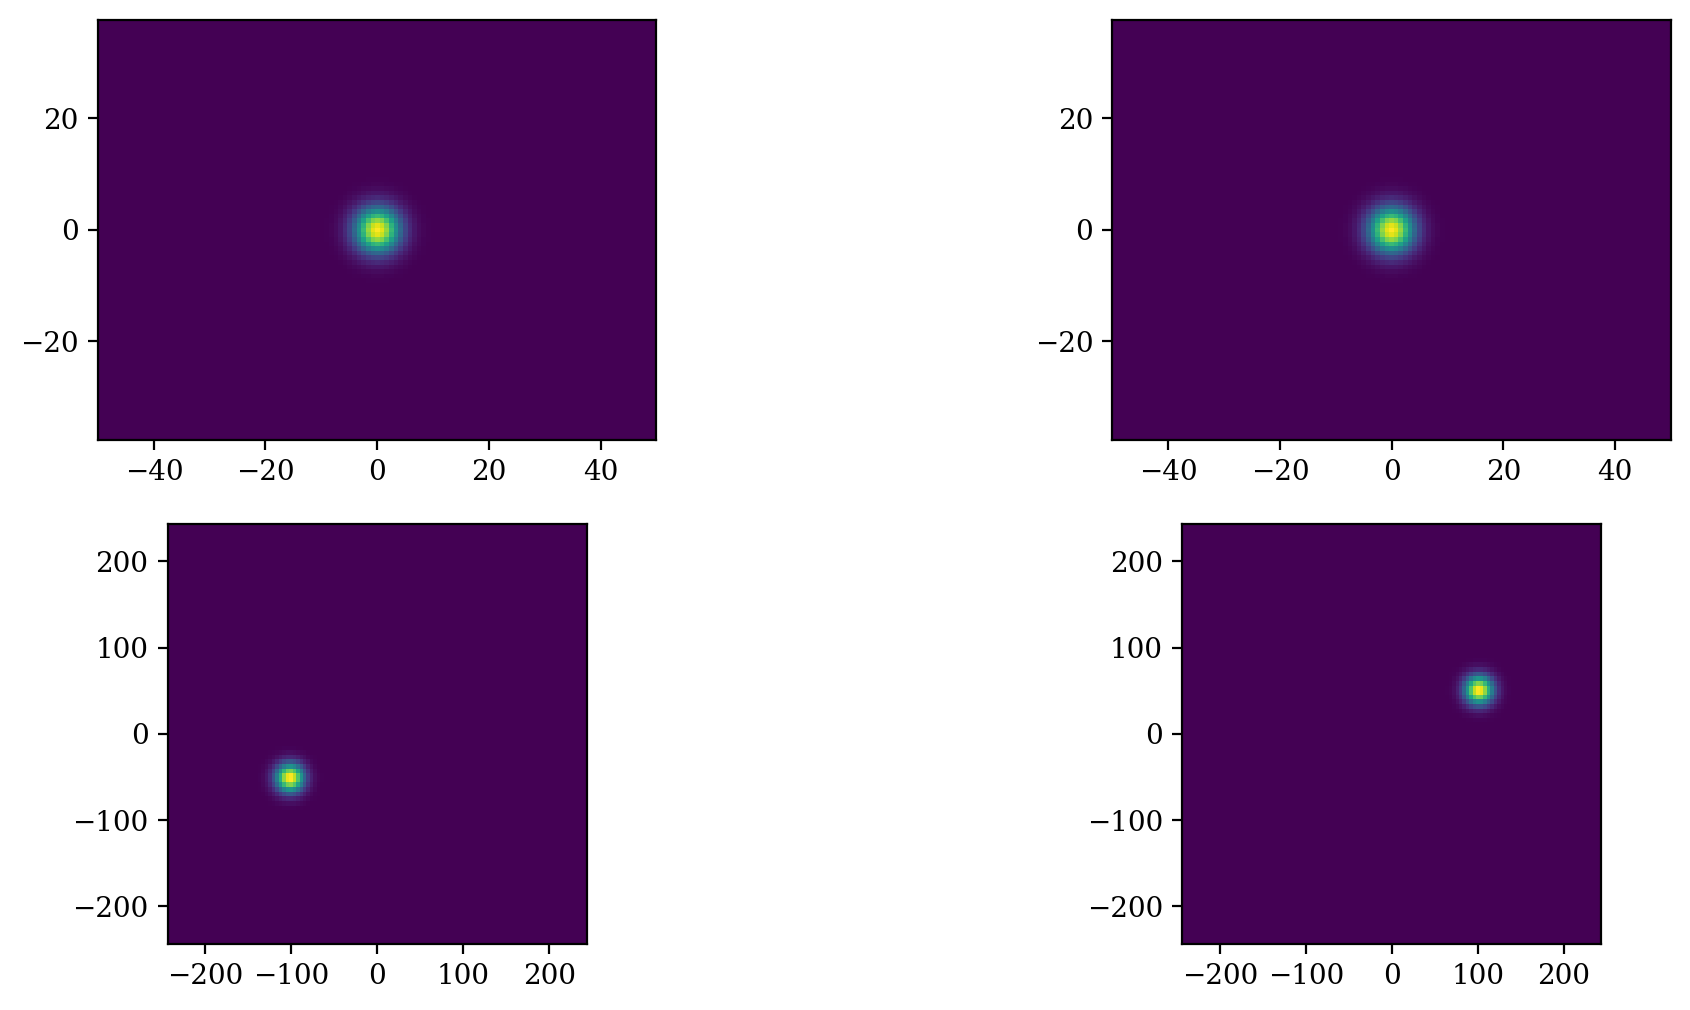

13448.954MB of system memory used


In [54]:
su = 4
psi = psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=-100, pz3=-50, px4=100, pz4=50)
t = 0

tempTest3 = only3(psi)
tempTest4 = only4(psi)
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
tempTest3phi = only3phi(phi)
tempTest4phi = only4phi(phi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(tempTest3.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(tempTest4.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow((tempTest3phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow((tempTest4phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
del tempTest3, tempTest4, tempTest3phi, tempTest4phi
current_py_memory_print()

In [420]:
tempTest3phi = only3phi(phi)

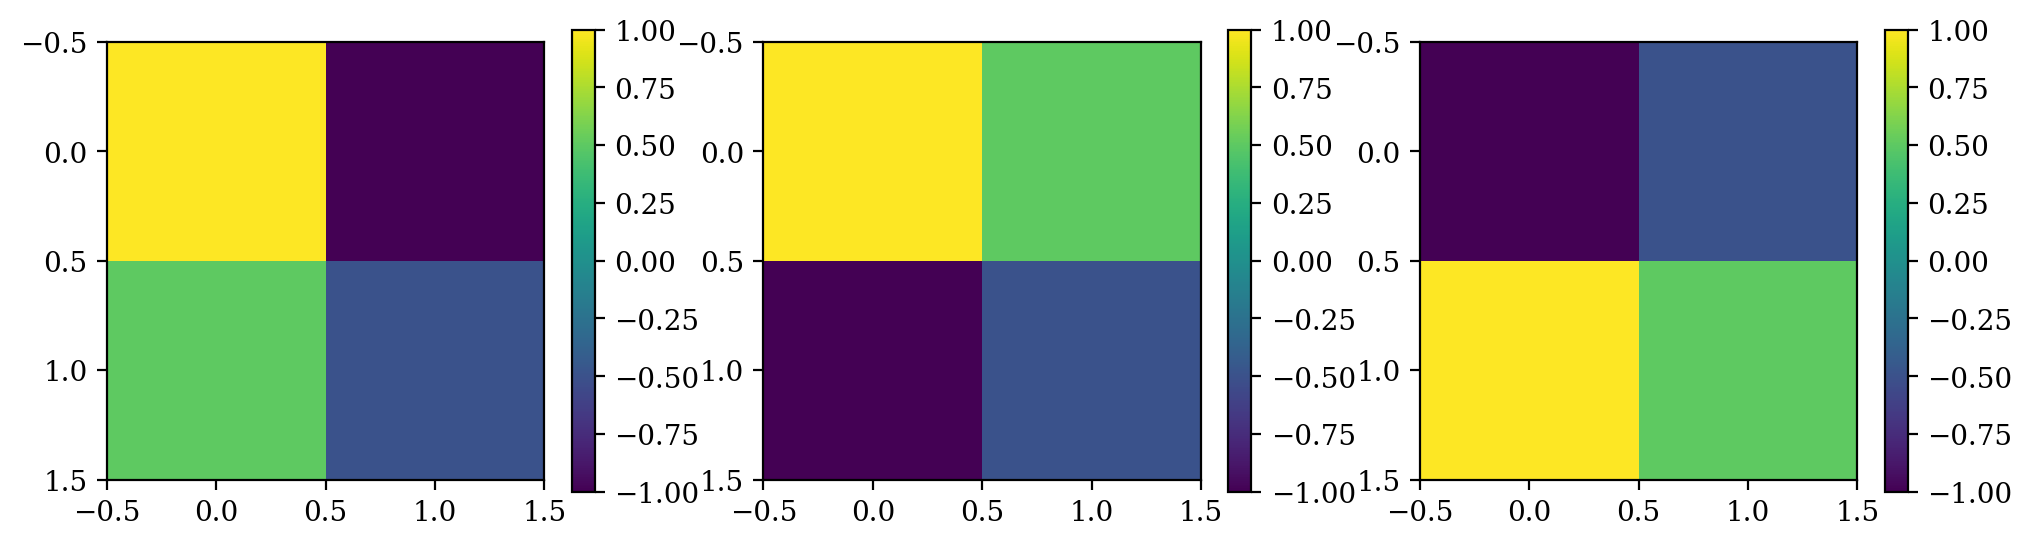

#### Testings v2

angles_list = [0.     0.0312 0.0625 0.0938 0.125  0.1562 0.1875 0.2188 0.25   0.2812
 0.3125 0.3437 0.375  0.4063 0.4375 0.4687 0.5    0.5312 0.5625 0.5938
 0.625  0.6562 0.6875 0.7188 0.75   0.7812 0.8125 0.8438 0.875  0.9062
 0.9375 0.9688] * pi


  0%|                                                                                                         …

check normalisation psi 0.9999999999999997
check normalisation phi 0.9999999999999998
swnf = (30.40364024485673+0j)


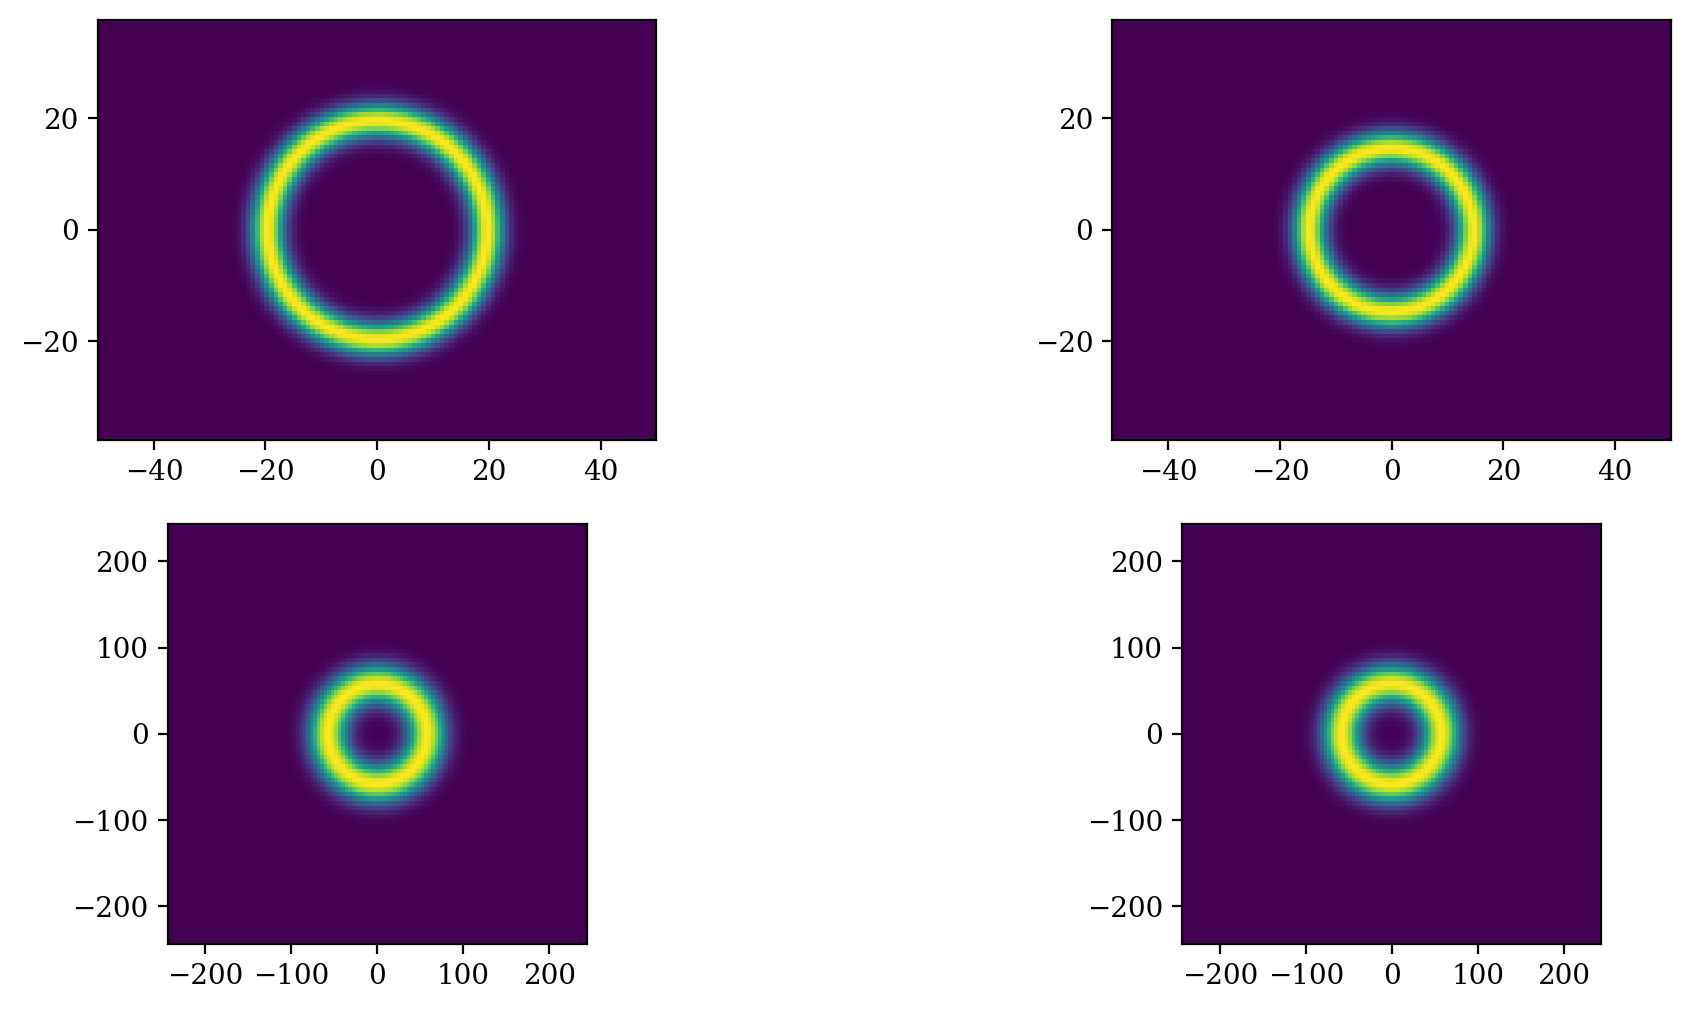

5525.815MB of system memory used


In [105]:
# su = 4
# psi = psi0Pair(dx=20,s3=su,s4=su,pt=0,a=0)
psi = psi0ring_with_logging(dr=40,s3=3,s4=3,pt=2*hb*k,an=32)
t = 0

tempTest3 = only3(psi)
tempTest4 = only4(psi)
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
tempTest3phi = only3phi(phi)
tempTest4phi = only4phi(phi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(tempTest3.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(tempTest4.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow(np.flipud(tempTest3phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.flipud(tempTest4phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
del tempTest3, tempTest4, tempTest3phi, tempTest4phi
current_py_memory_print()

Notes on parameters

`psi = psi0ring(dr=40,s3=2,s4=2,pt=p,an=32,logging=True)` took fucking 15 minutes to generate but it looks pretty smooth

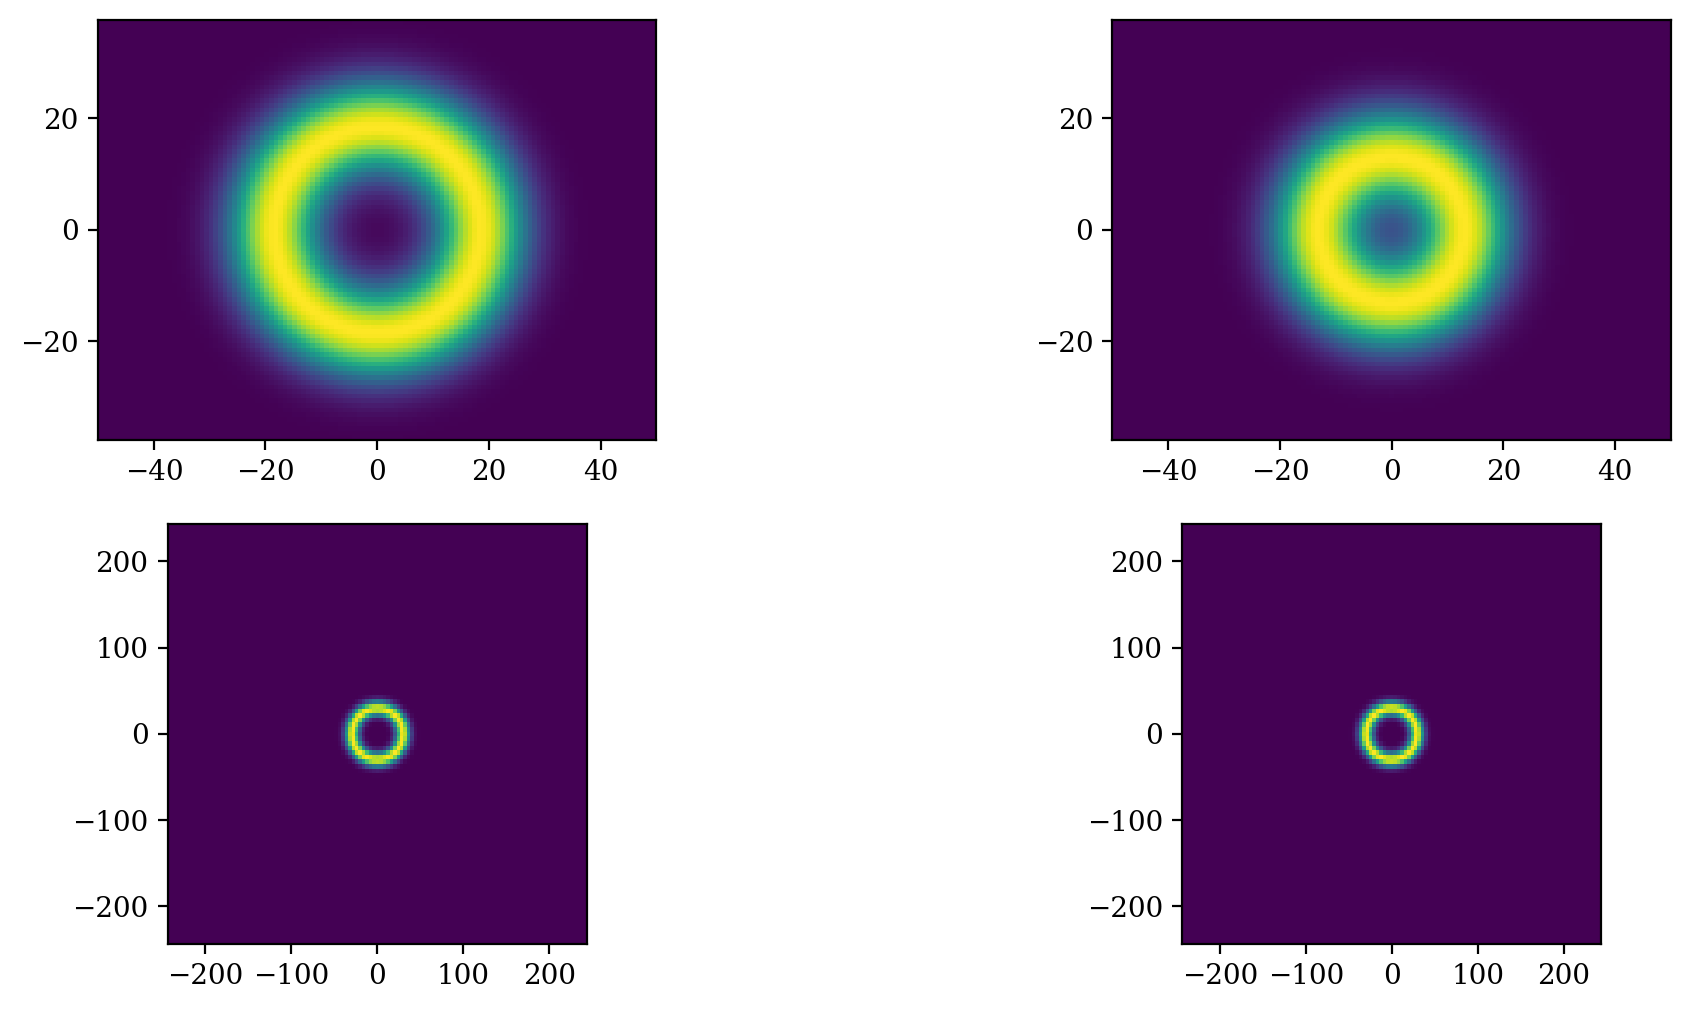

`psi = psi0ring_with_logging(dr=40,s3=3,s4=3,pt=2*hb*k,an=32)`
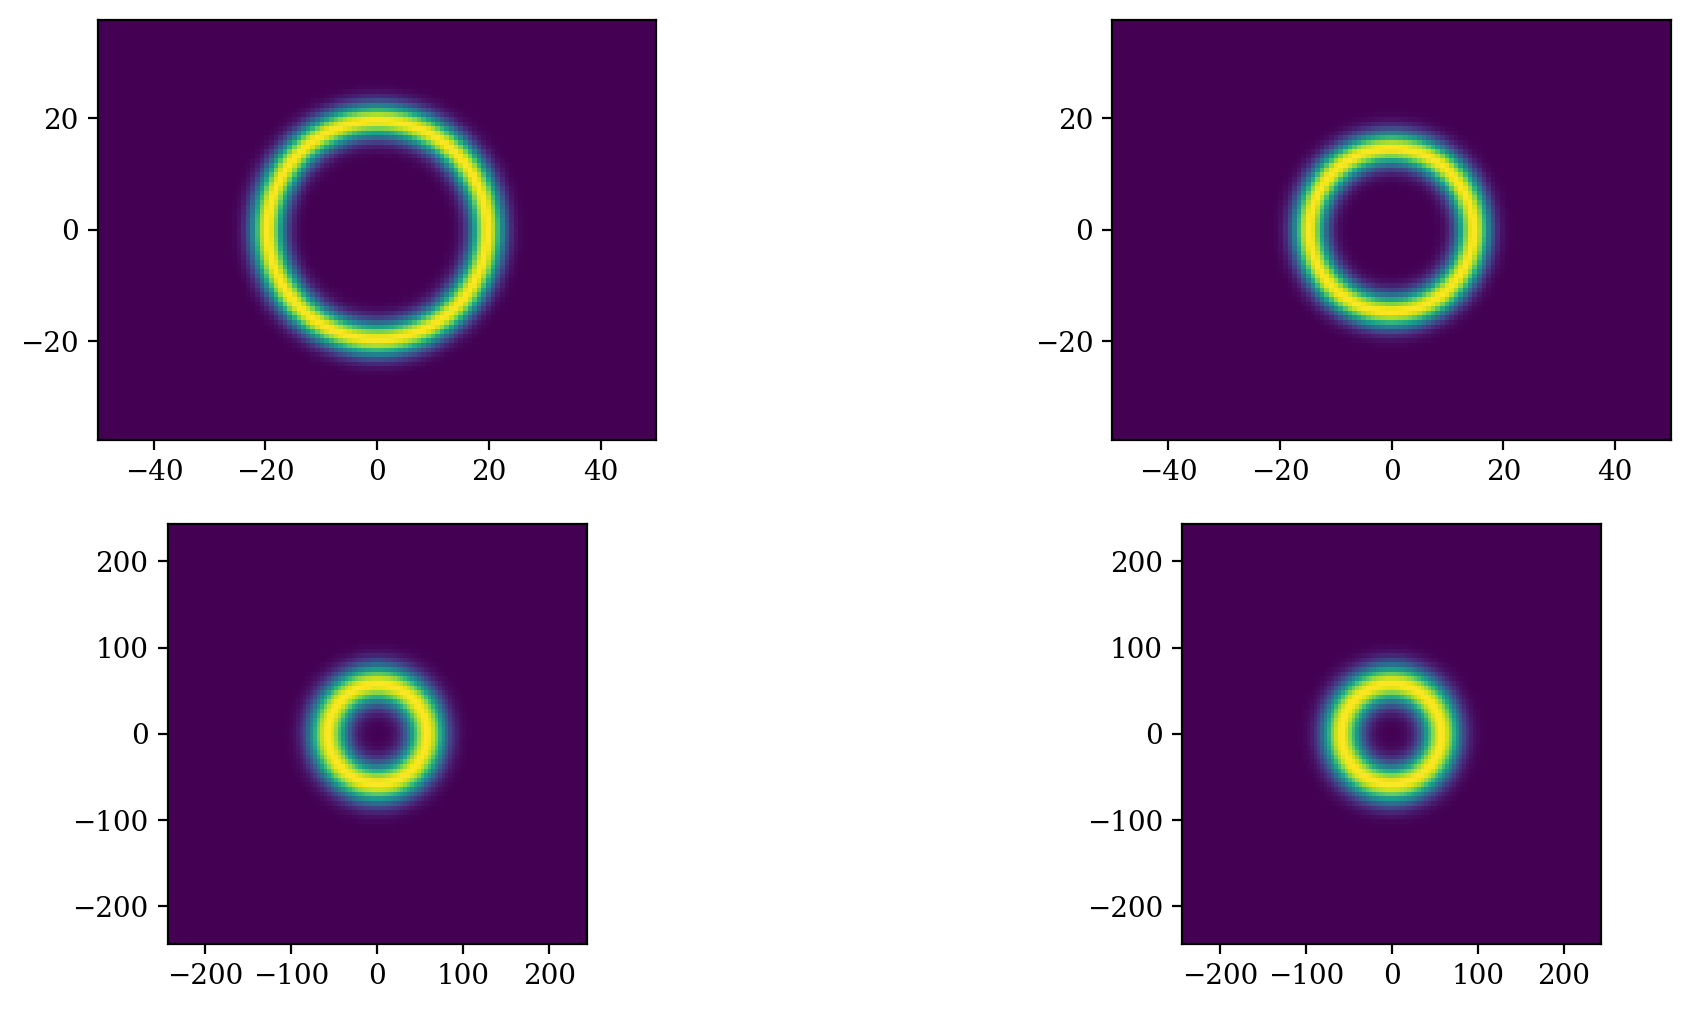

In [106]:
((nx-1)/2, (nz-1)/2)

(60.0, 45.0)

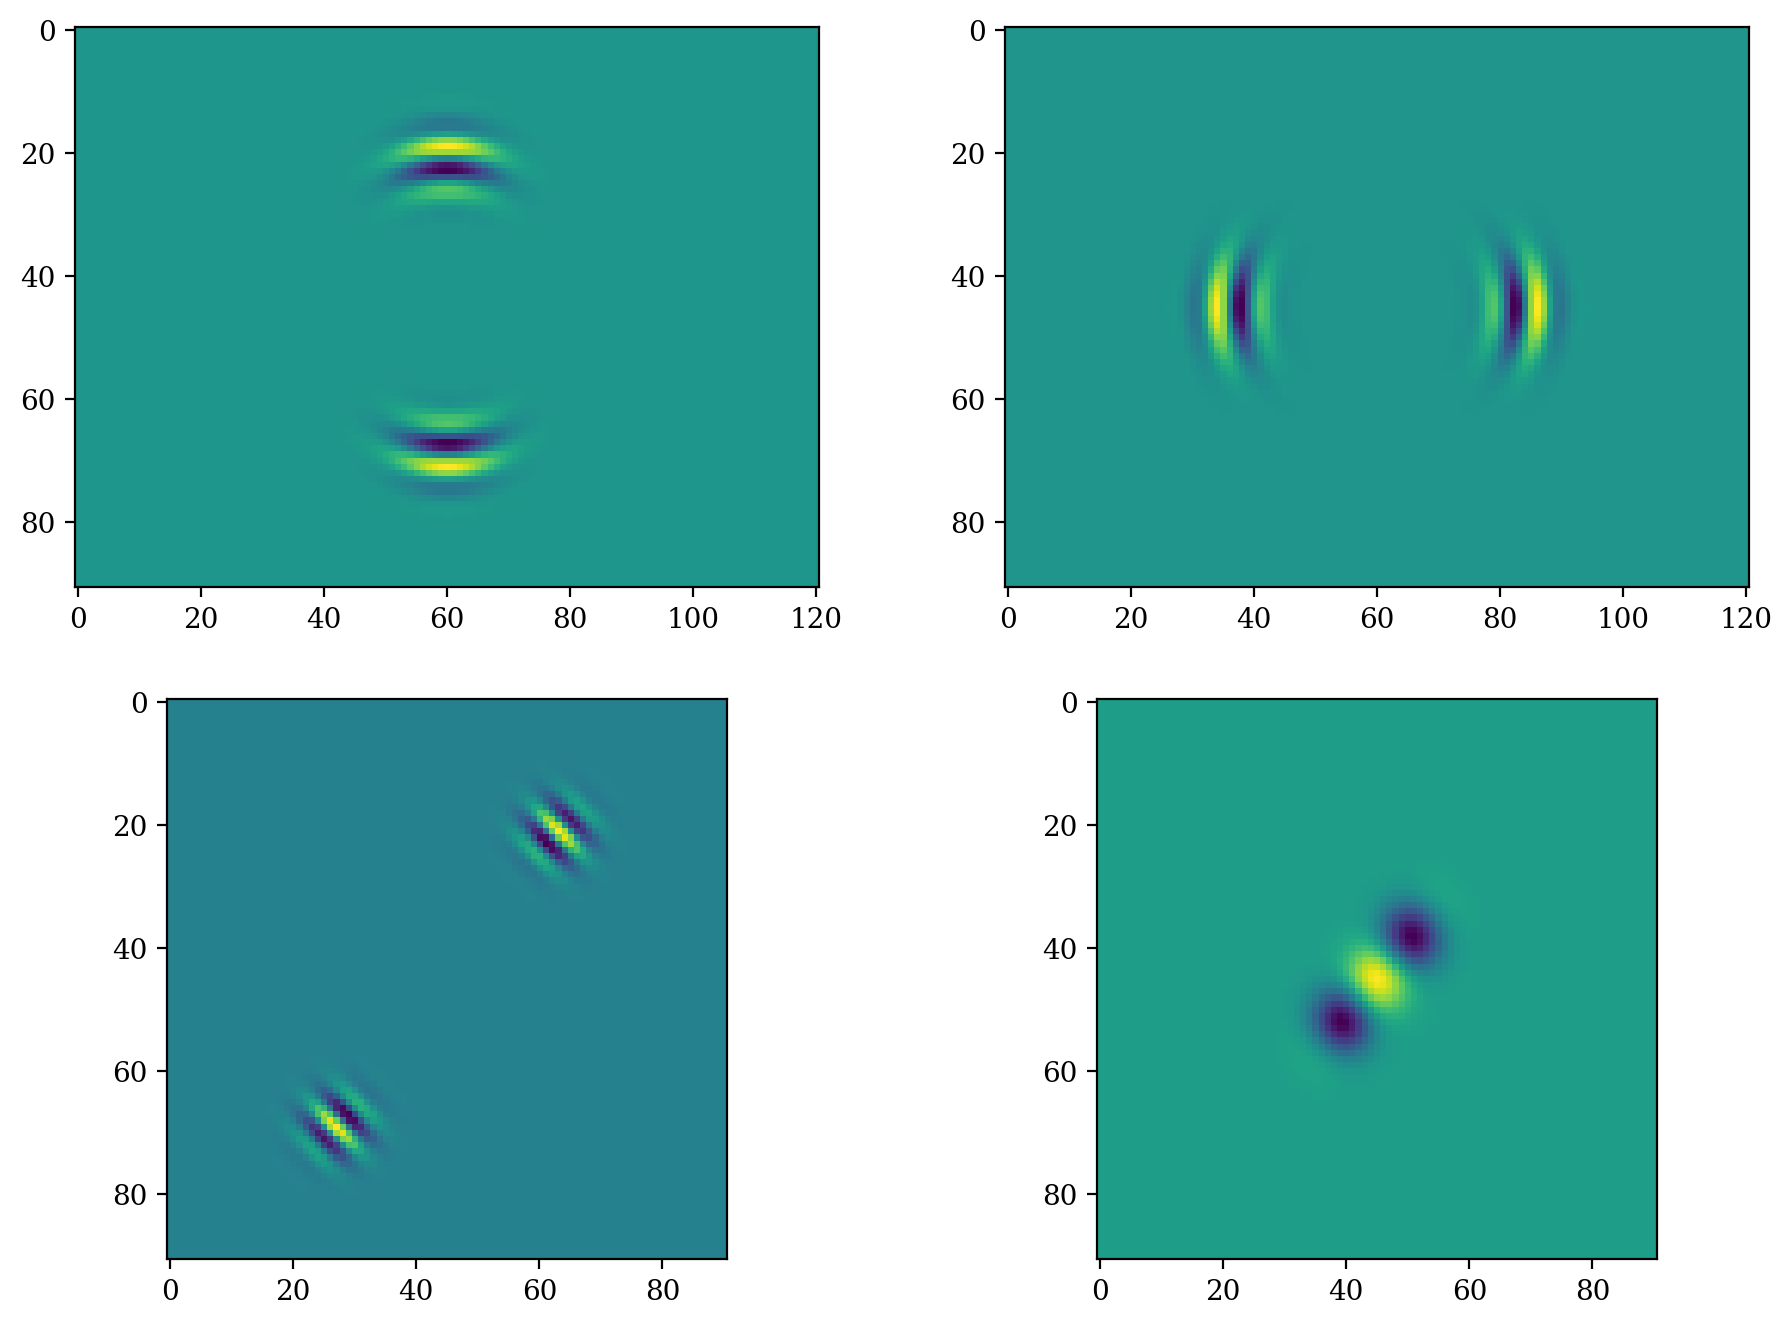

In [107]:
plt.figure(figsize=(11,8))
plt.subplot(2,2,1)
plt.imshow(np.real(psi[60,:,:,45]))
plt.subplot(2,2,2)
plt.imshow(np.real(psi[:,45,60,:].T))
plt.subplot(2,2,3)
plt.imshow(np.real(psi[60,:,60,:]))
plt.subplot(2,2,4)
plt.imshow(np.real(psi[30,:,90,:]))

no idea what those mean...

## Correlation Function

In [37]:
def gx3x4_calc(psi,cut=5.01):
    ind = abs(zlin) < cut*dz
    gx3x4 = np.trapz(np.abs(psi[:,:,:,ind])**2,zlin[ind],axis=3)
    gx3x4 = np.trapz(gx3x4[:,ind,:],zlin[ind],axis=1)
    return gx3x4

In [38]:
def plot_gx3x4(gx3x4,cut):
    xip = xlin > 0
    xim = xlin < 0
    gpp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xip],xlin[xip],axis=0)
    gpm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xip],xlin[xip],axis=0)
    gmp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xim],xlin[xim],axis=0)
    gmm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xim],xlin[xim],axis=0)
    E = (gpp+gmm-gpm-gmp)/((gpp+gmm+gpm+gmp))
    
    plt.imshow(np.flipud(gx3x4.T),extent=[-xmax,xmax,-xmax,xmax])
    plt.title("$g^{(2)}_{\pm\pm}$ of $z_\mathrm{cut} = "+str(cut)+"dz$ and $E="+str(round(E,4))+"$")
    plt.xlabel("$x_3$")
    plt.ylabel("$x_4$")
    plt.axhline(y=0,color='white',alpha=0.8,linewidth=0.7)
    plt.axvline(x=0,color='white',alpha=0.8,linewidth=0.7)
    plt.text(+xmax*0.6,+xmax*0.8,"$g^{(2)}_{++}="+str(round(gpp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,+xmax*0.8,"$g^{(2)}_{-+}="+str(round(gmp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(+xmax*0.6,-xmax*0.8,"$g^{(2)}_{+-}="+str(round(gpm,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,-xmax*0.8,"$g^{(2)}_{--}="+str(round(gmm,4))+"$", color='white',ha='center',alpha=0.9)
    

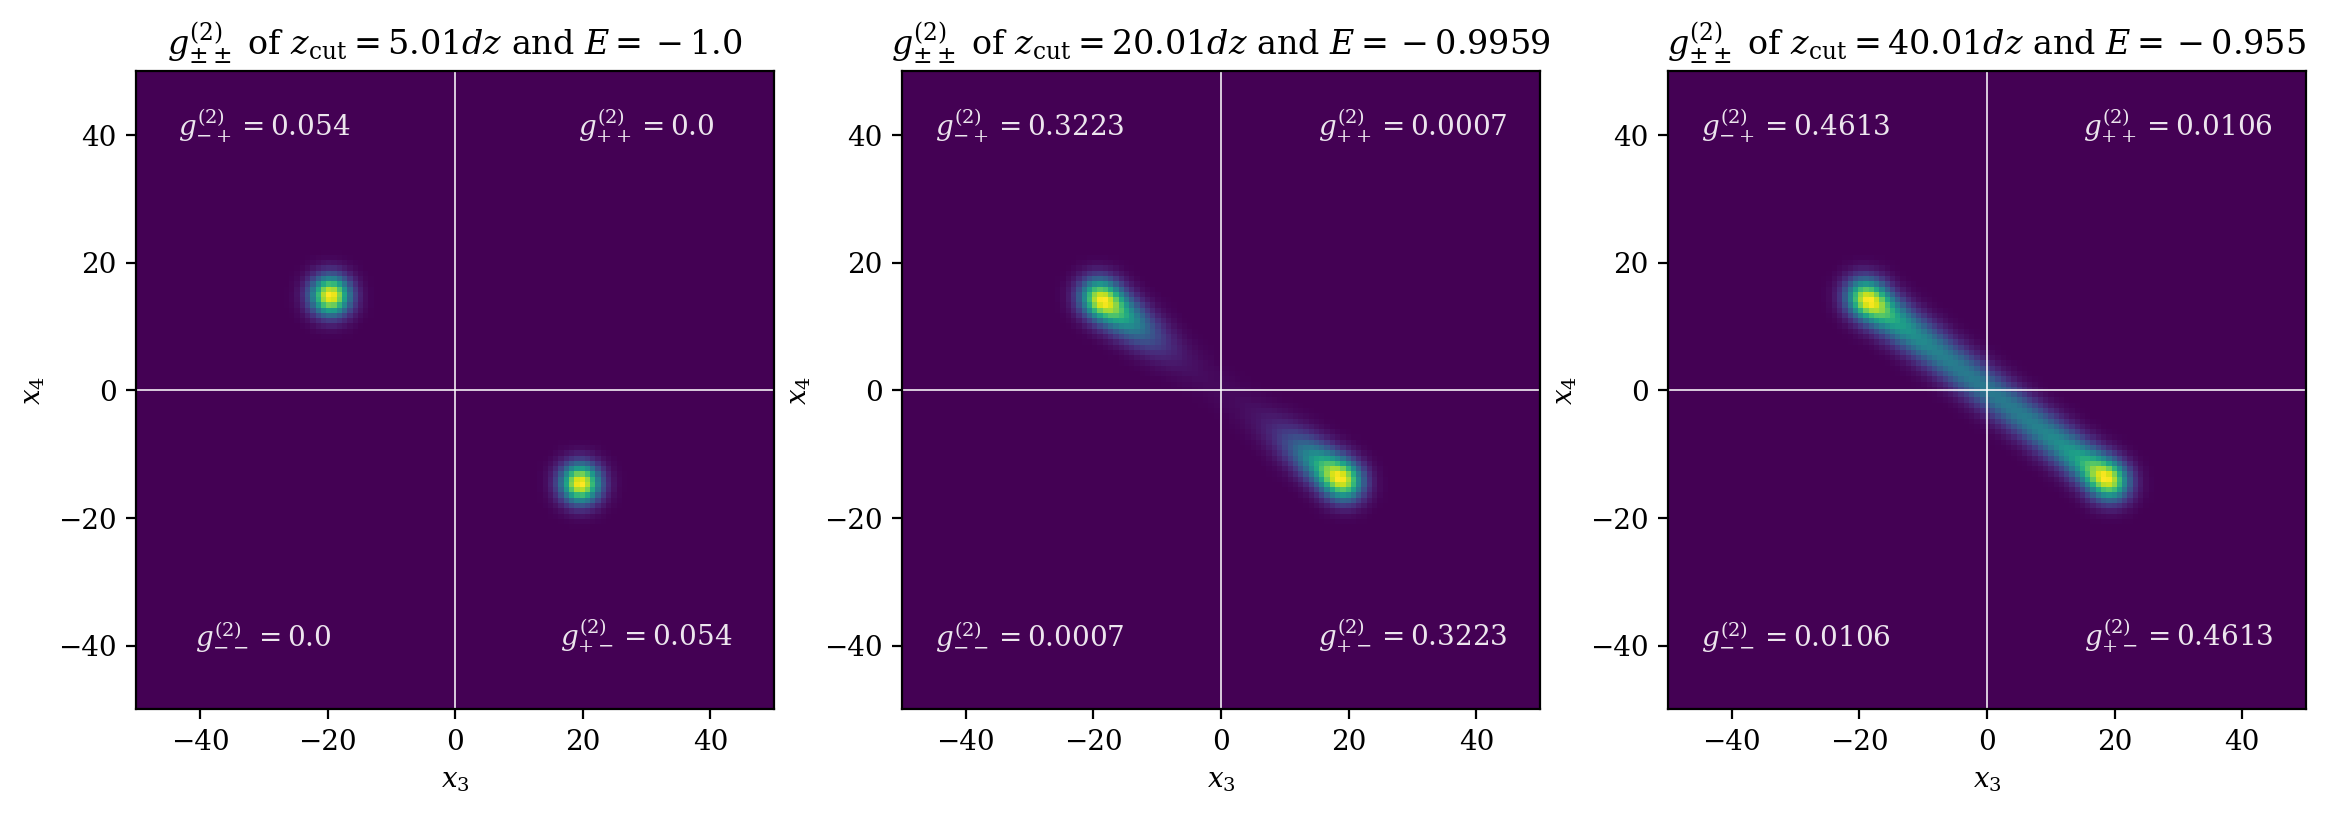

In [110]:
plt.figure(figsize=(14,6))

cut_list = [5.01, 20.01, 40.01]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()

 eq on p.73 GoodNotes document
 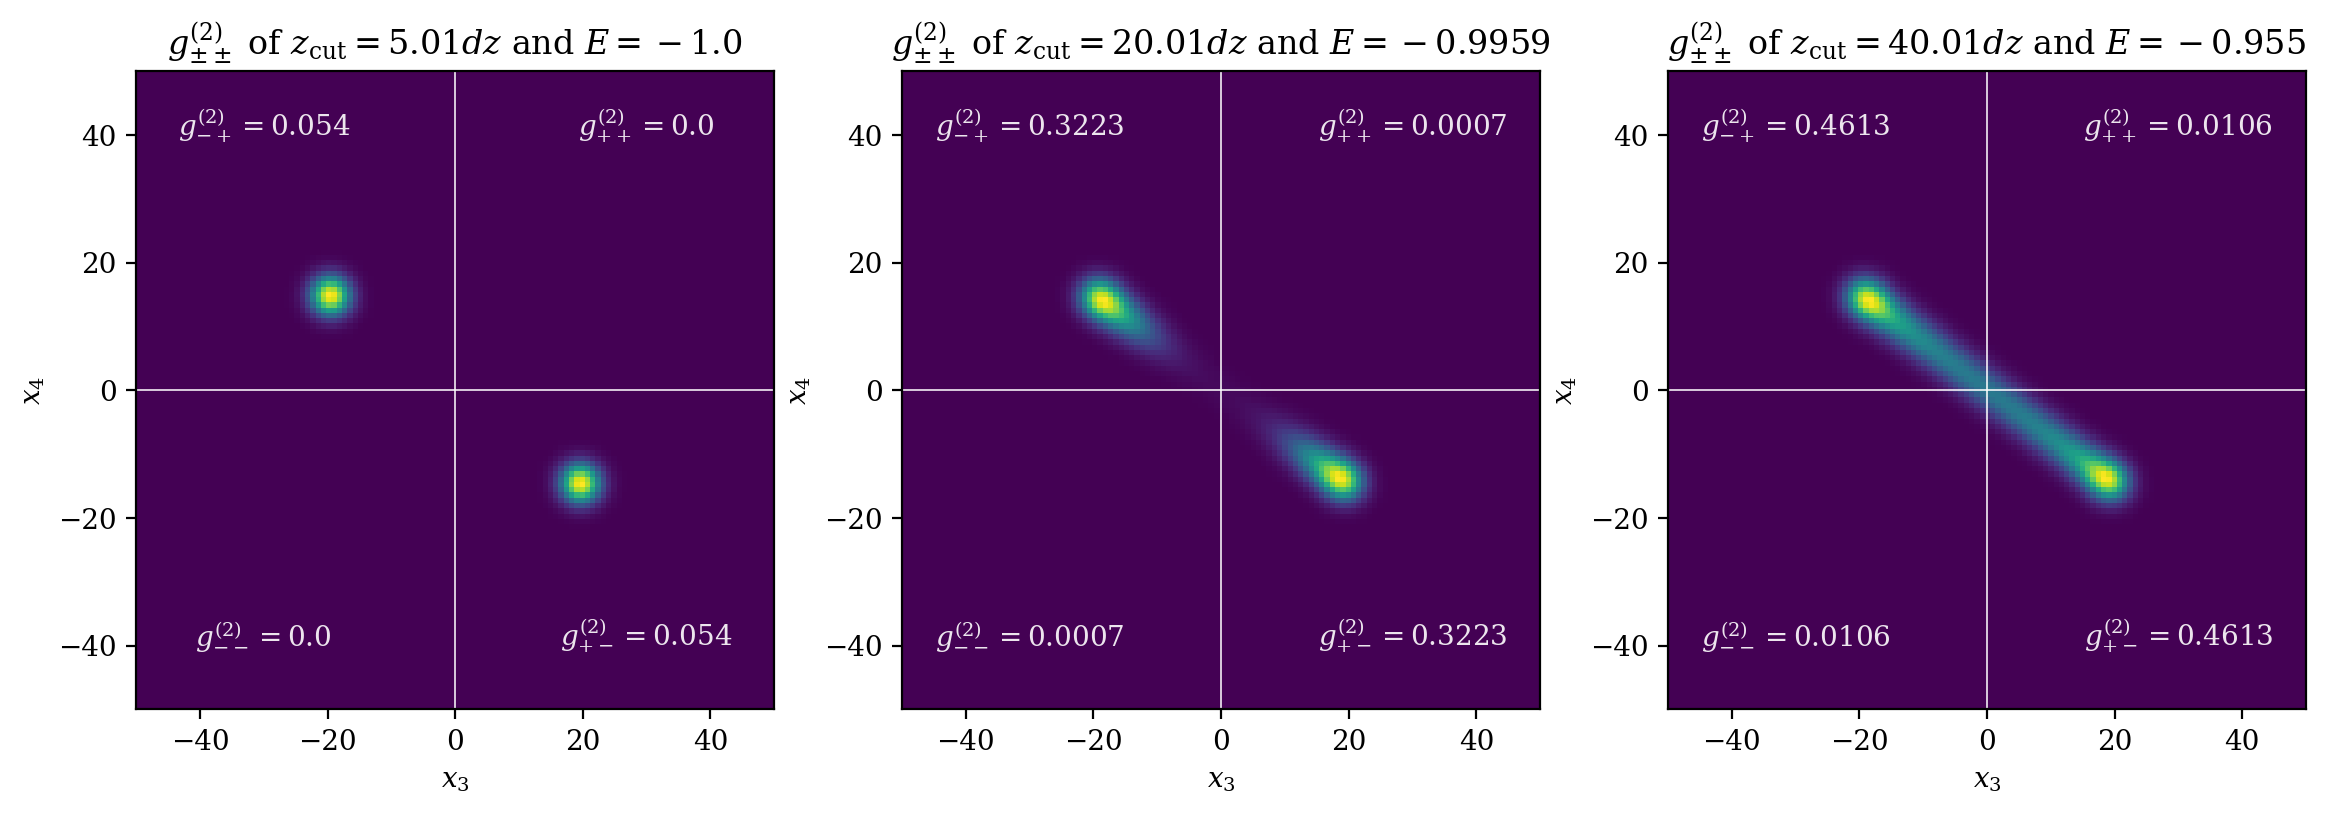

## FFT to momentum

In [41]:
@jit(forceobj=True, cache=True)
def only3phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2)
#     return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=2),dx=dpz,axis=2)
@jit(forceobj=True, cache=True)
def only4phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=0),dx=dpz,axis=0)

@njit(cache=True)
def check_norm_phi(phi):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2),dx=dpz,axis=1),dx=dpx,axis=0)
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2))))*(dpx*dpx*dpz*dpz)



In [60]:
@jit(forceobj=True, cache=True)
def phiAndSWNF(psi):
    phiUN = np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)
    superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return phi, (swnf+0*1j)

@jit(forceobj=True, cache=True)
def toPhi(psi, swnf) -> np.ndarray:
    return np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)/swnf

@jit(forceobj=True, cache=True)
def toPsi(phi, swnf) -> np.ndarray:
    return pyfftw.interfaces.numpy_fft.ifftn(np.fft.ifftshift(np.flip(np.flip(phi*swnf,axis=3),axis=1)),threads=nthreads,norm='ortho')




In [61]:
# # @njit(parallel=True,cache=True)
# @jit
# def phiAndSWNF(psi):
#     phiUN = np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)
#     superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
#     swnf = sqrt(superWeirdNormalisationFactorSq)
#     phi = phiUN/swnf
#     return phi, swnf

# @njit(parallel=True,cache=True)
# def toPhi(psi, swnf):
#     return np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)/swnf

# @njit(parallel=True,cache=True)
# def toPsi(phi, swnf):
#     return np.fft.ifftn(np.fft.ifftshift(np.fliplr(phi*swnf)),norm='ortho')

In [62]:
phi, swnf = phiAndSWNF(psi)

In [63]:
check_norm_phi(phi)

0.9999999999999998

In [117]:
del t, psi, phi, swnf

## Scattering via contact potential ?

In [64]:
3*hb*k/m3

59.85469137769496

In [193]:
# numba.set_num_threads(8)

In [197]:
# del psi_test

In [65]:
@jit(nogil=True, parallel=True, forceobj=True)
def scattering_evolve_loop_helper(t_init, psi_init, swnf, steps=20, progress_proxy=None):
    t = t_init
    psi = psi_init
    #phi = psi_init # just so there's a type reference
    for ia in prange(steps):
        psi *= expContact
#         with objmode(phi='complex128[:,:,:,:]'):
        phi = toPhi(psi,swnf)
        phi *= expP34Grid
#         with objmode(psi='complex128[:,:,:,:]'):
        psi = toPsi(phi,swnf)
        psi *= expContact
        t += dt 
        if progress_proxy != None:
            progress_proxy.update(1)
    return (t,psi,phi)

In [66]:
print_every = 50
frames_count = 20
total_steps = print_every * frames_count
print(total_steps)

1000


  0%|                                                                                                         …

t = 0 		 frame = 0 		 memory used: 16148.66MB  


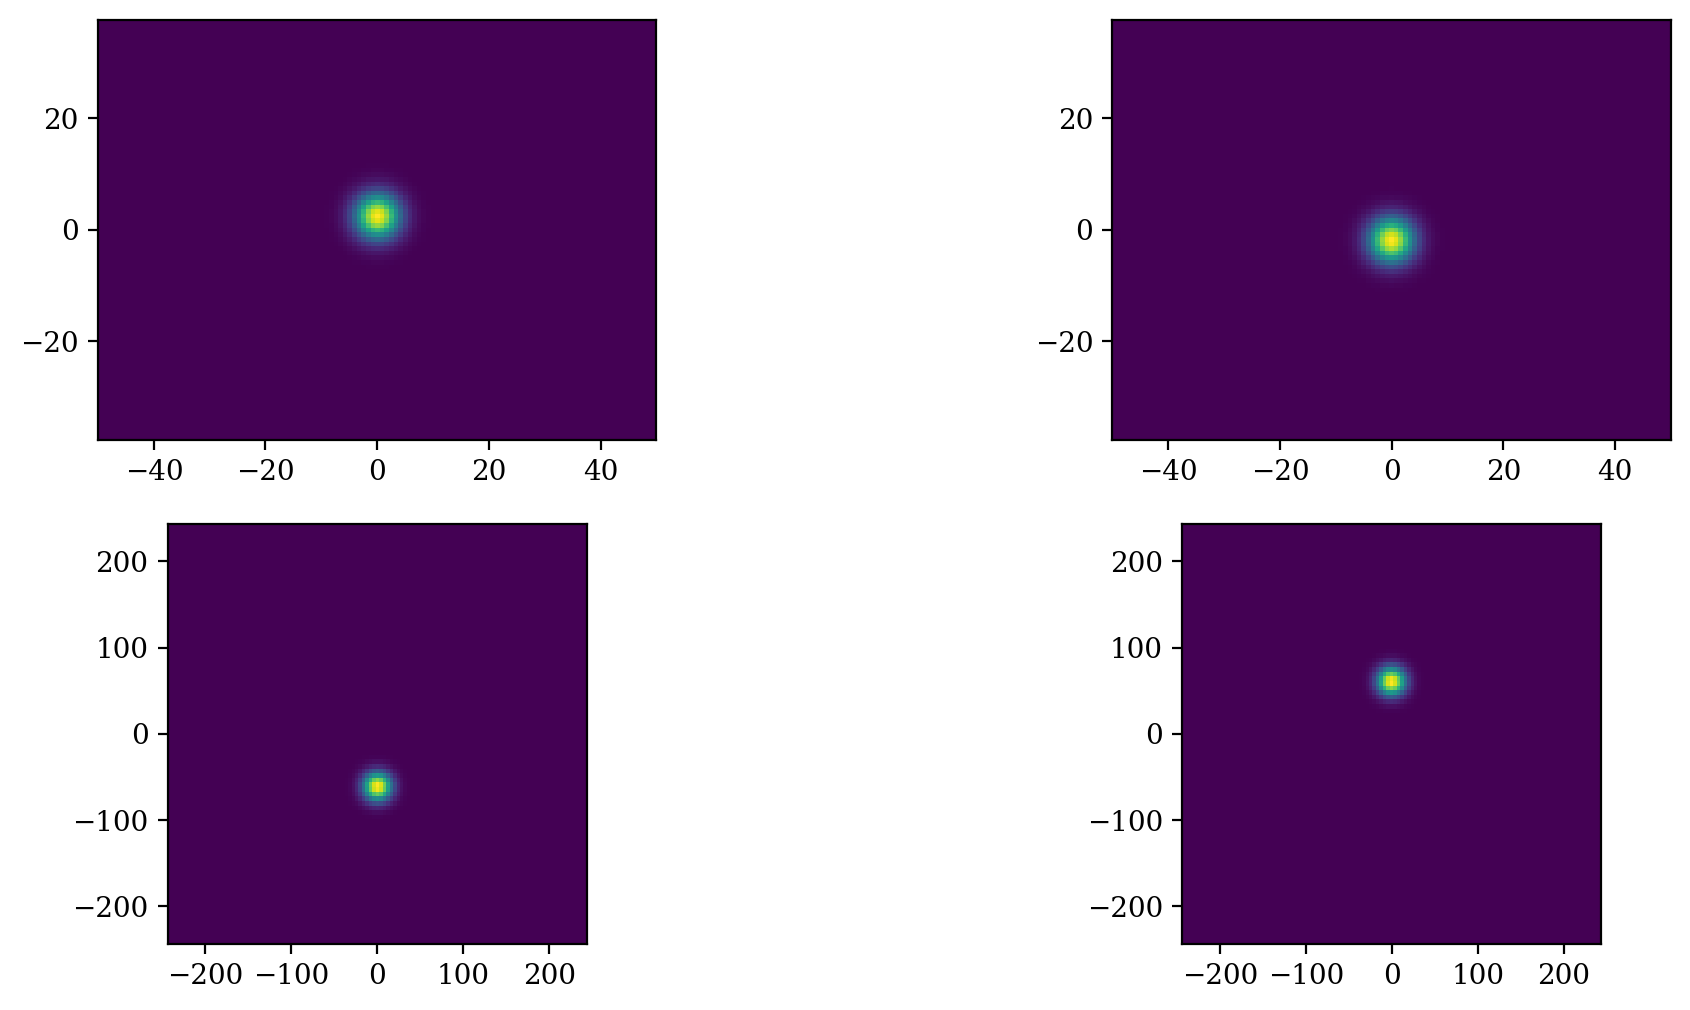

t = 0.025 		 frame = 1 		 memory used: 9655.435MB  


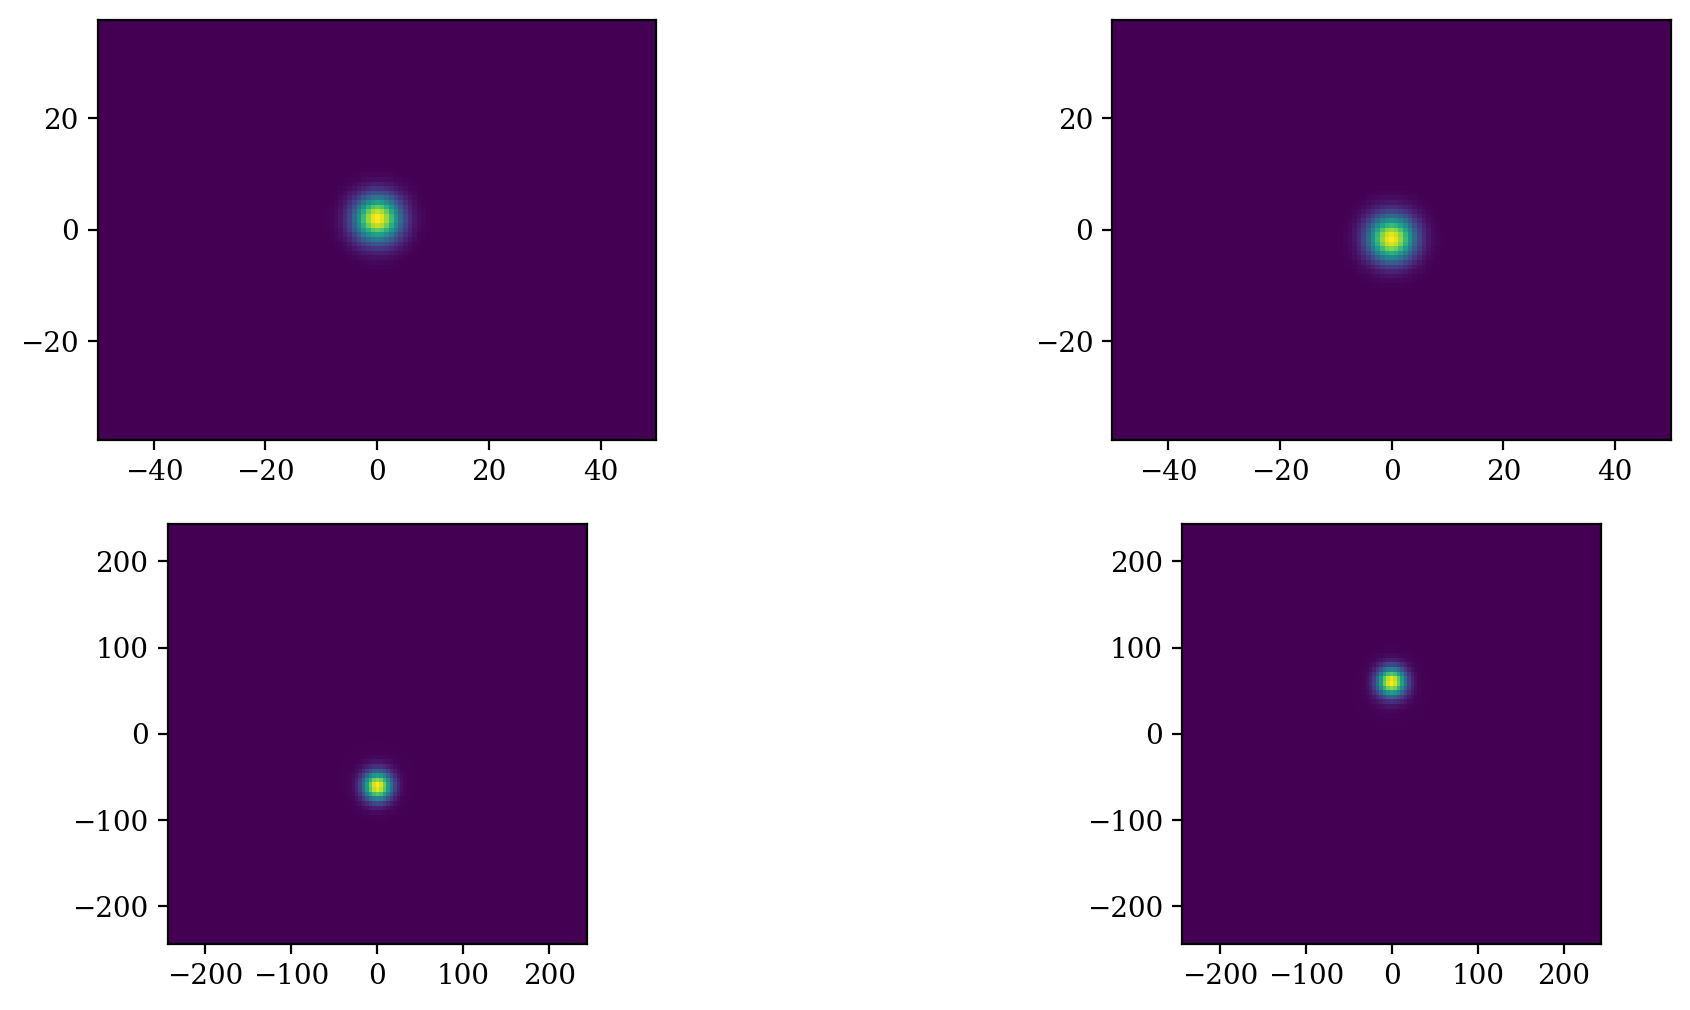

t = 0.05 		 frame = 2 		 memory used: 9810.69MB  


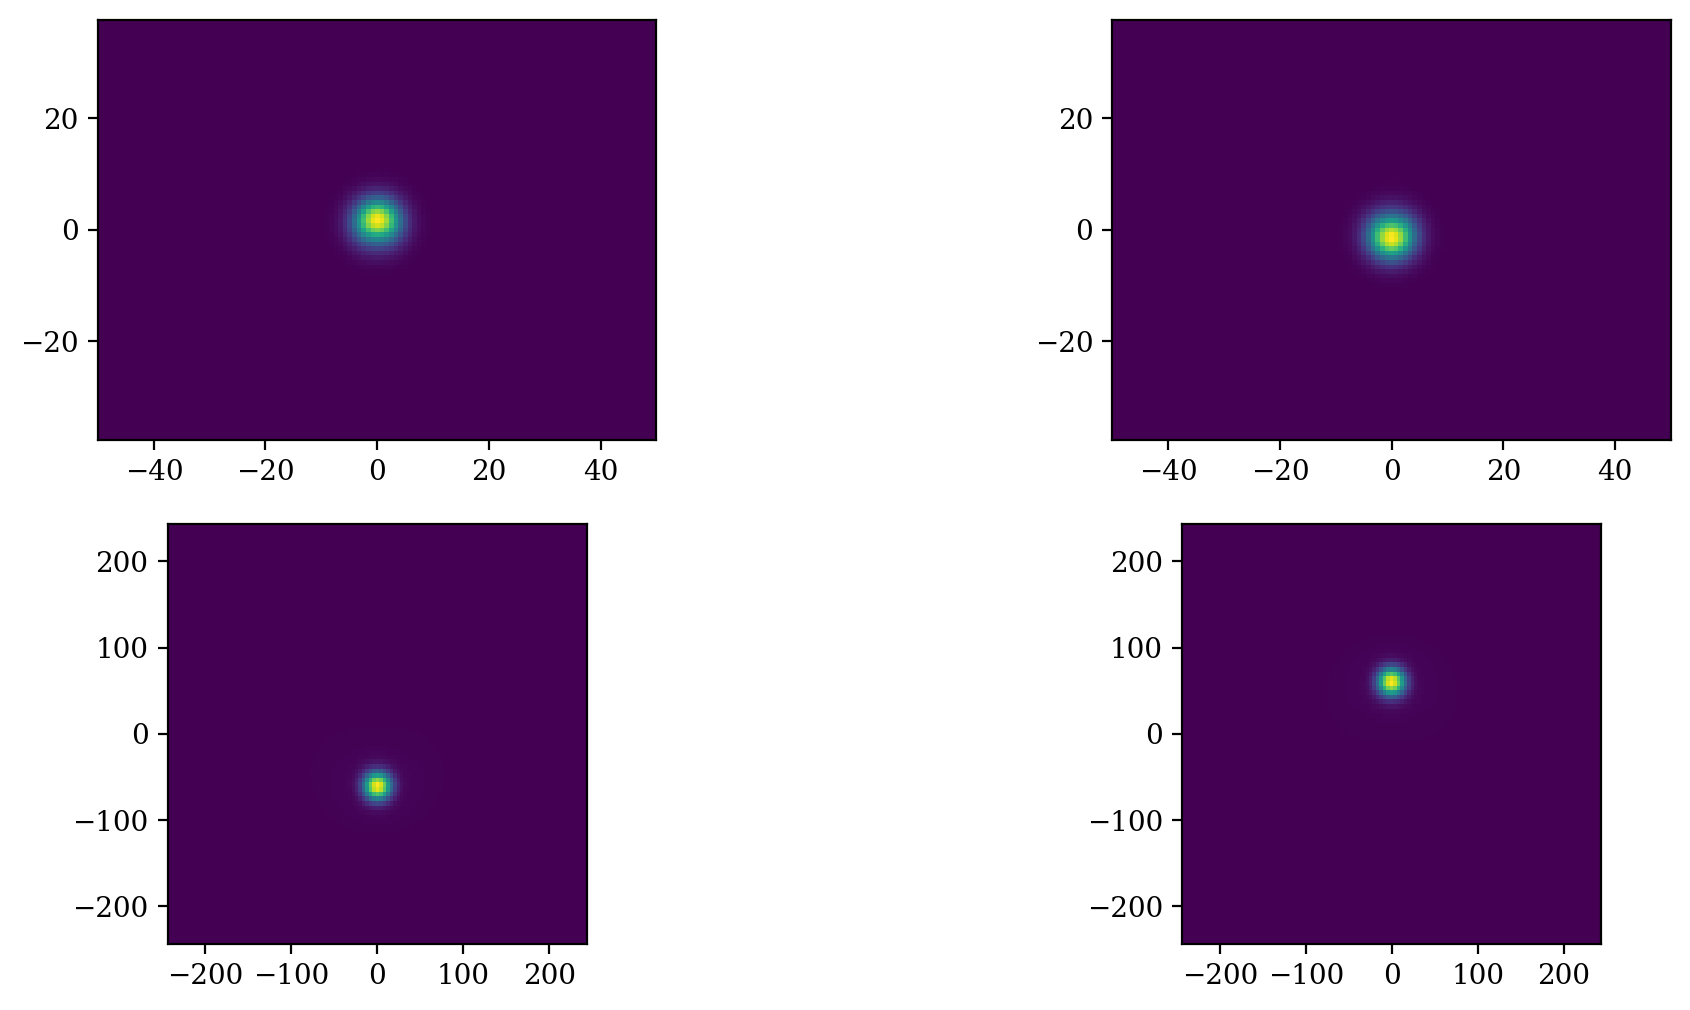

t = 0.075 		 frame = 3 		 memory used: 9810.903MB  


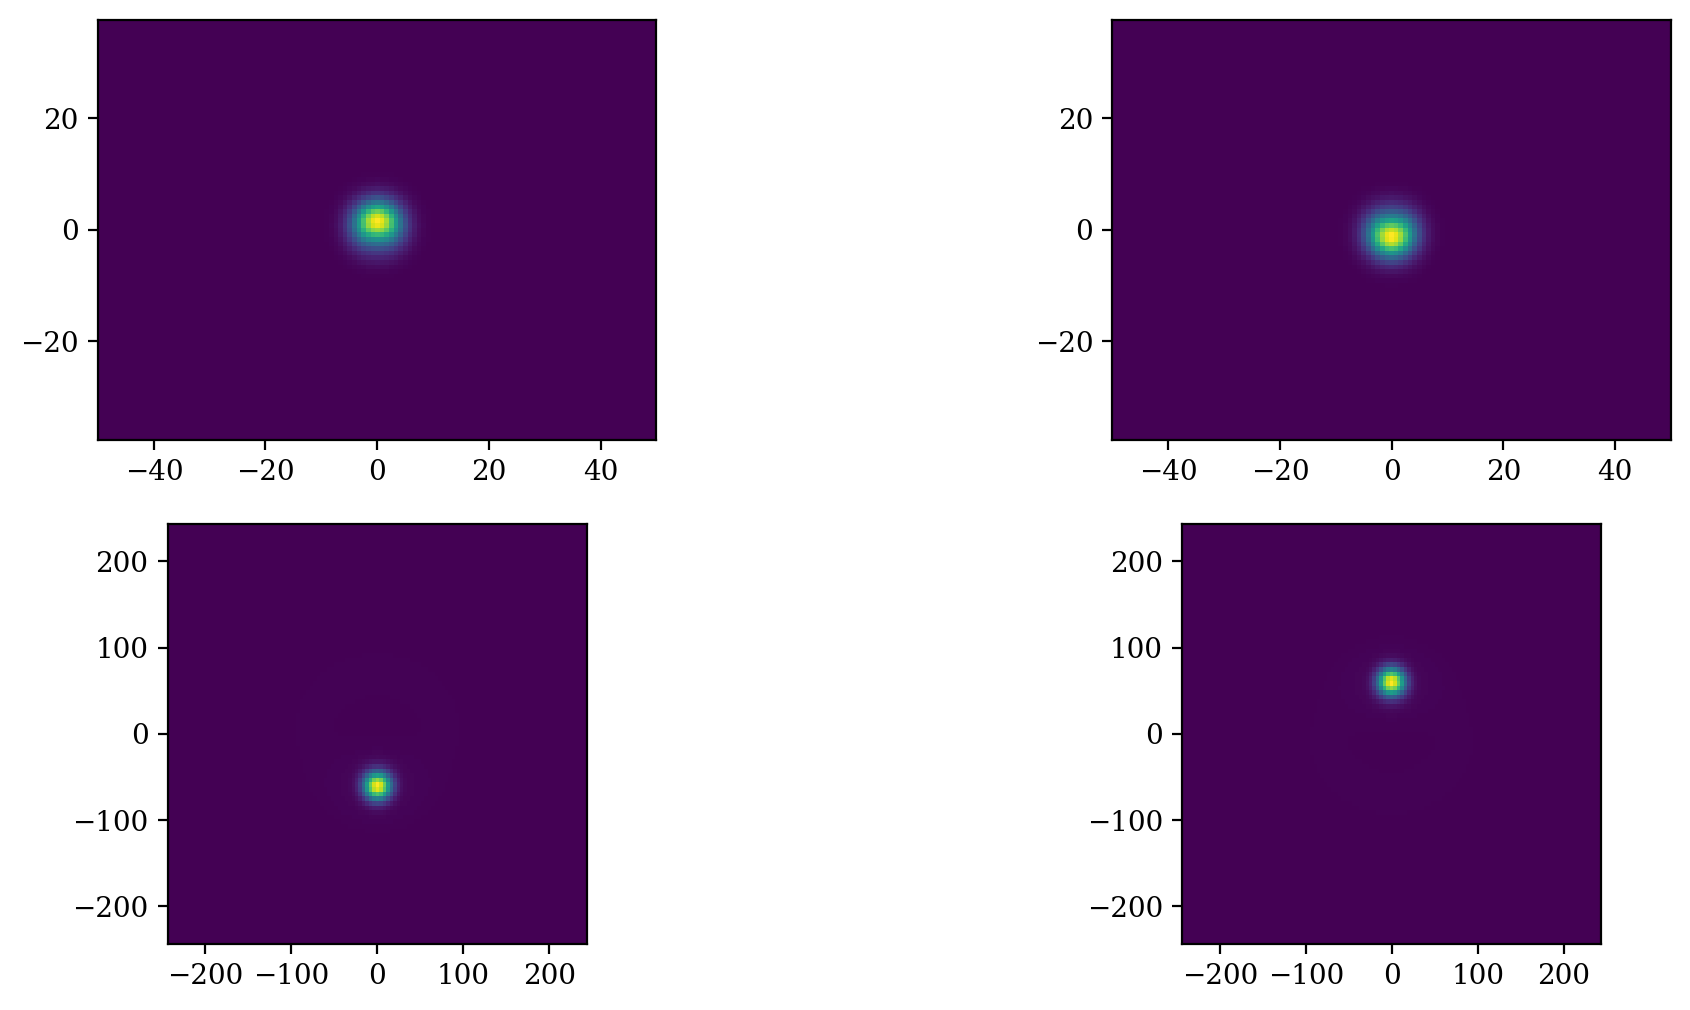

t = 0.1 		 frame = 4 		 memory used: 7855.374MB  


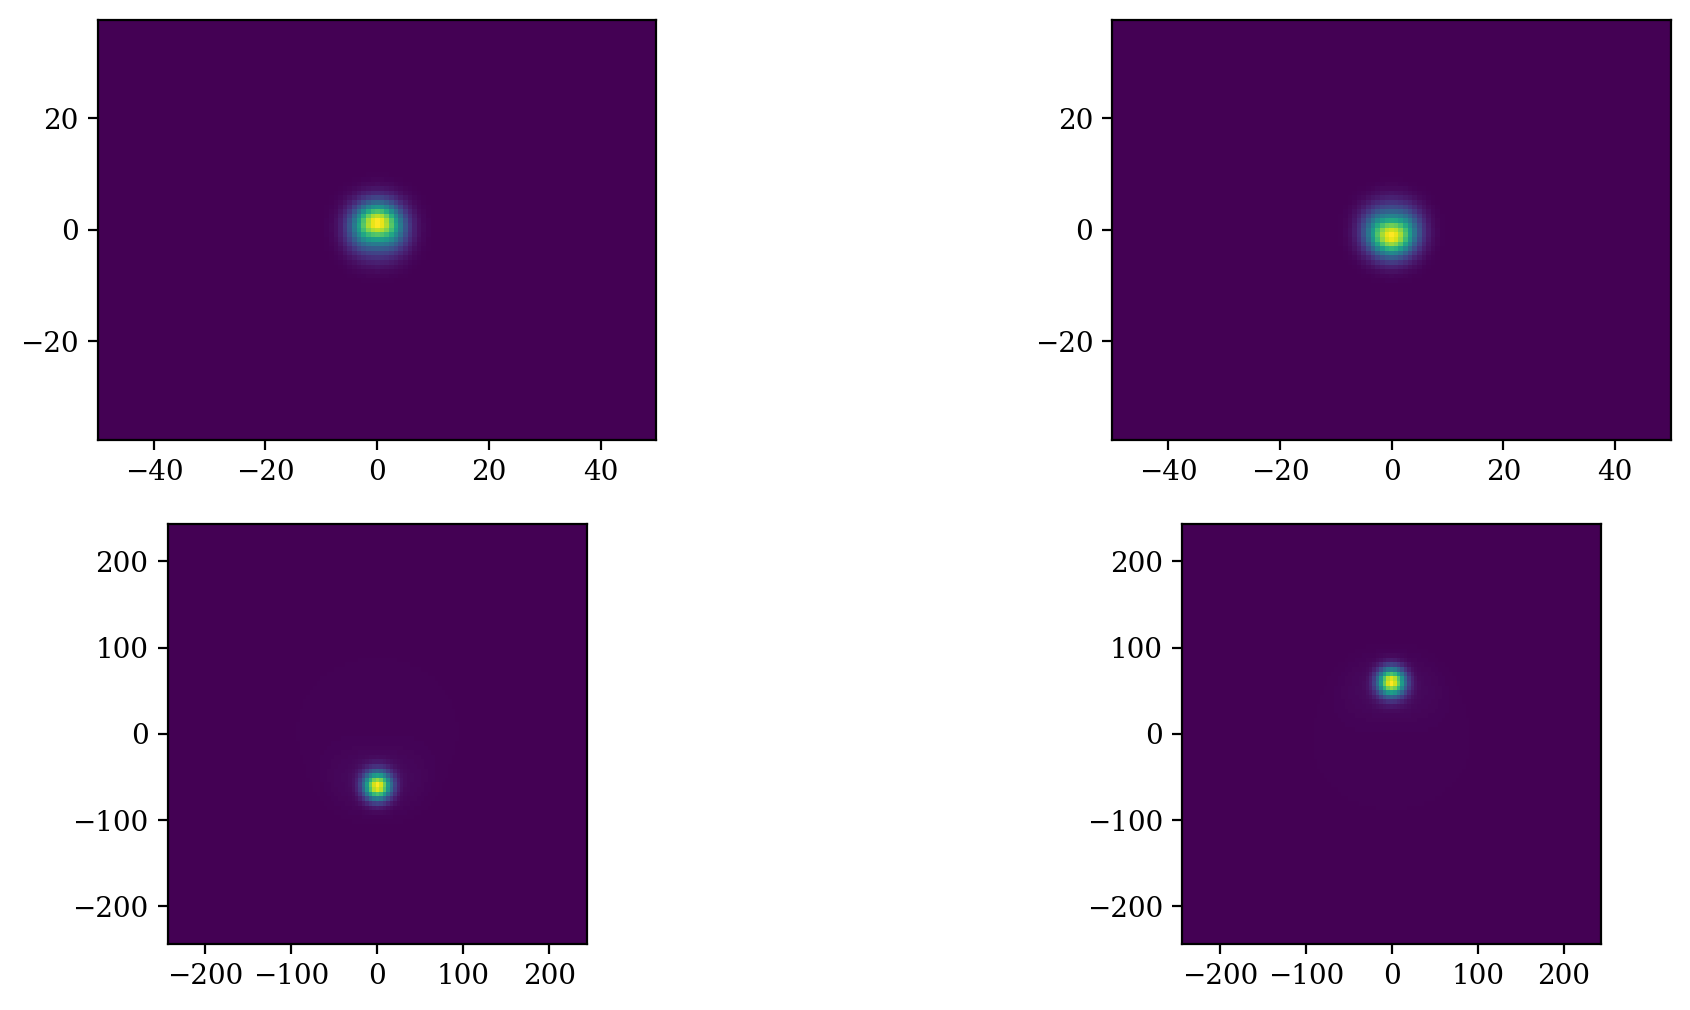

t = 0.125 		 frame = 5 		 memory used: 7854.178MB  


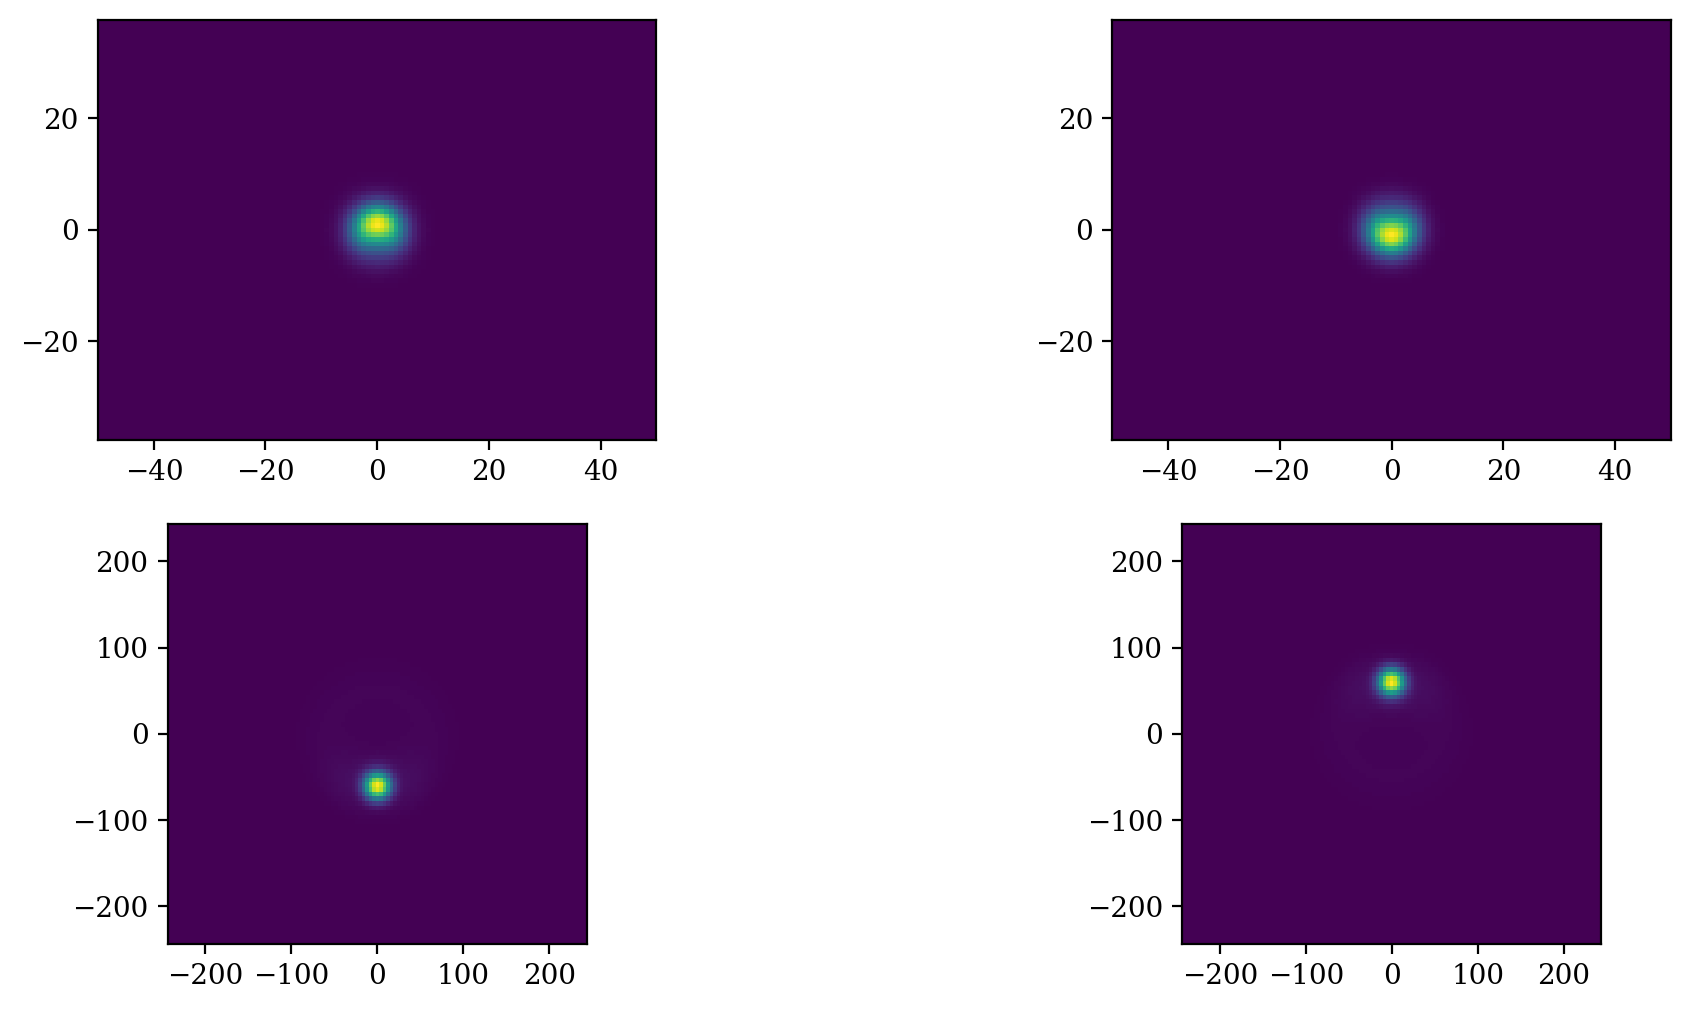

t = 0.15 		 frame = 6 		 memory used: 7923.515MB  


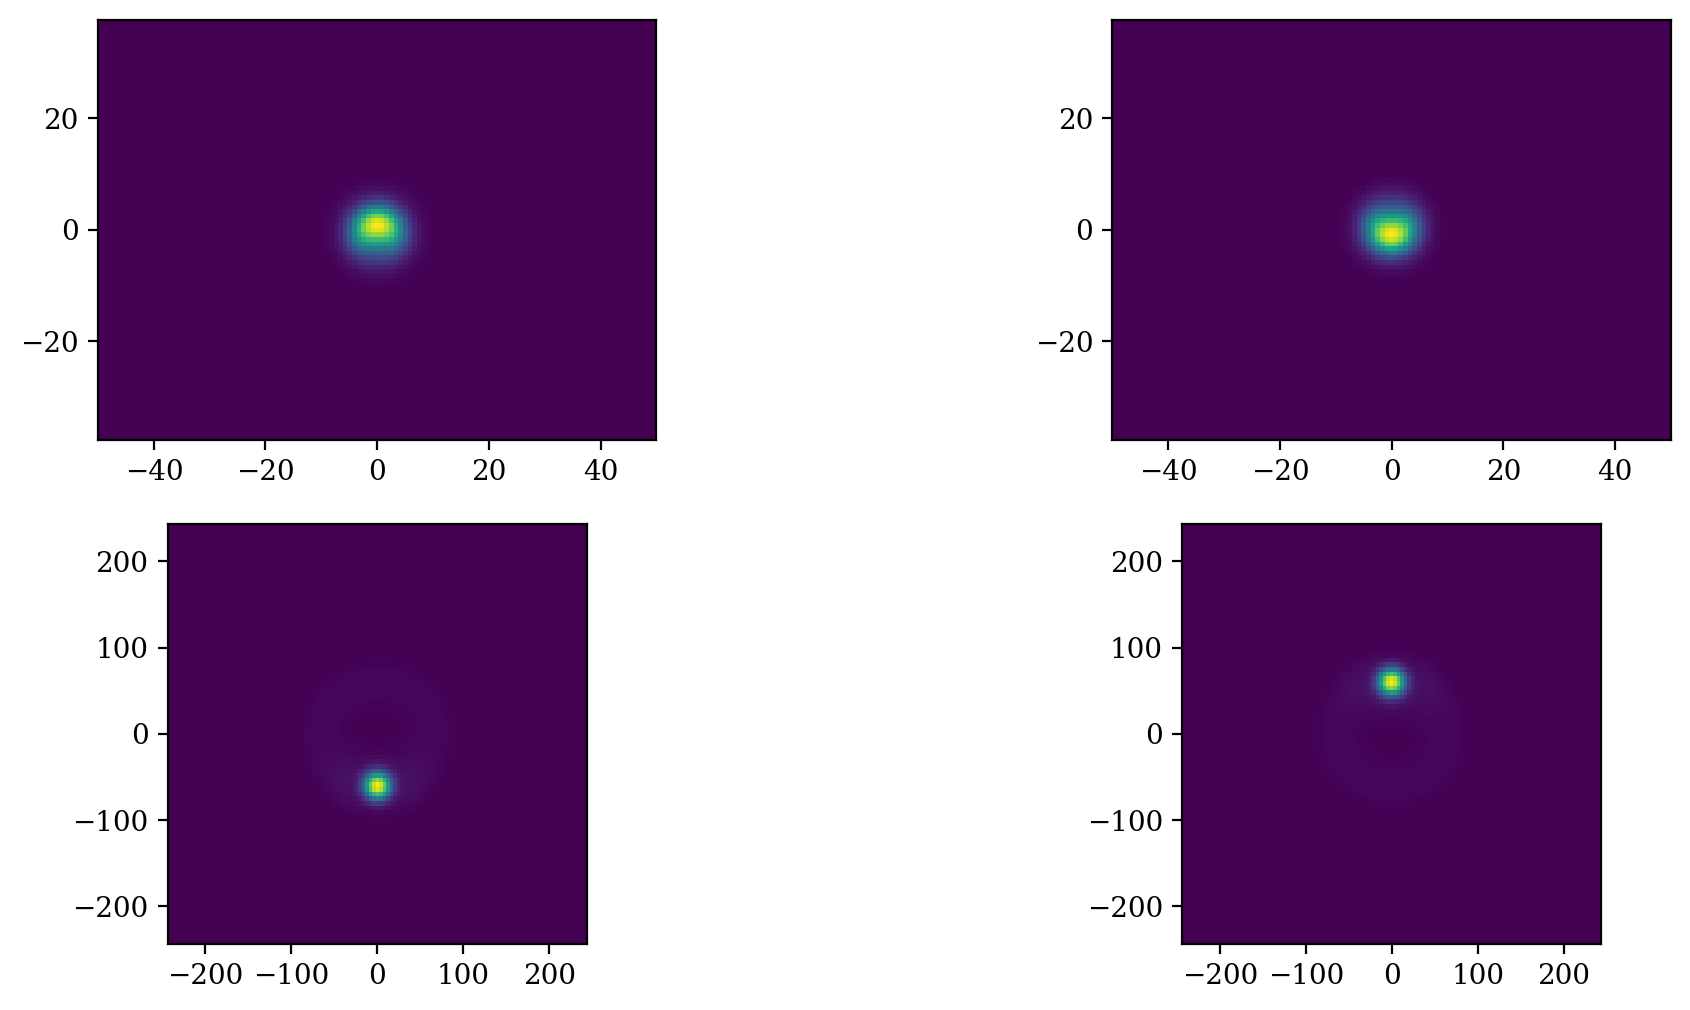

t = 0.175 		 frame = 7 		 memory used: 7860.175MB  


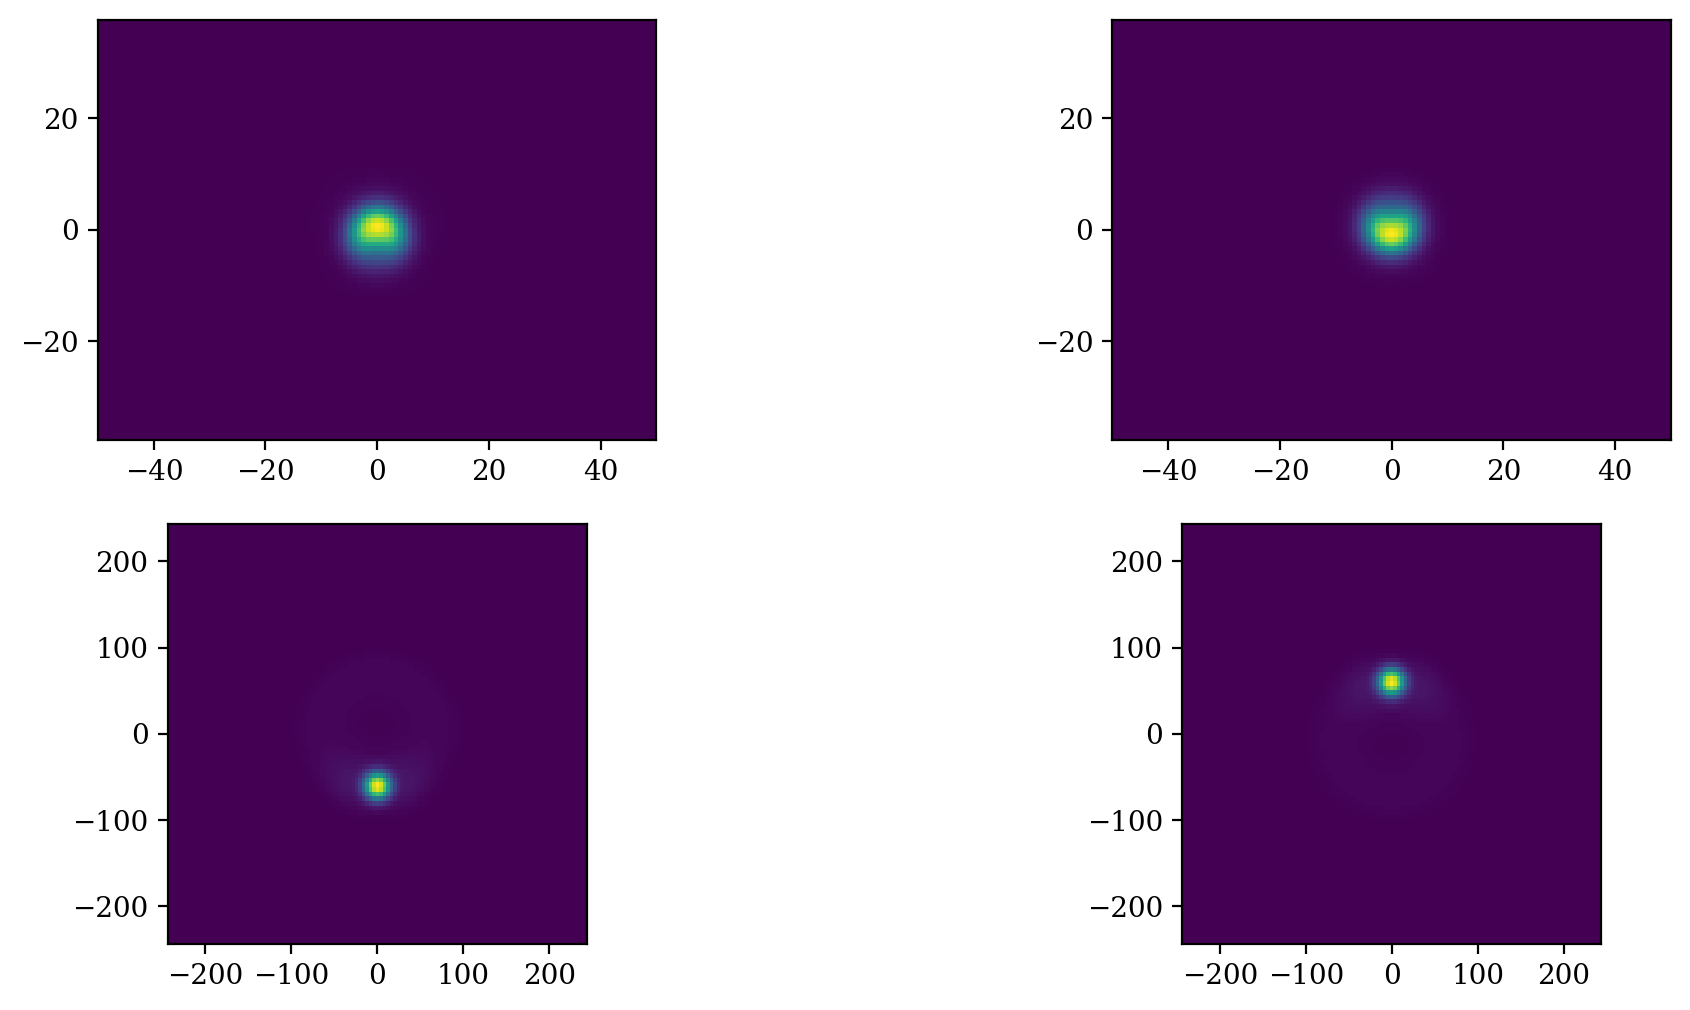

t = 0.2 		 frame = 8 		 memory used: 8082.604MB  


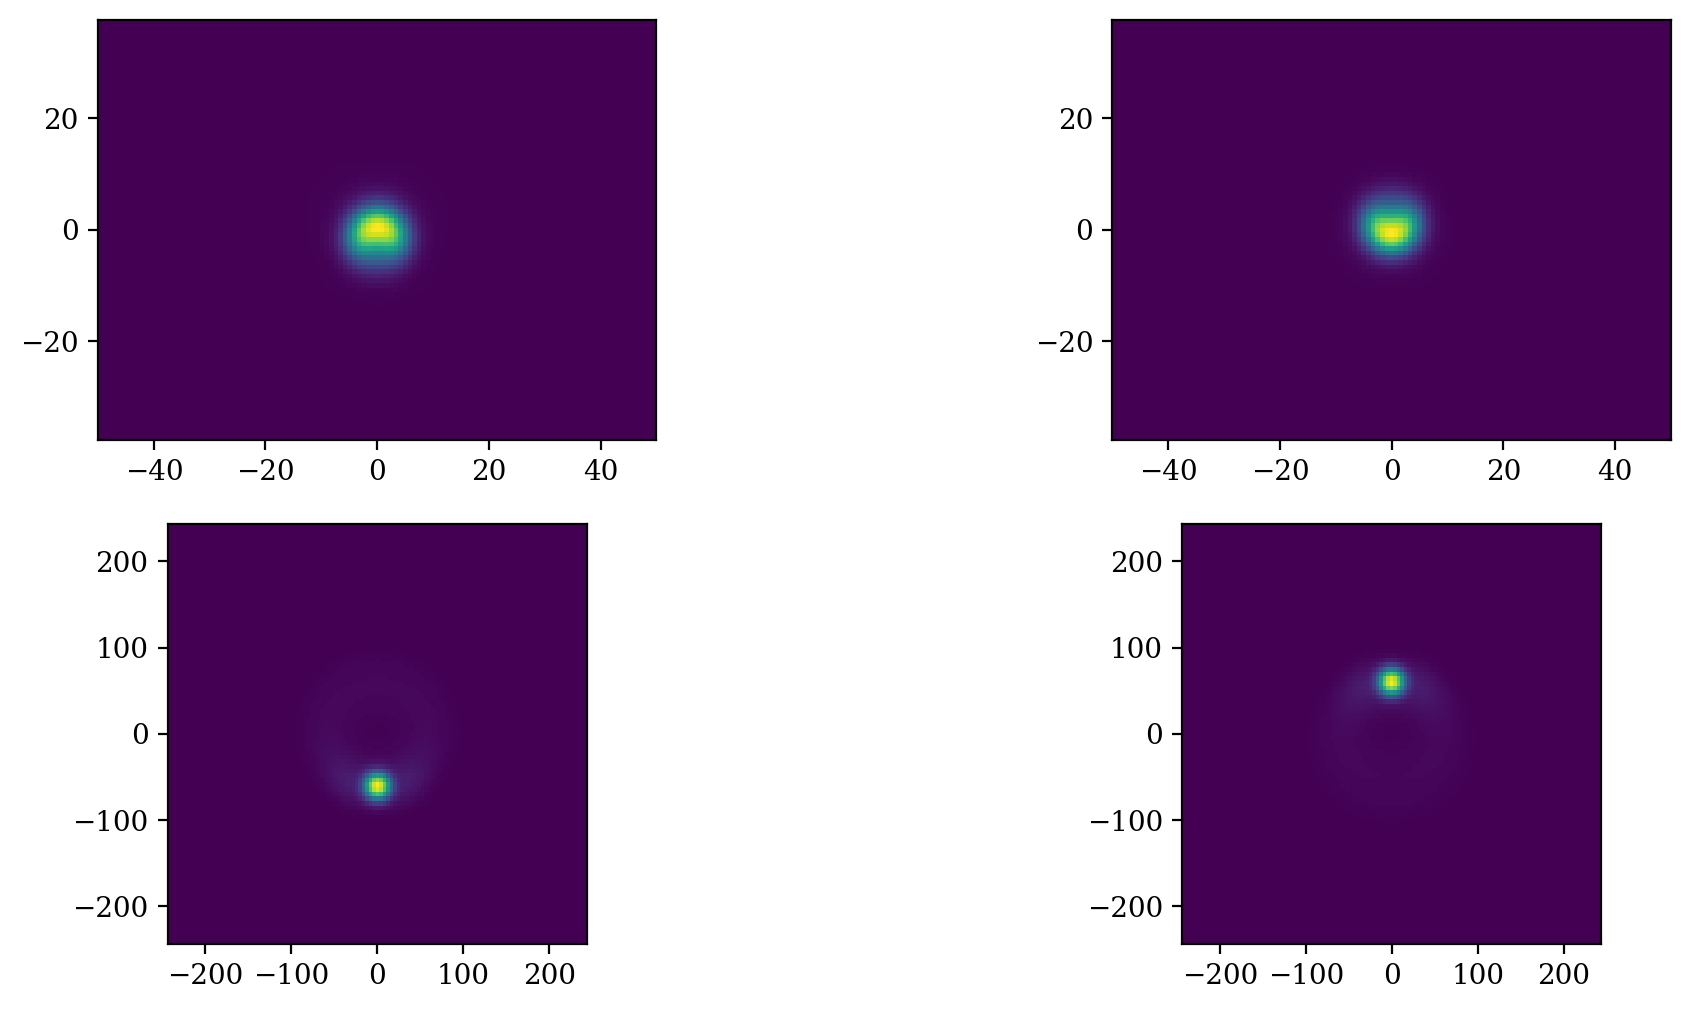

t = 0.225 		 frame = 9 		 memory used: 8083.145MB  


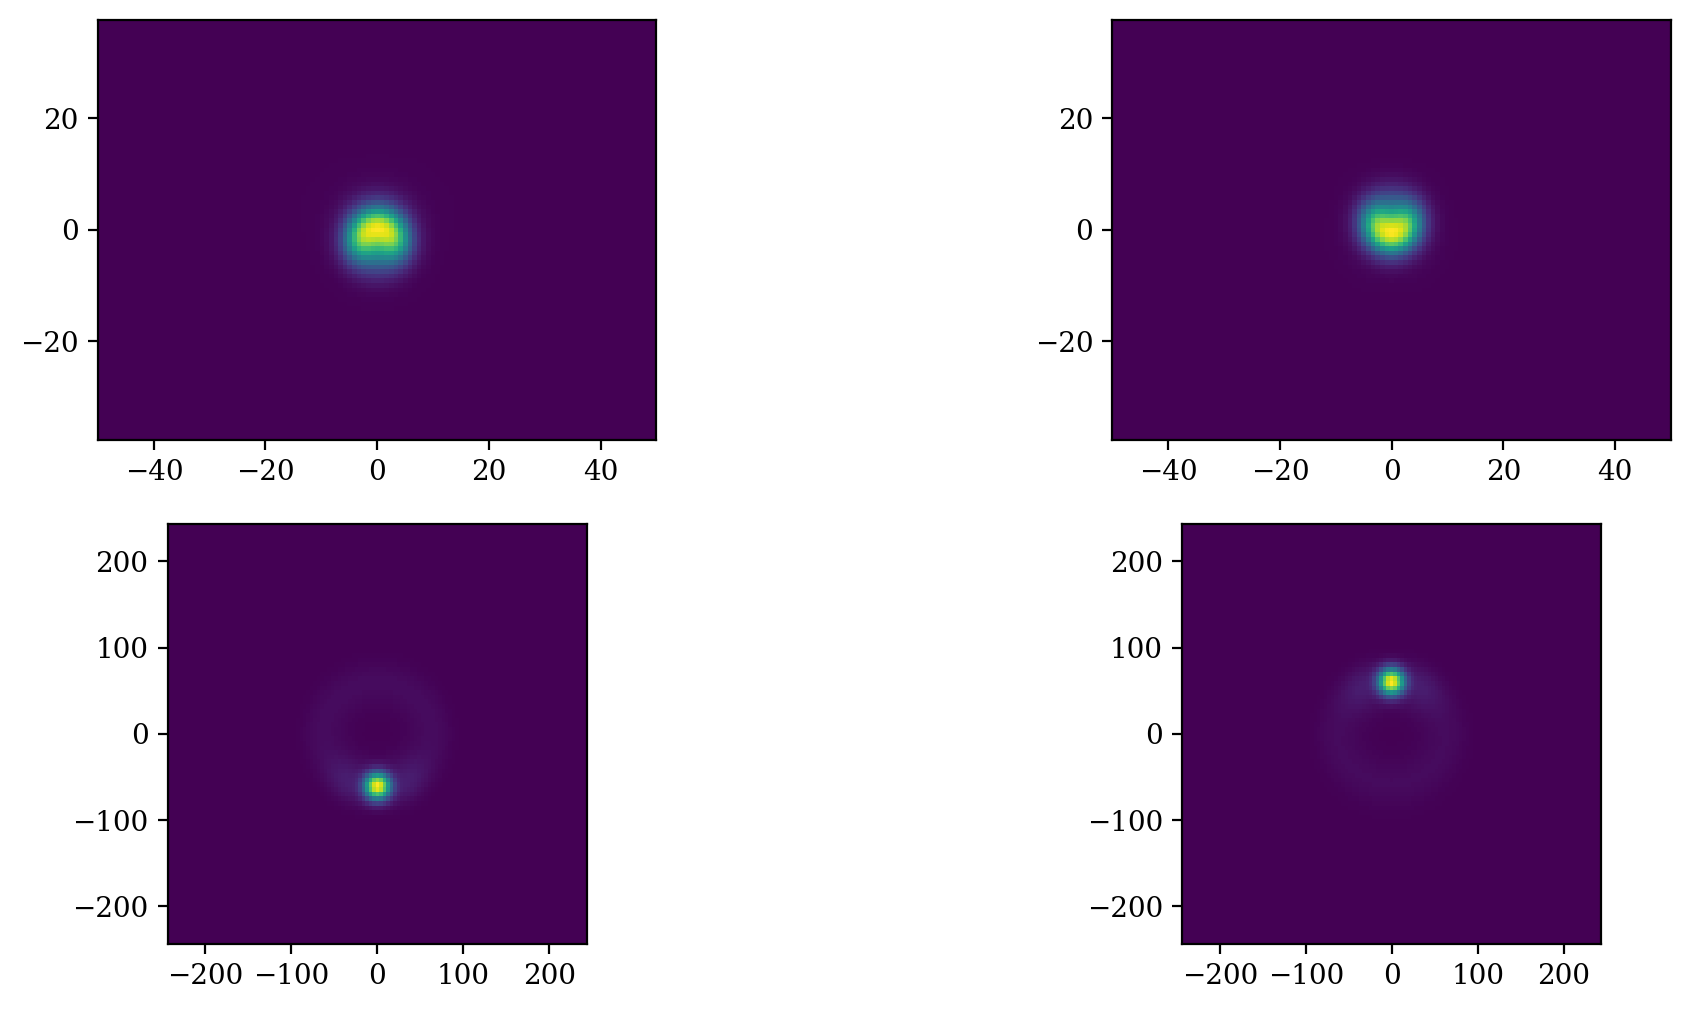

t = 0.25 		 frame = 10 		 memory used: 7861.518MB  


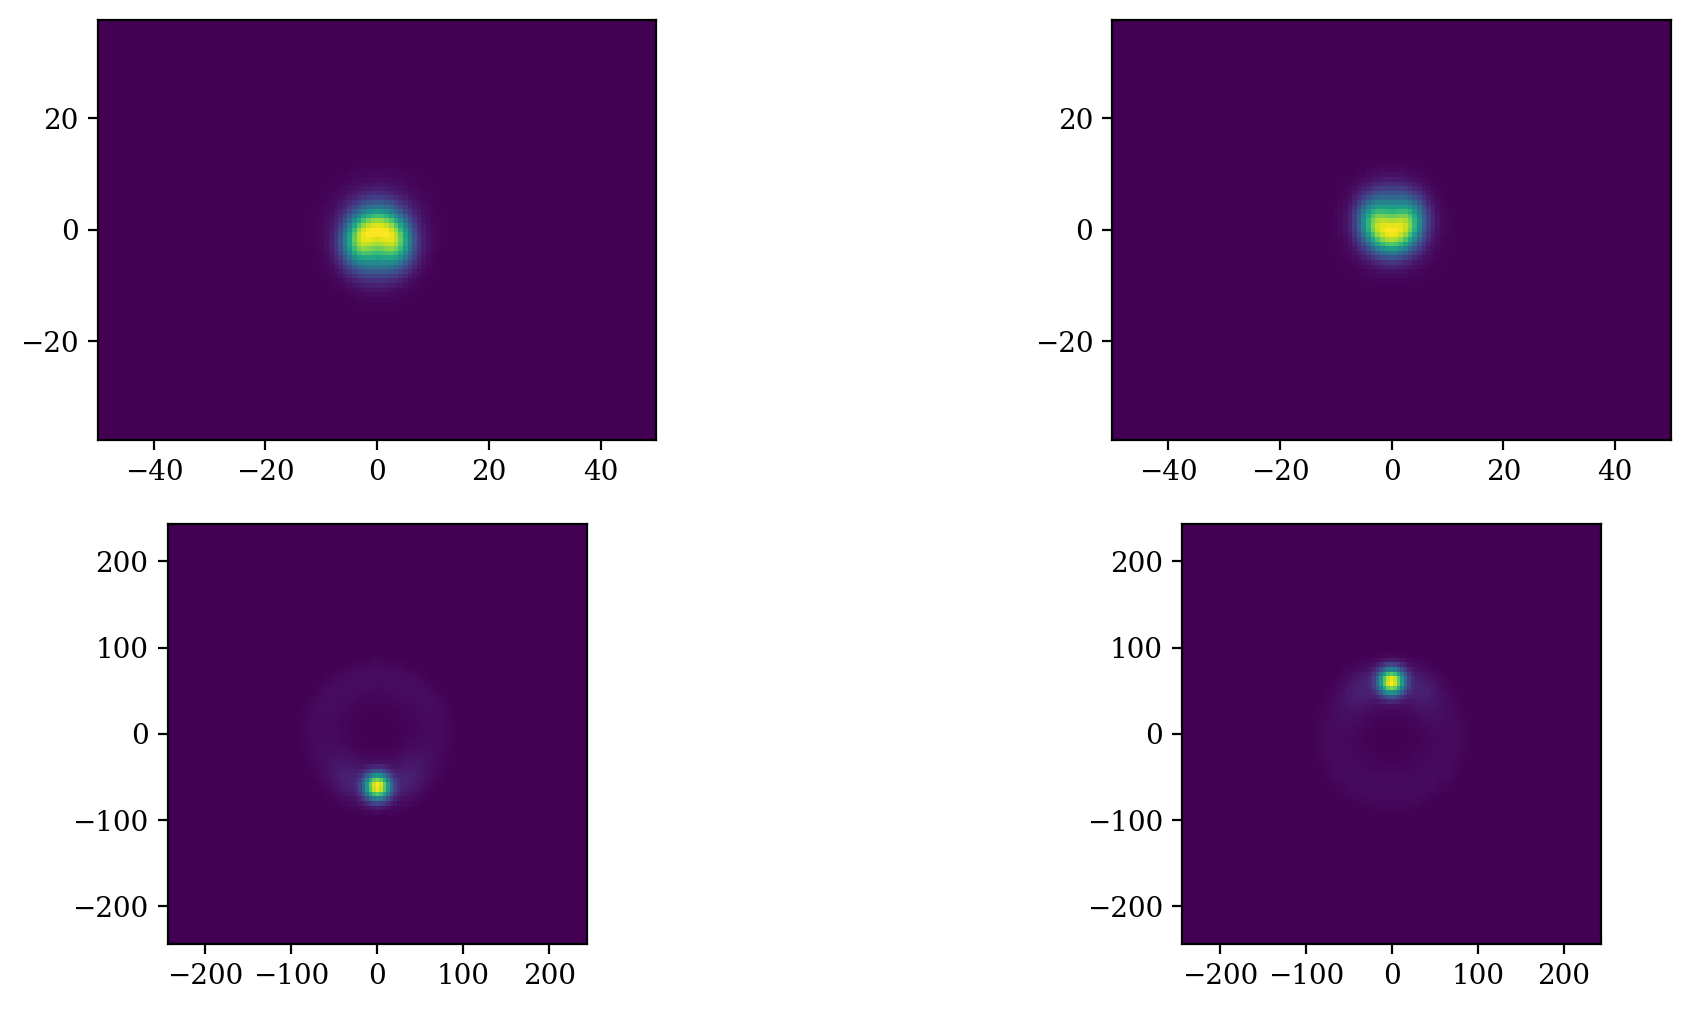

t = 0.275 		 frame = 11 		 memory used: 7925.596MB  


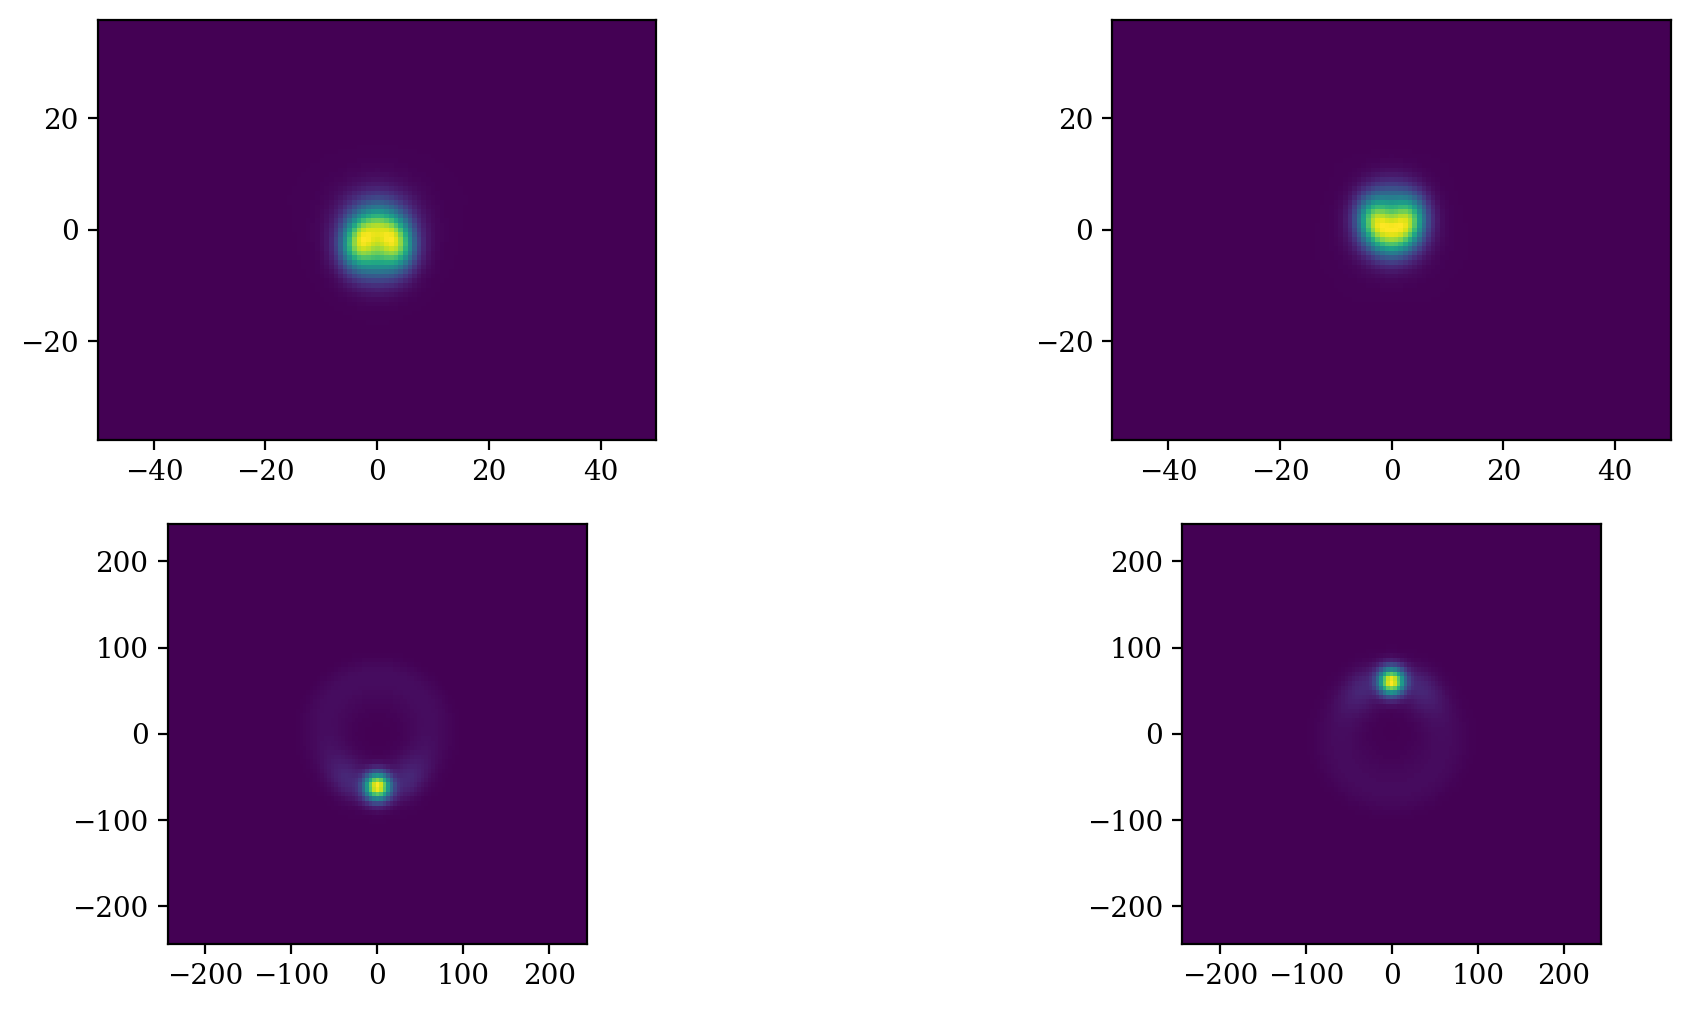

t = 0.3 		 frame = 12 		 memory used: 7931.118MB  


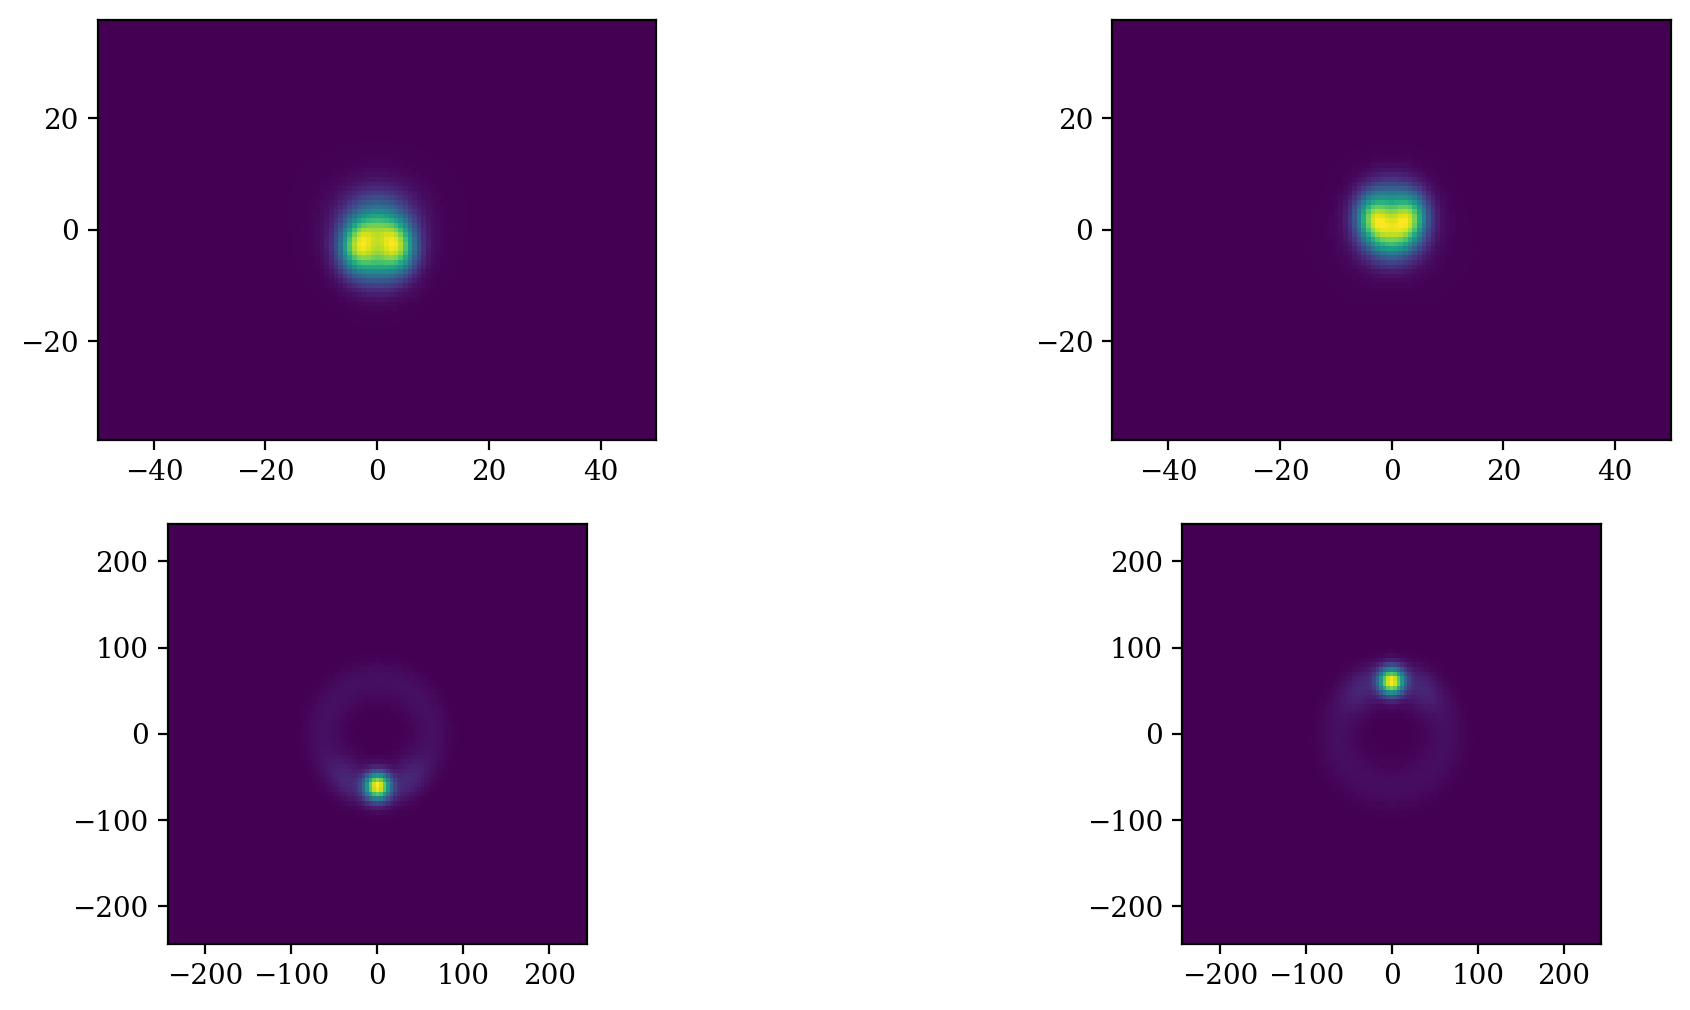

t = 0.325 		 frame = 13 		 memory used: 8003.551MB  


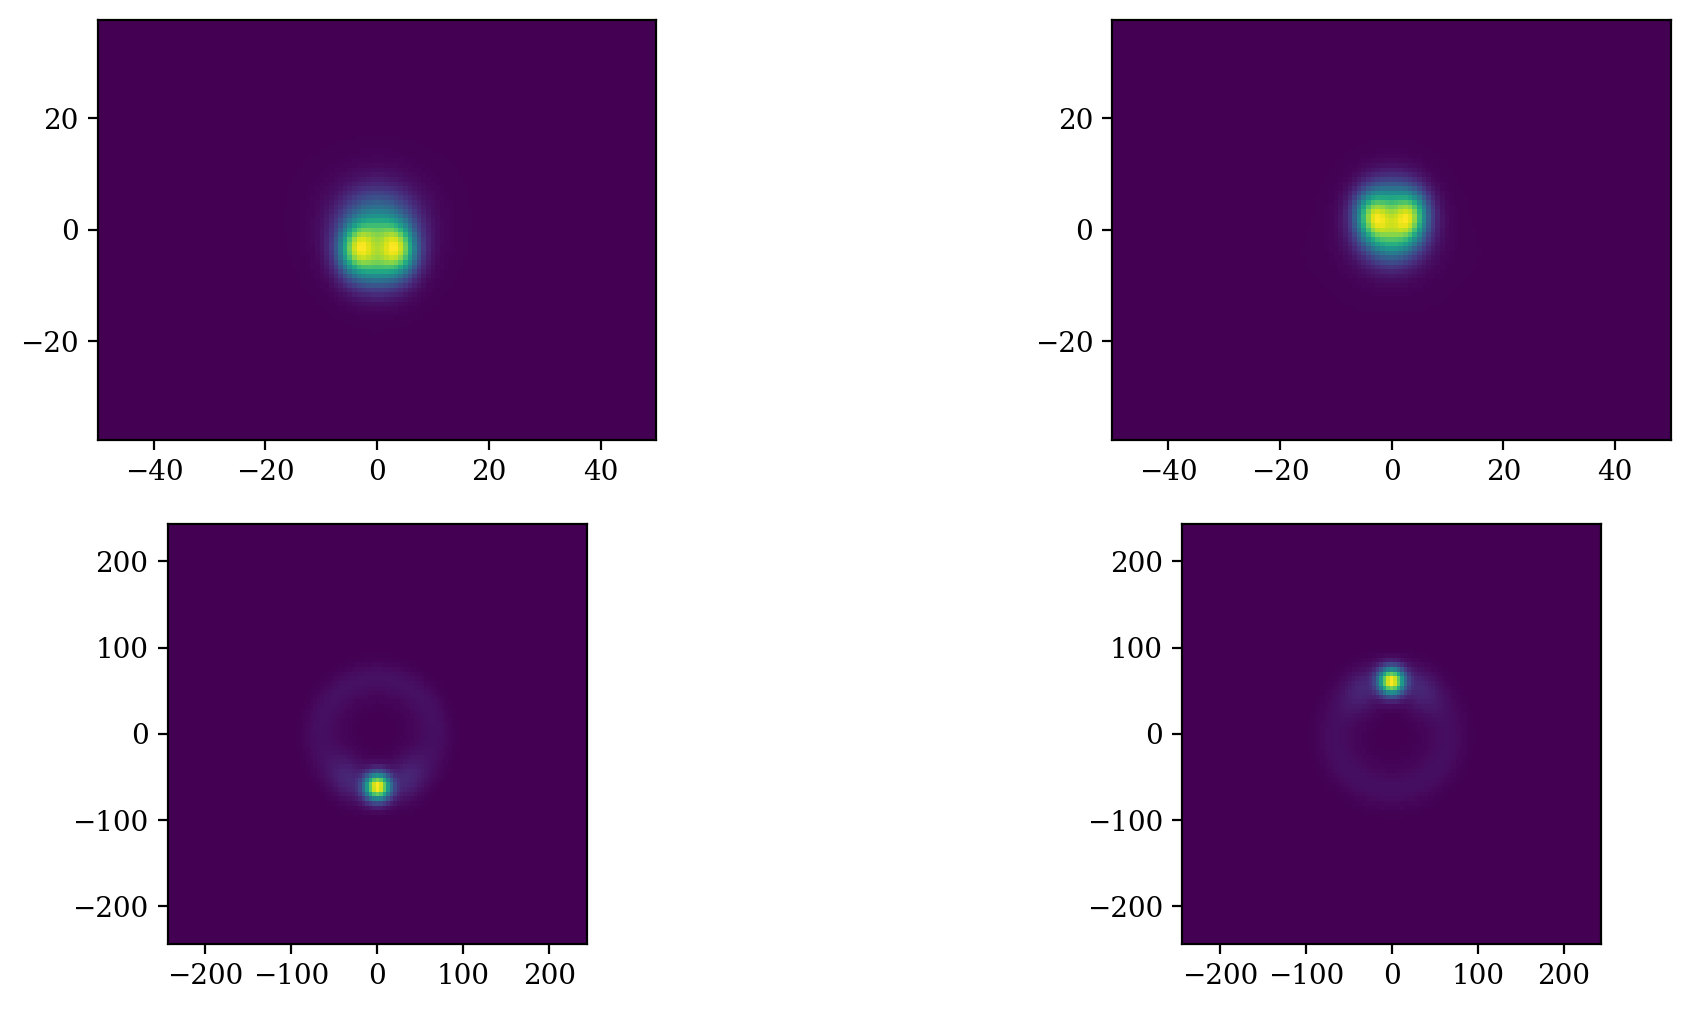

t = 0.35 		 frame = 14 		 memory used: 7935.459MB  


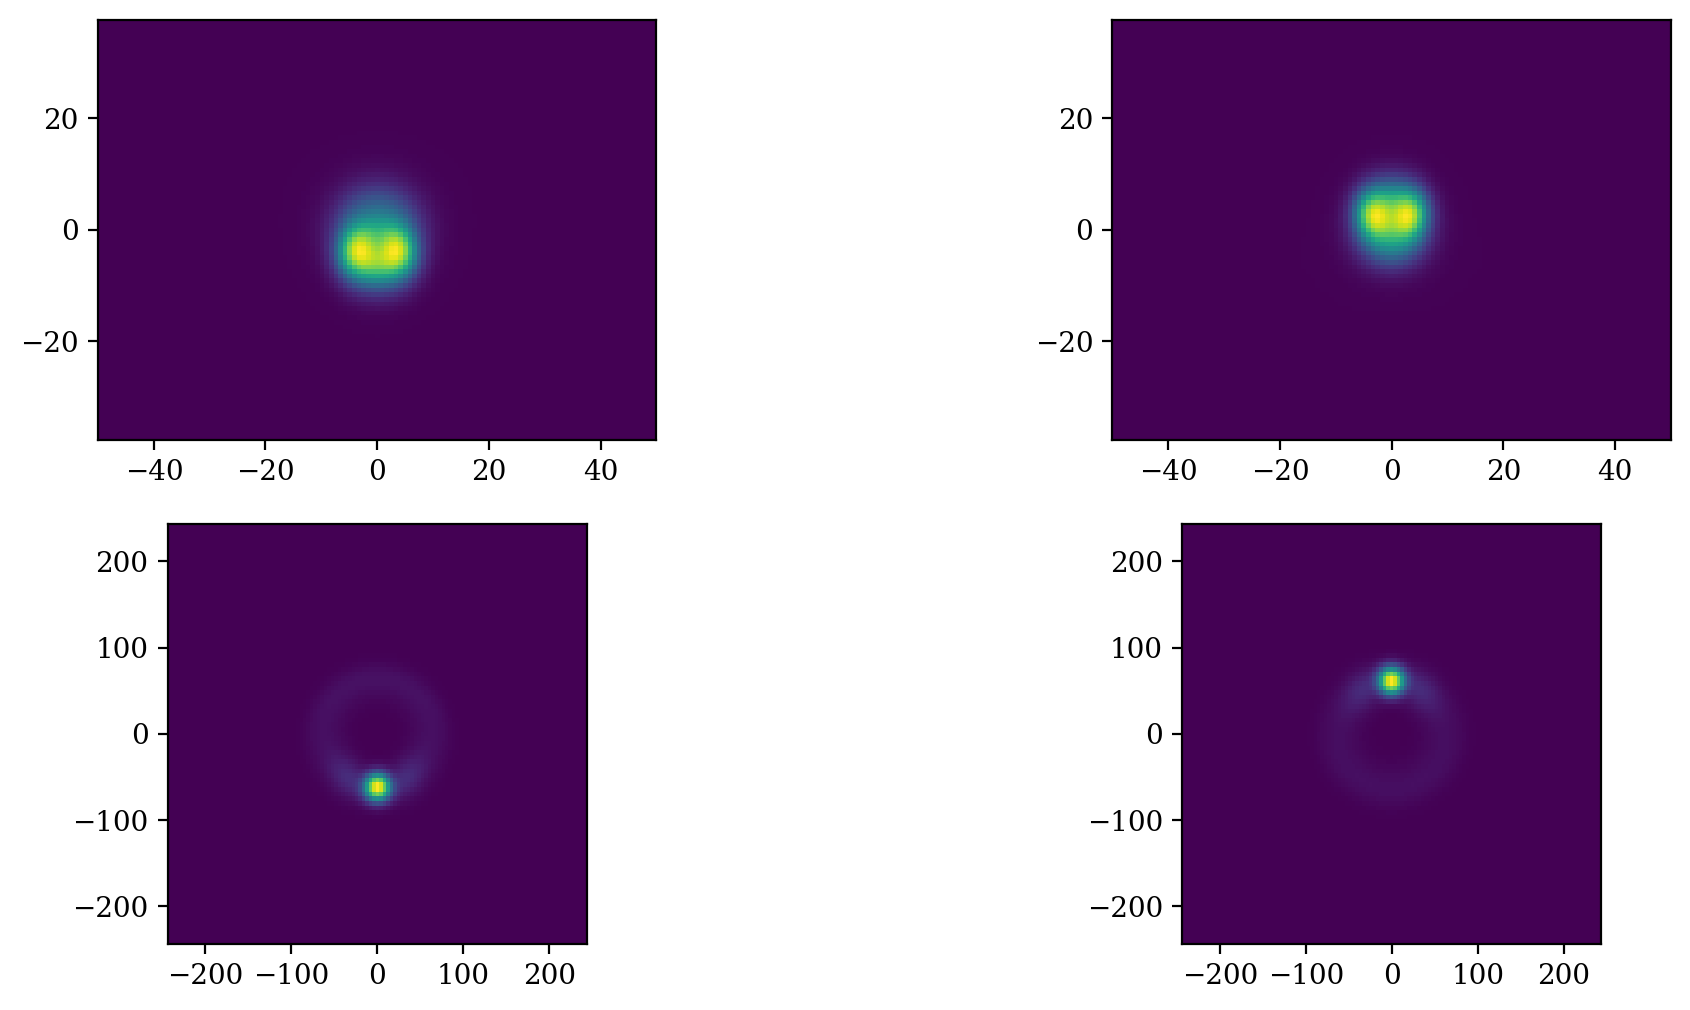

t = 0.375 		 frame = 15 		 memory used: 7931.625MB  


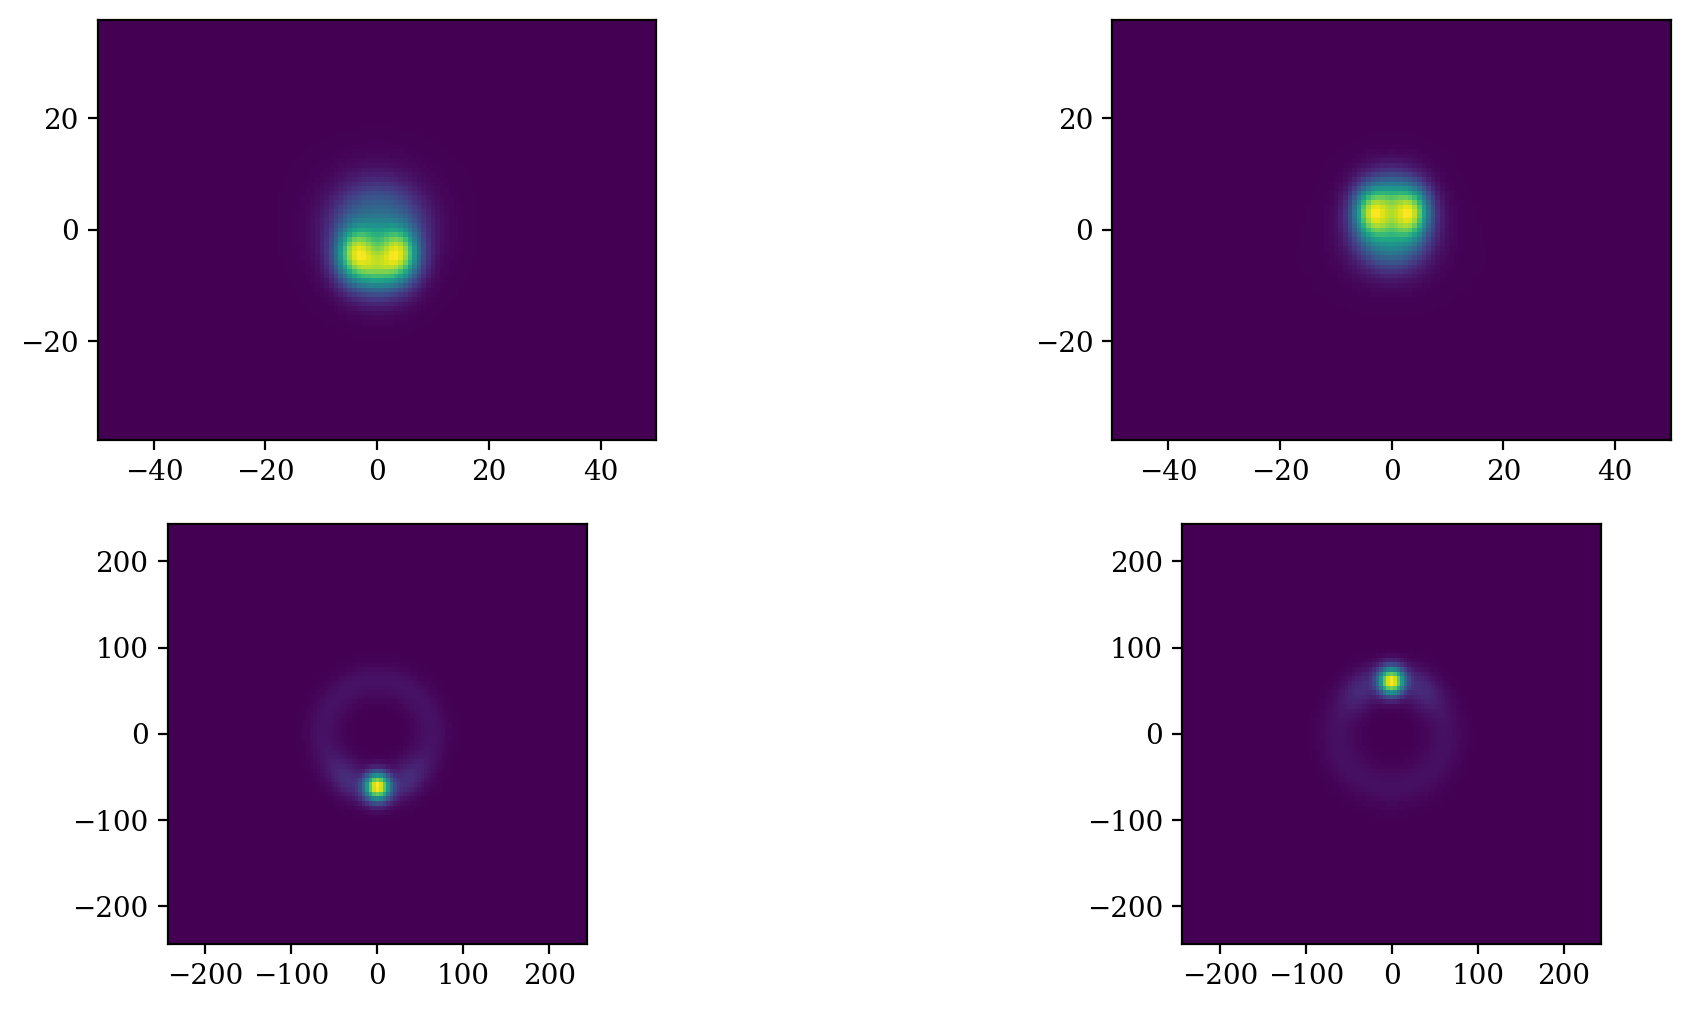

t = 0.4 		 frame = 16 		 memory used: 7942.128MB  


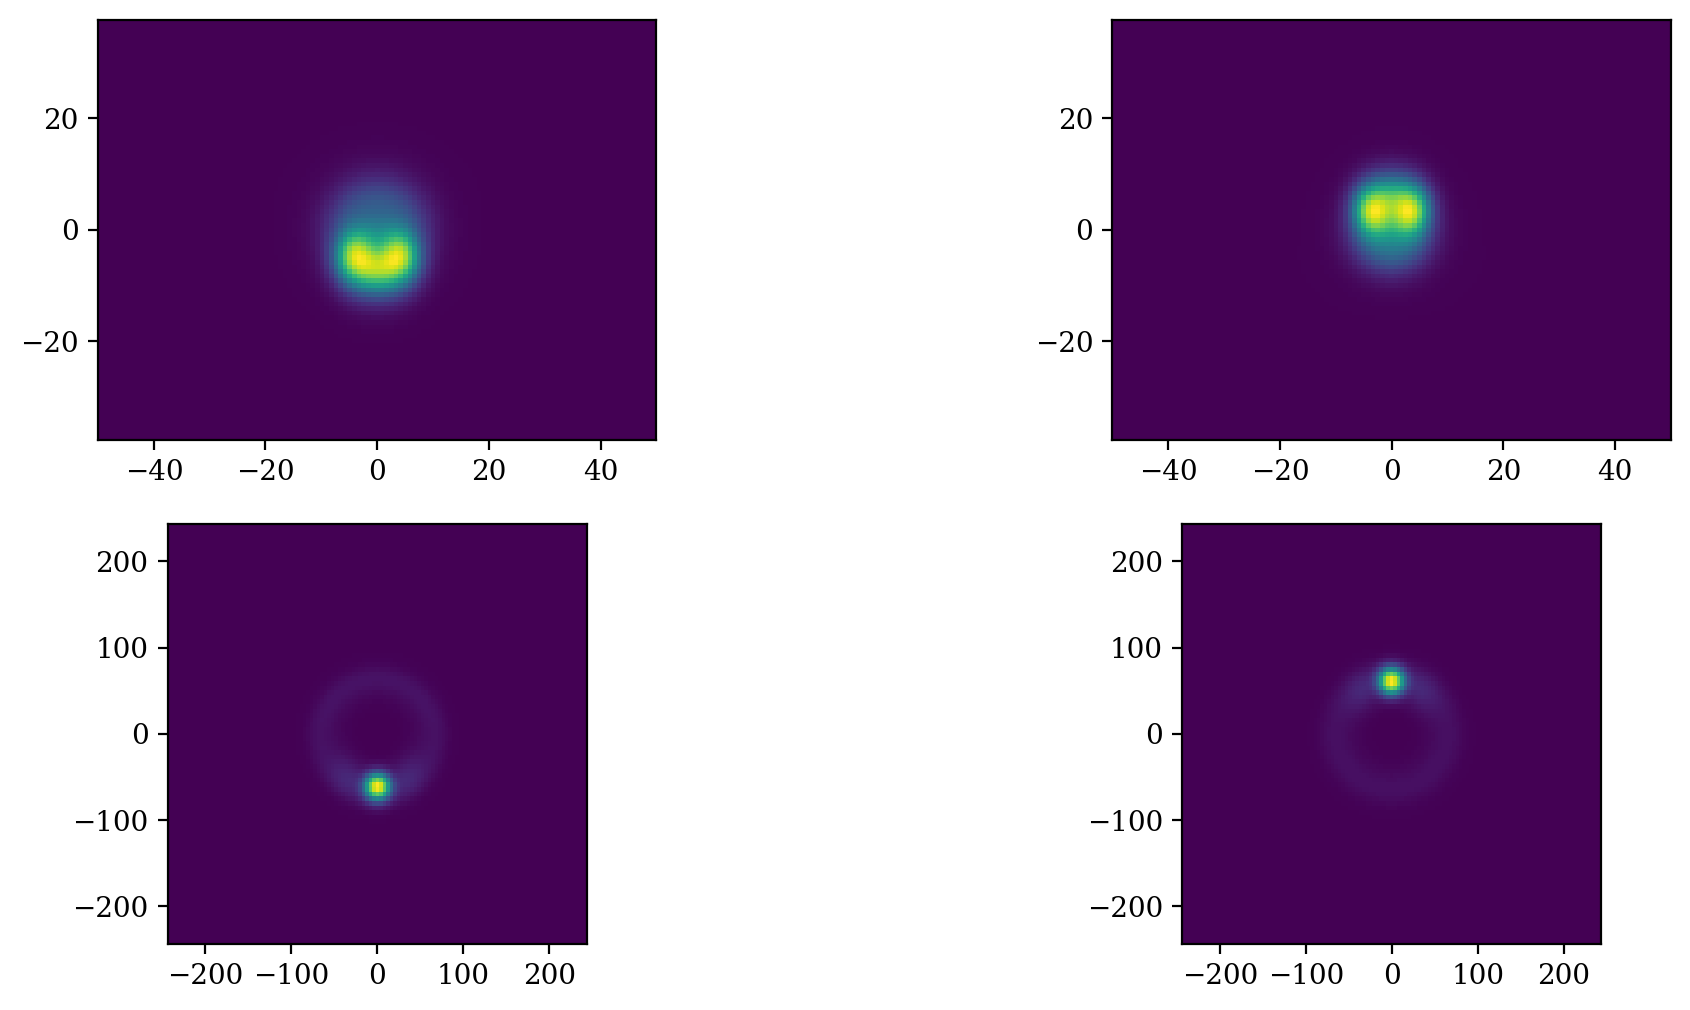

t = 0.425 		 frame = 17 		 memory used: 8034.435MB  


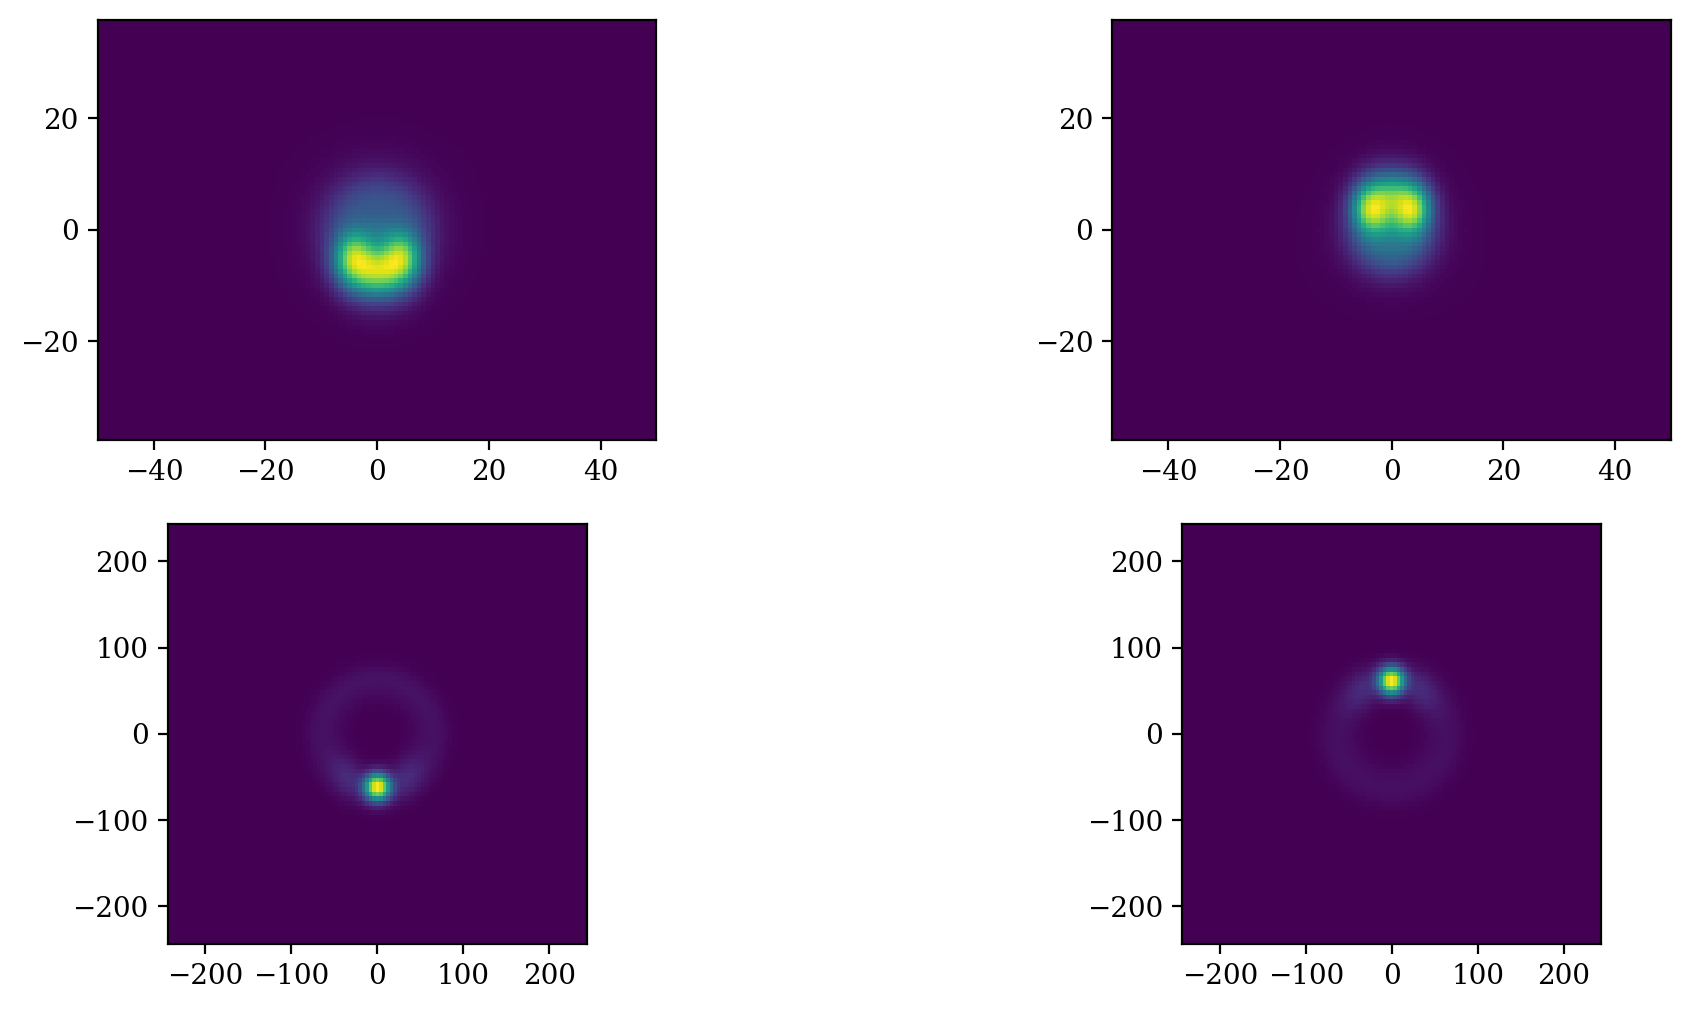

t = 0.45 		 frame = 18 		 memory used: 8092.418MB  


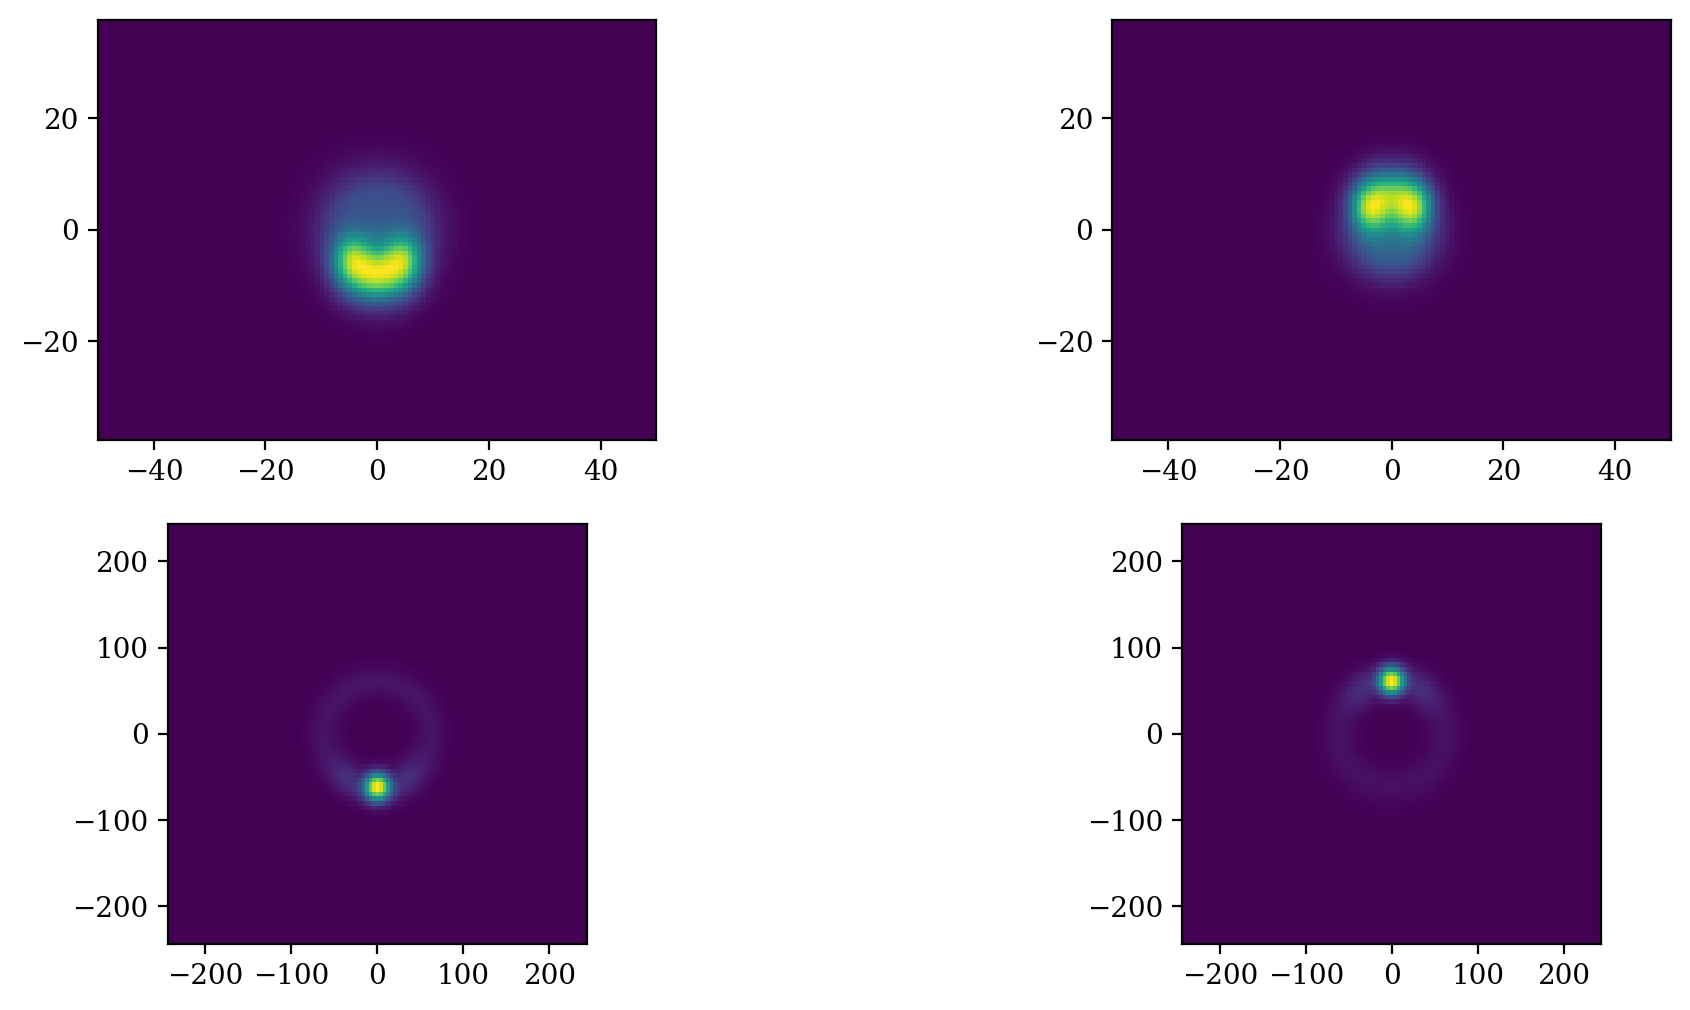

t = 0.475 		 frame = 19 		 memory used: 8164.131MB  


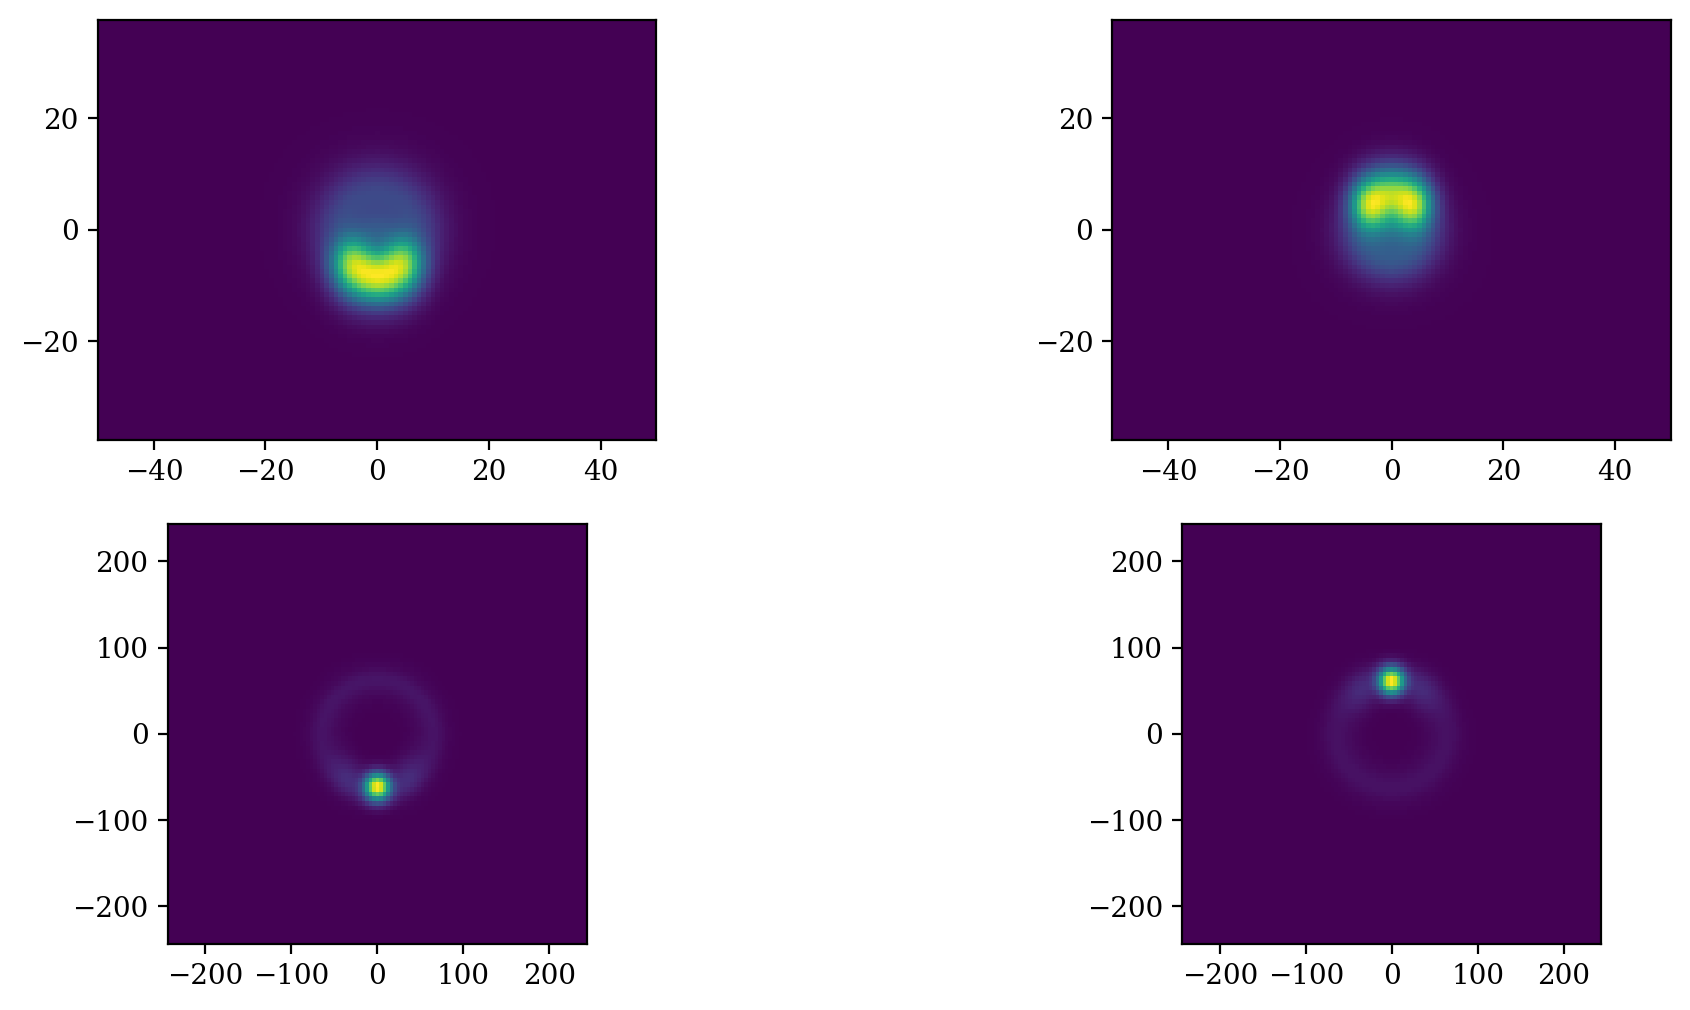

t = 0.5 		 frame = 19 		 memory used: 8210.645MB  


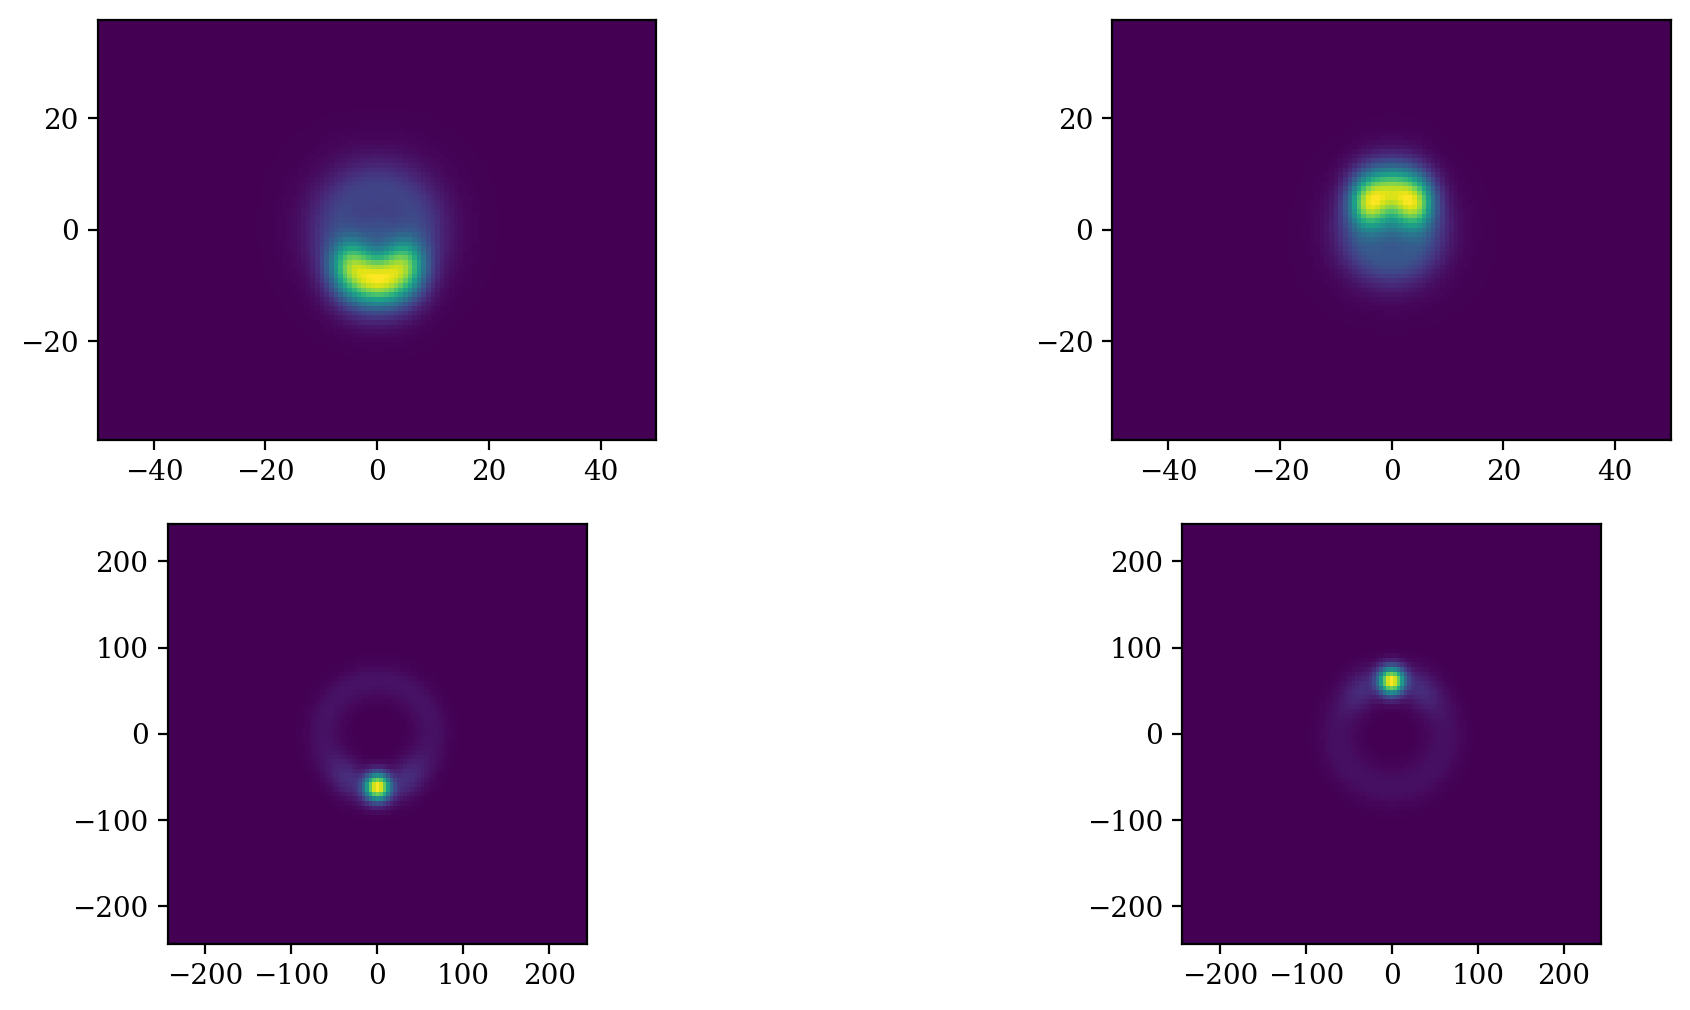

In [67]:
su = 4
psi = psi0_just_opposite(dr=5,s3=su,s4=su,pt=-2*hb*k,a=0.5*pi)
t = 0
phi, swnf = phiAndSWNF(psi)

def scattering_evolve_loop_plot():
    print("t =", round(t,5), "\t\t frame =", f, "\t\t memory used: " + 
              str(round(current_py_memory()/1000**2,3)) + "MB  ")

    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,2)
    plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,3)
    plt.imshow((only3phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
    # plt.colorbar()

    plt.subplot(2,2,4)
    plt.imshow((only4phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
    # plt.colorbar()

    plt.show()


with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot()
        (t,psi,phi) = scattering_evolve_loop_helper(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot()

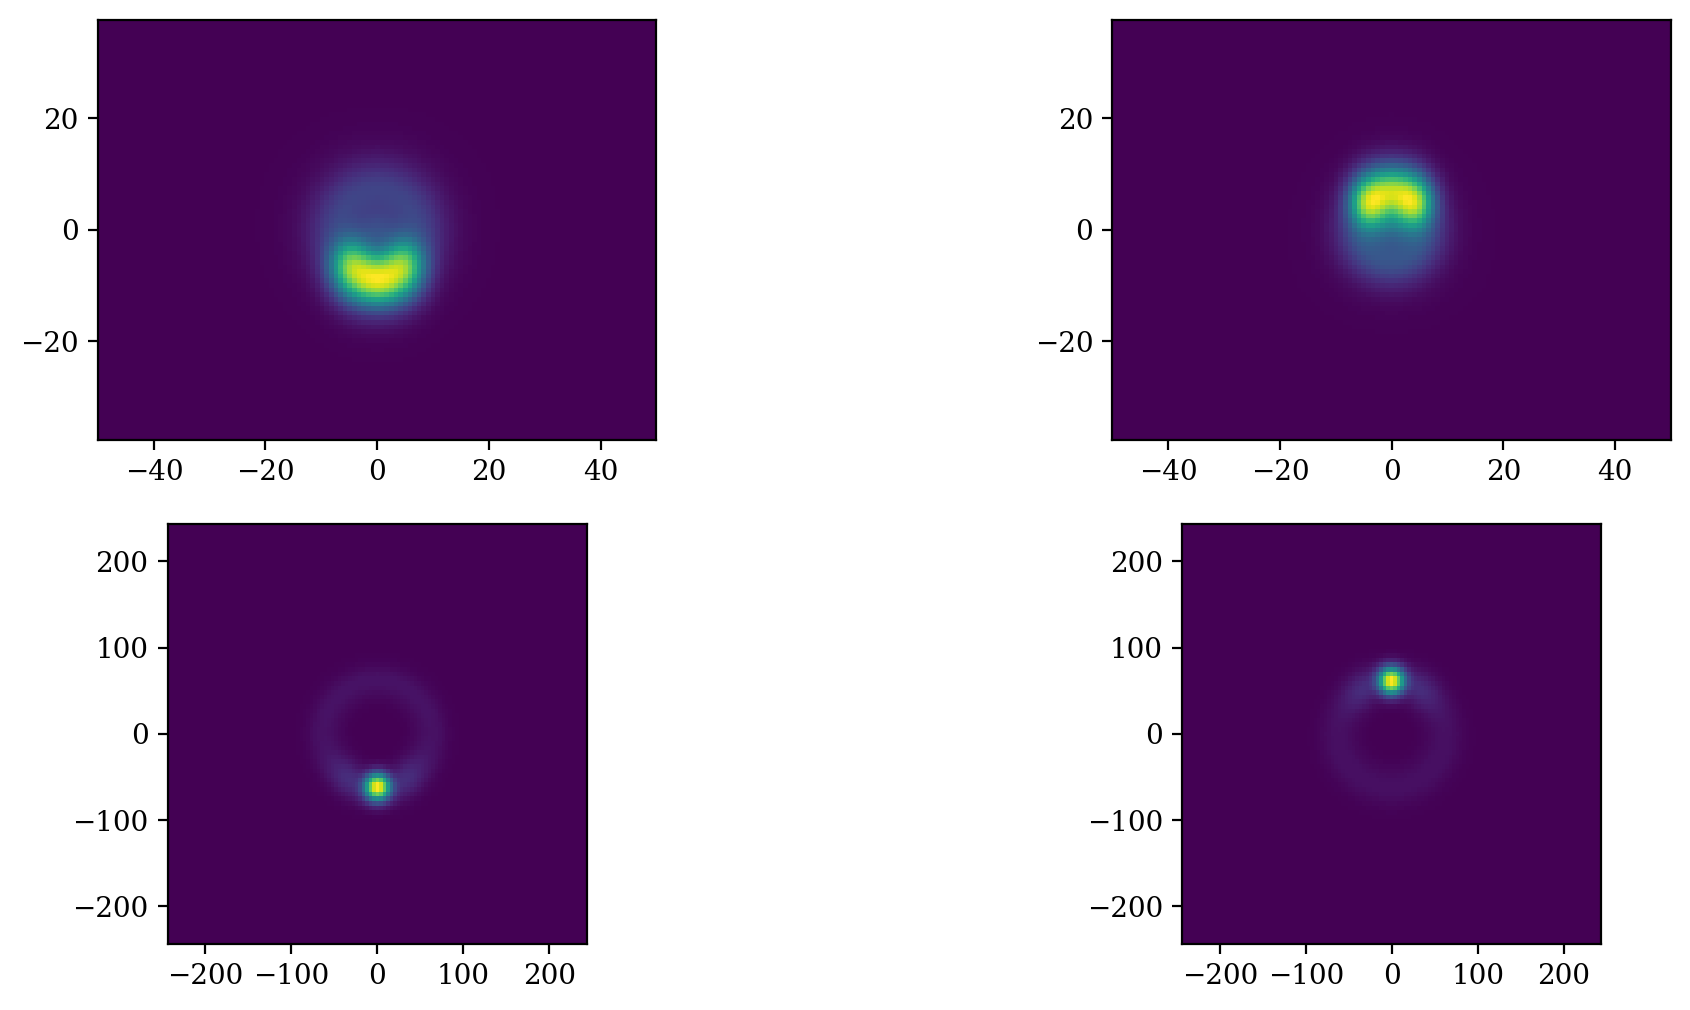

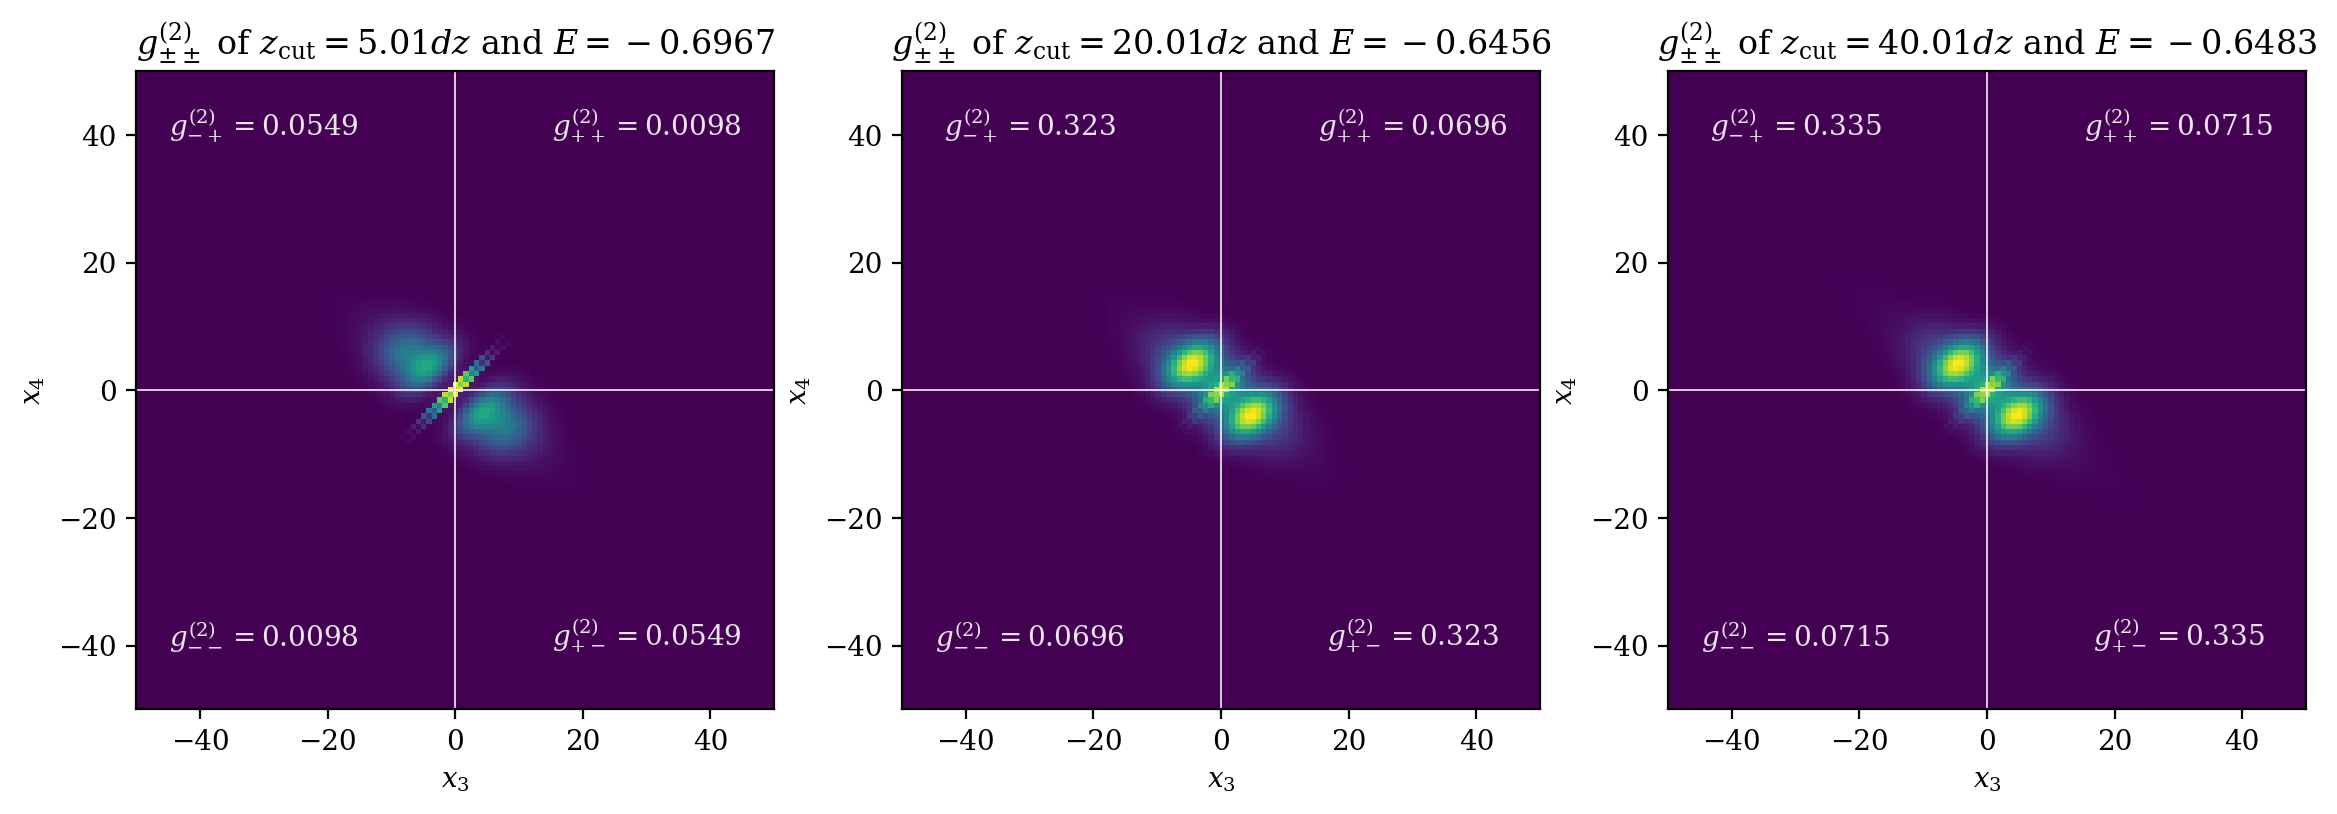

  0%|                                                                                                         …

t = 0.5 		 frame = 0 		 memory used: 9964.093MB  


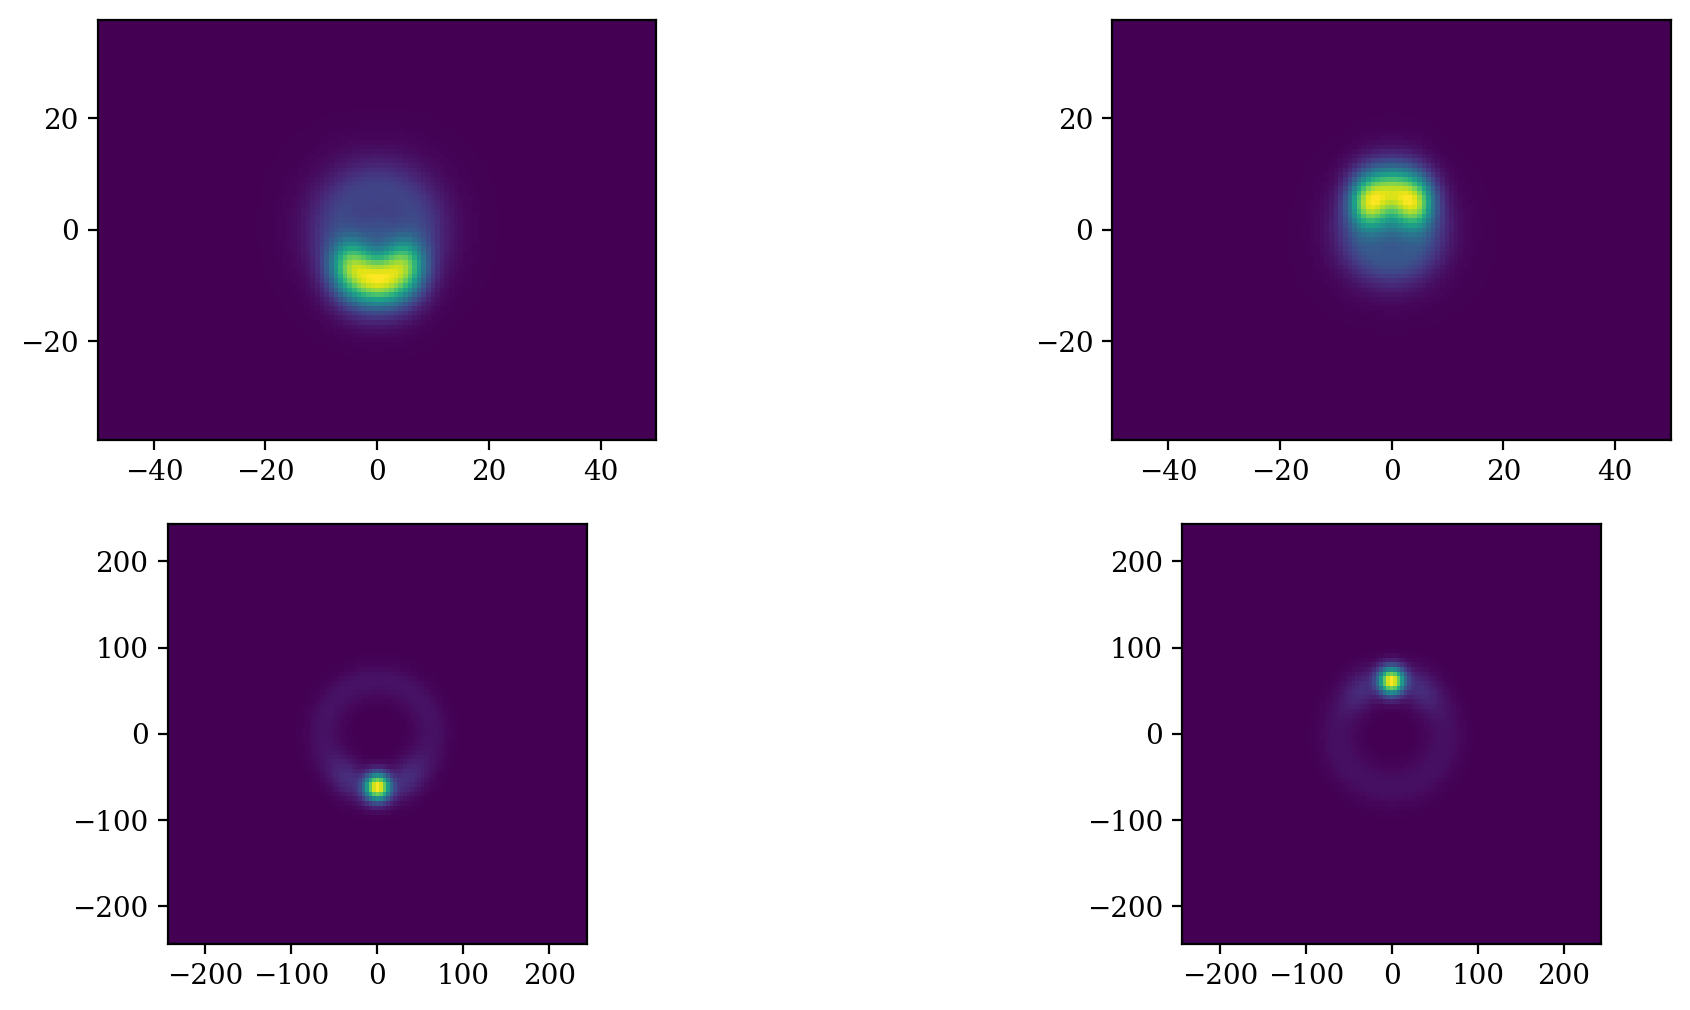

t = 0.525 		 frame = 1 		 memory used: 9964.192MB  


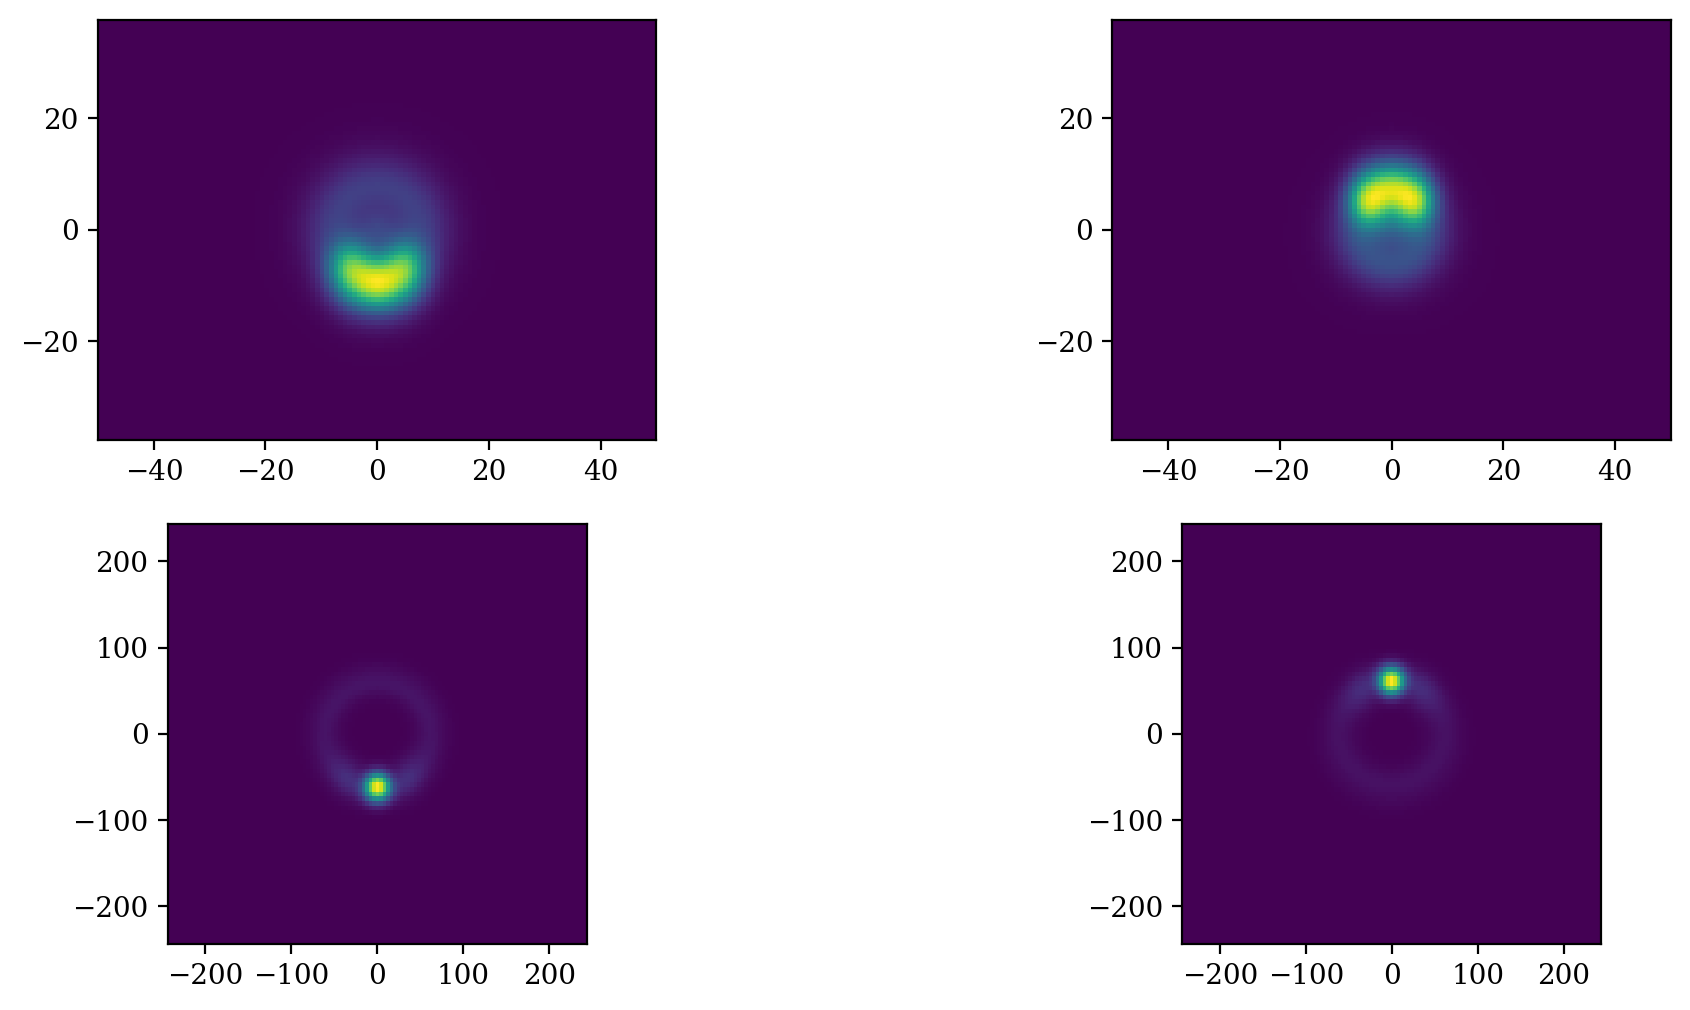

t = 0.55 		 frame = 2 		 memory used: 9971.696MB  


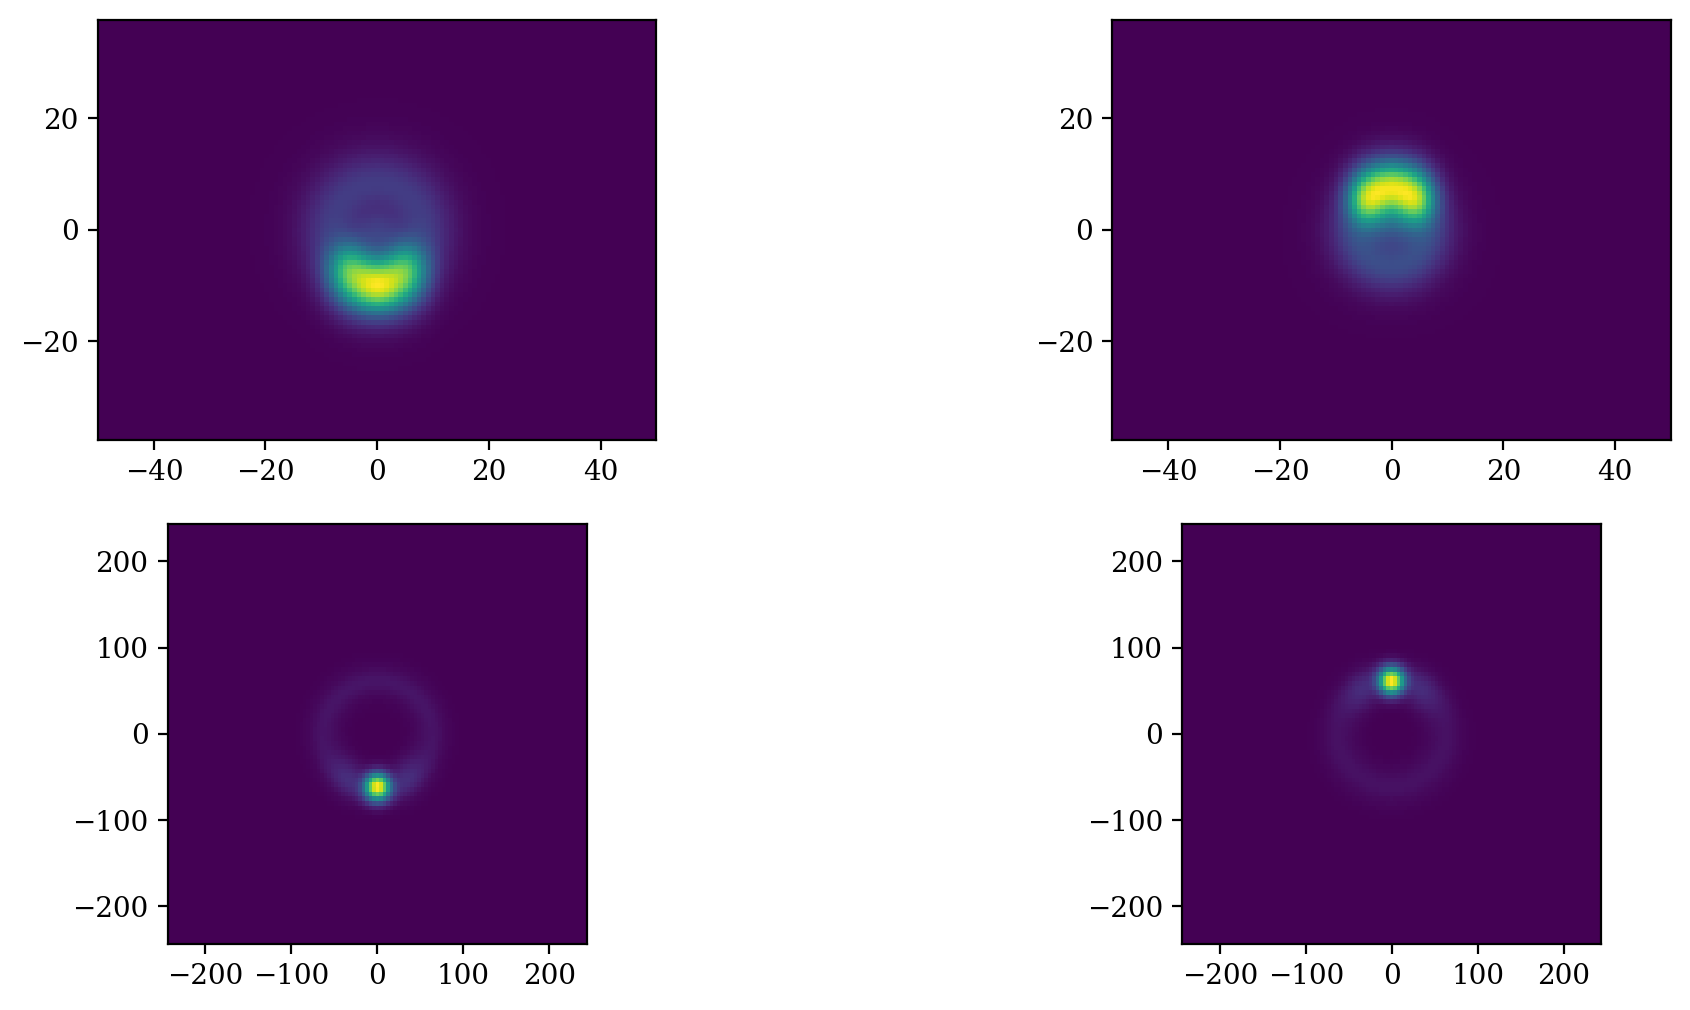

t = 0.575 		 frame = 3 		 memory used: 9971.827MB  


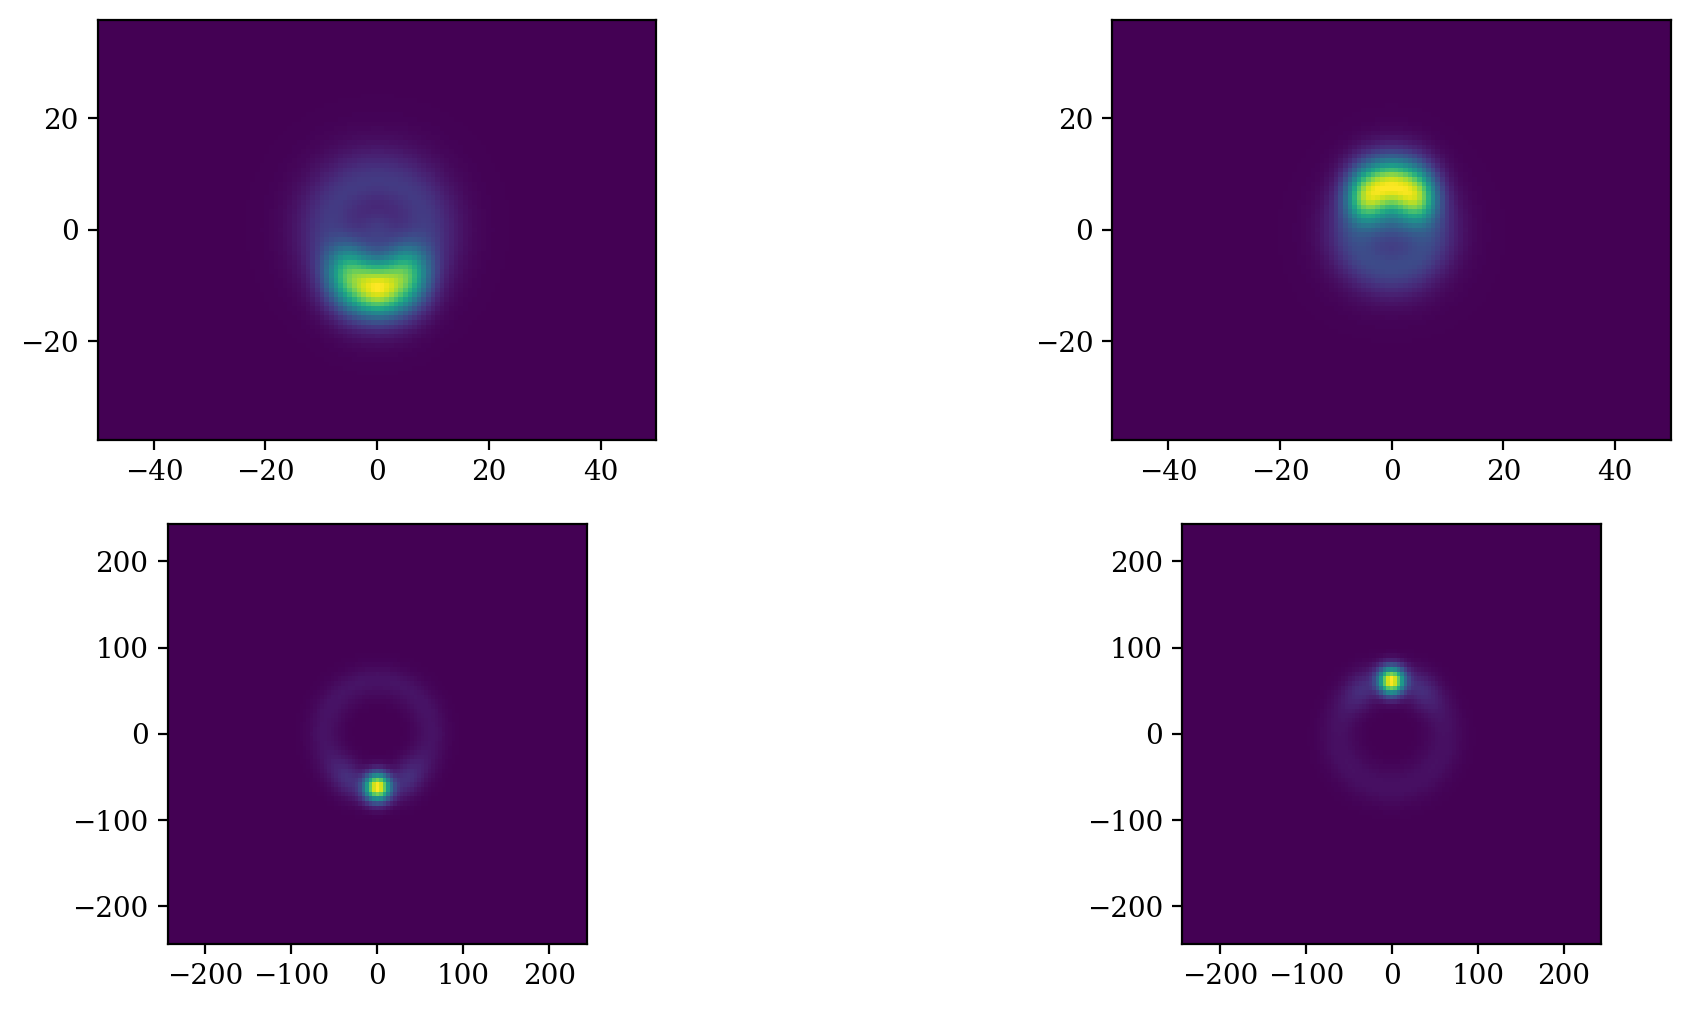

In [ ]:
with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot()
        (t,psi,phi) = scattering_evolve_loop_helper(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot()

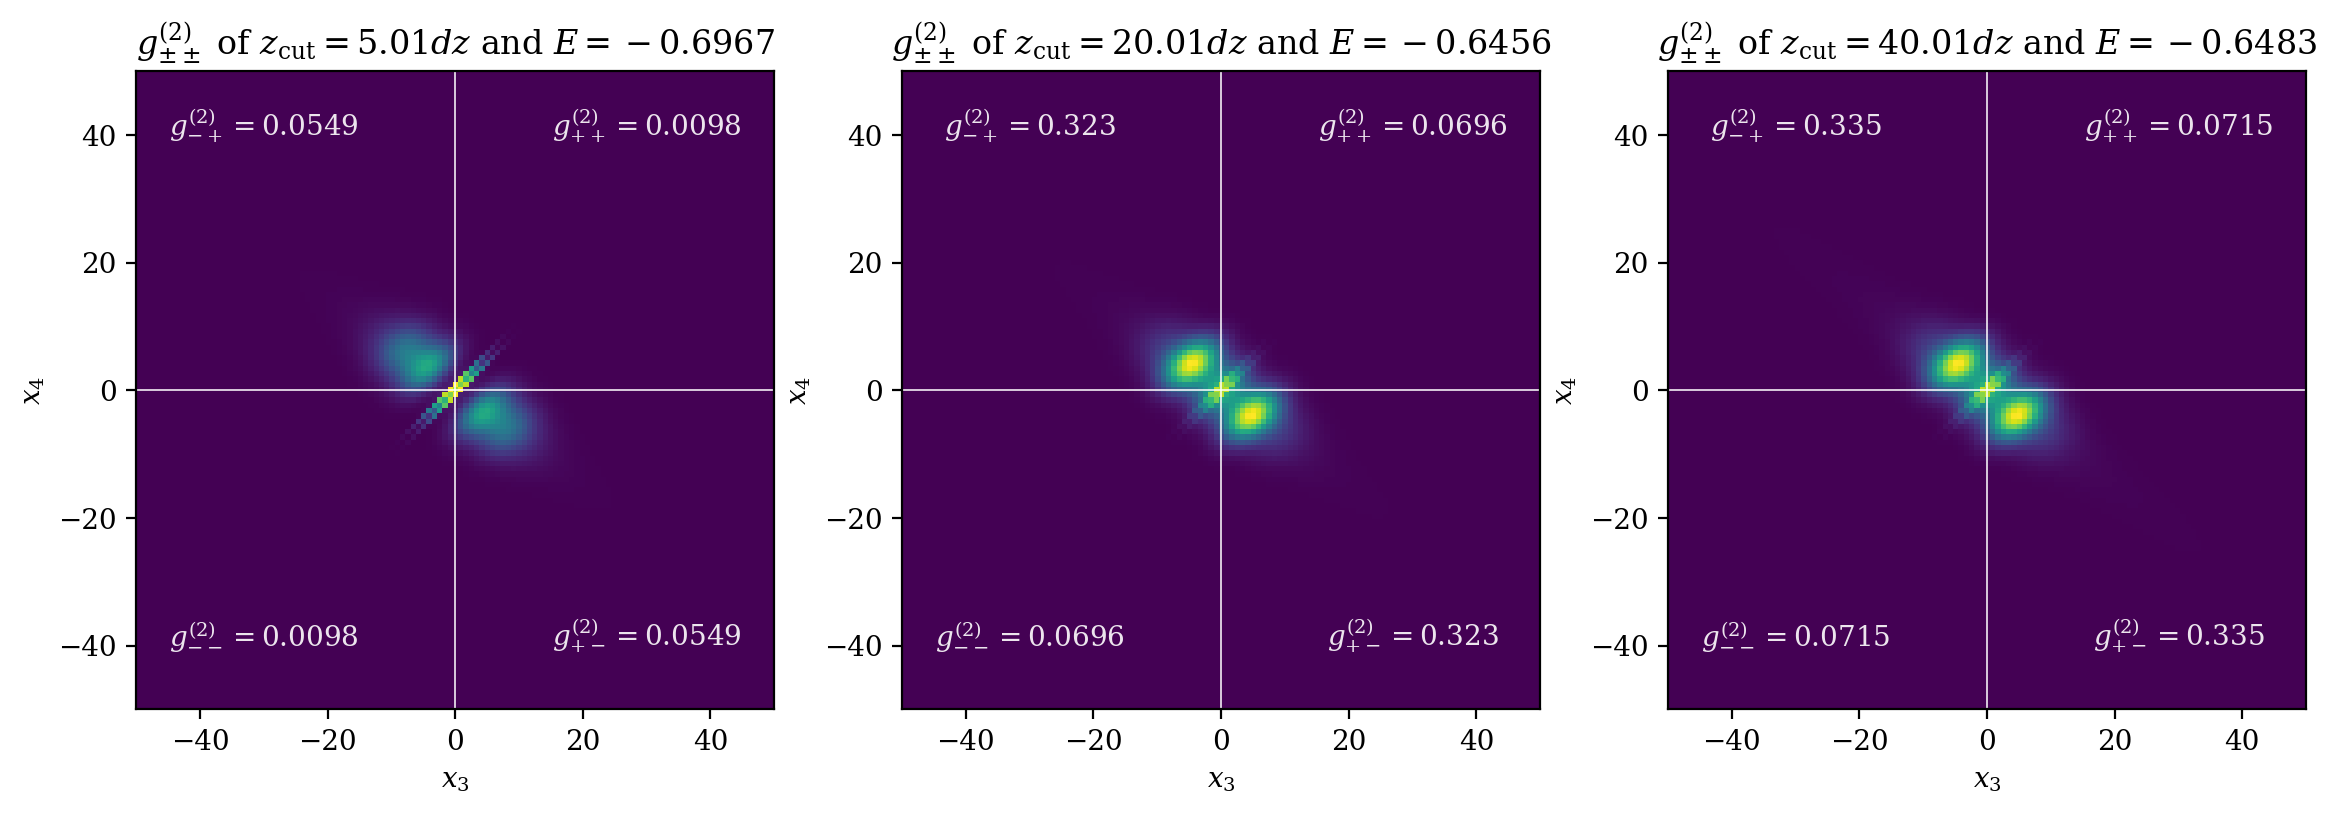

In [71]:
plt.figure(figsize=(14,6))

cut_list = [5.01, 20.01, 40.01]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()

In [ ]:
gx3x4 = gx3x4_calc(psi,cut=cut)
plt.subplot(1,3,i+1)
plot_gx3x4(gx3x4,cut)
plt.show()

## Bragg Time Evolution Operator

In [40]:
def numericalEvolve_plotHelper(t, psi, phi):
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,2)
    plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,3)
    plt.imshow(np.flipud(only3phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.subplot(2,2,4)
    plt.imshow(np.flipud(only4phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.show()

def numericalEvolve(
        t_init, 
        psi_init, 
        t_final, 
        tPi  = tBraggPi, 
        tMid = tBraggPi*5, 
        V0FArg=V0F,
        phase  = 0,
        doppd=dopd,
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True, 
    ):
    assert (print_every_t >= dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    t = t_init
    psi = psi_init.copy()
    del psi_init
#     psi = psi_init
    (phi, swnf) = phiAndSWNF(psi)

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        Vx3ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x3grid + doppd*(t-tMid) + phase) )
        Vx4ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x4grid + doppd*(t-tMid) + phase) )
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        phi = toPhi(psi,swnf)
        phi *= expP3Grid
        phi *= expP4Grid
        psi = toPsi(phi,swnf)
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
            print("finished step =", step, "\t memory used: " + 
                  str(round(current_py_memory()/1000**2,3)) + "MB  ", end='\r');
            if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
                numericalEvolve_plotHelper(t, psi, phi)
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        numericalEvolve_plotHelper(t, psi, phi)
    return (t,psi,phi)

In [31]:
su = 5
(t_try1, psi_try1, phi_try1) = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=0, pz3=0, px4=0, pz4=0), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=1*V0F, phase=0, doppd=-10*dopd, 
                print_every_t=0*dt, final_plot=False, progress_bar=True)

NameError: name 'numericalEvolve' is not defined

Notes

`V0FArg=1*V0F, phase=0, doppd=-10*dopd` doesn't quite work with `tauPi = 0.0039`

`V0FArg=2*V0F, phase=0, doppd=-10*dopd` worked ish

`V0FArg=3*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=4*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=10*V0F, phase=0, doppd=-10*dopd` might be too fast

The problem with these are they don't have transfers

then I realised I set the doppler frequency different incorrectly ....

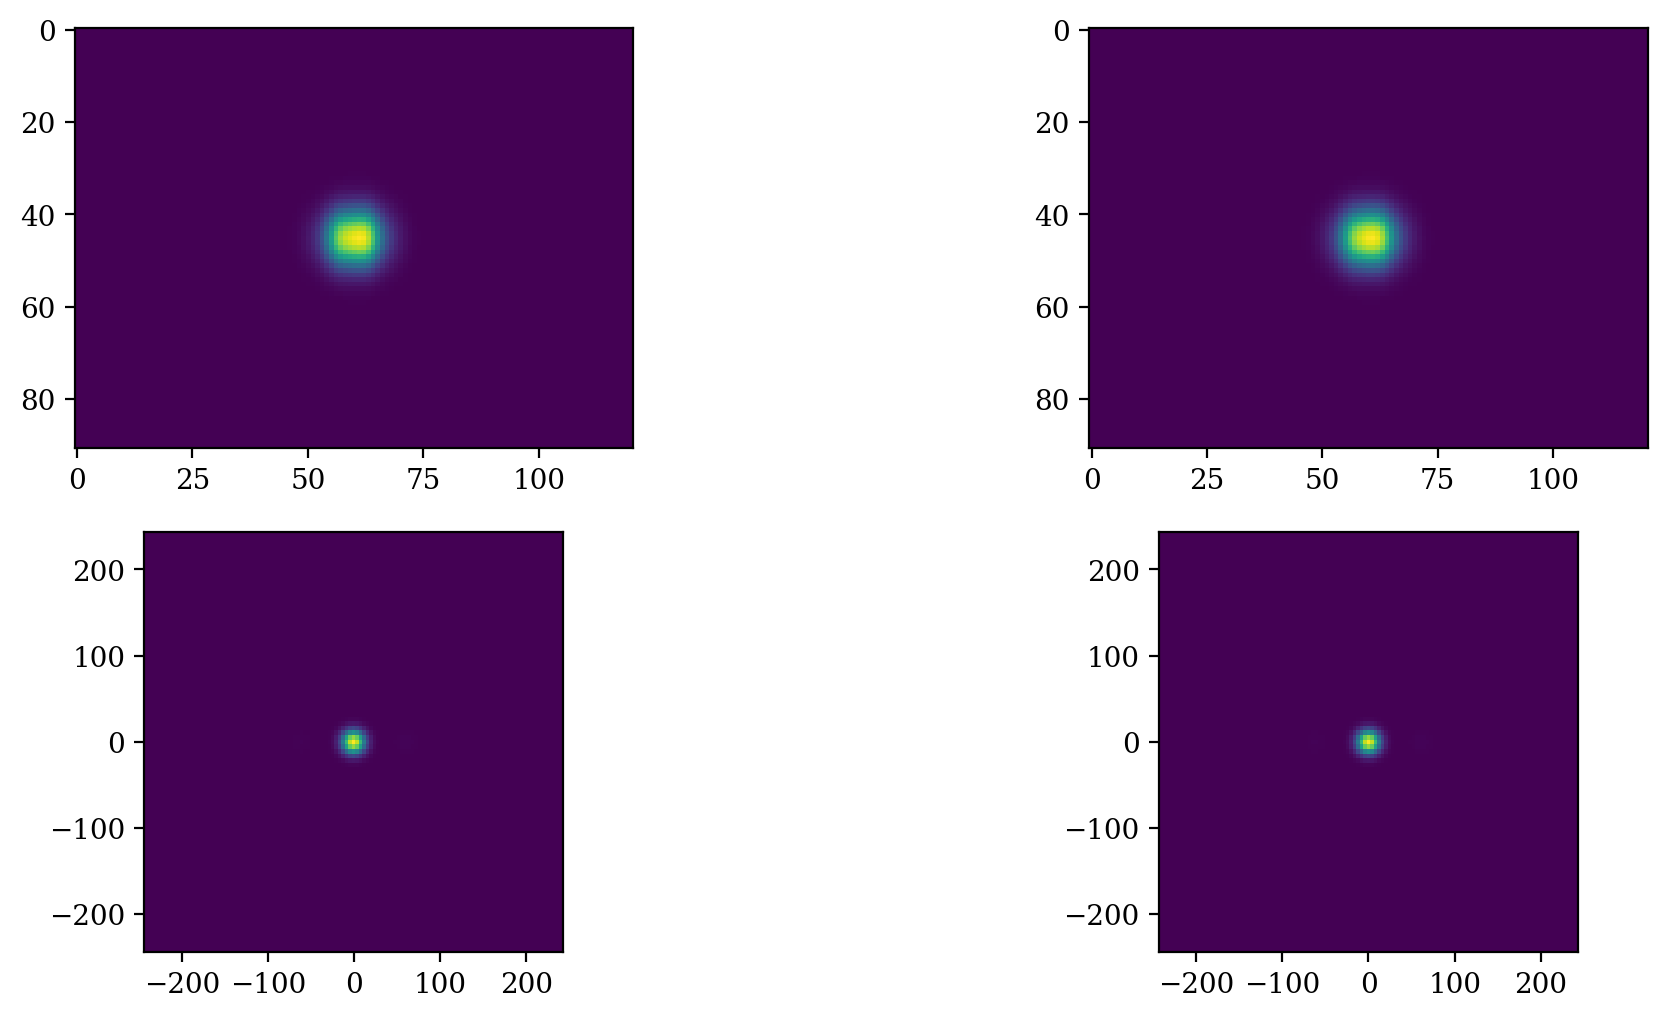

In [37]:
numericalEvolve_plotHelper(t_try1, psi_try1, phi_try1)

In [32]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
# cut_p_width = 0.1
lr_include = 1
for (j, hbar_k) in enumerate(hbar_k_transfers):
#     pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width

    index_unshift = round(hbar_k*(hb*k)/dpx)
    index = int(index_unshift + (nx-1)/2)
    for ishift in range(-lr_include, lr_include+1):
        pzlinIndexSet[j,index+ishift] = True
    
#     print(i,hbar_k, index)

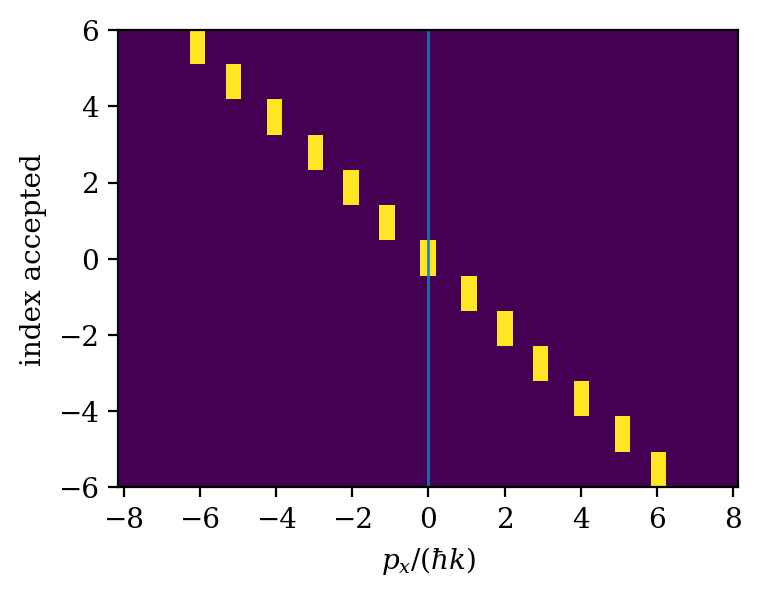

In [33]:
# plt.figure()
ax = plt.figure(figsize=(4,4)).gca()
plt.imshow(pzlinIndexSet,interpolation='none',aspect=1, extent=[-pxmax/(hb*k),pxmax/(hb*k),-6,+6])
# plt.axvline(x=(nx-1)/2, linewidth=1, alpha=0.1)
plt.axvline(x=0, linewidth=1, alpha=0.9)
plt.xlabel("$p_x/(\hbar k)$")
plt.ylabel("index accepted")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [40]:
phiDensityGrid_hbark = np.zeros(len(hbar_k_transfers))

In [43]:
phiX3 = np.trapz(np.trapz(np.trapz( (np.abs(phi_try1)**2) , pzlin,axis=3),pxlin,axis=2),pzlin,axis=1)
for (j, hbar_k) in enumerate(hbar_k_transfers):
    index = pzlinIndexSet[j]
    phiDensityGrid_hbark[j] = np.trapz(phiX3[index], pxlin[index])

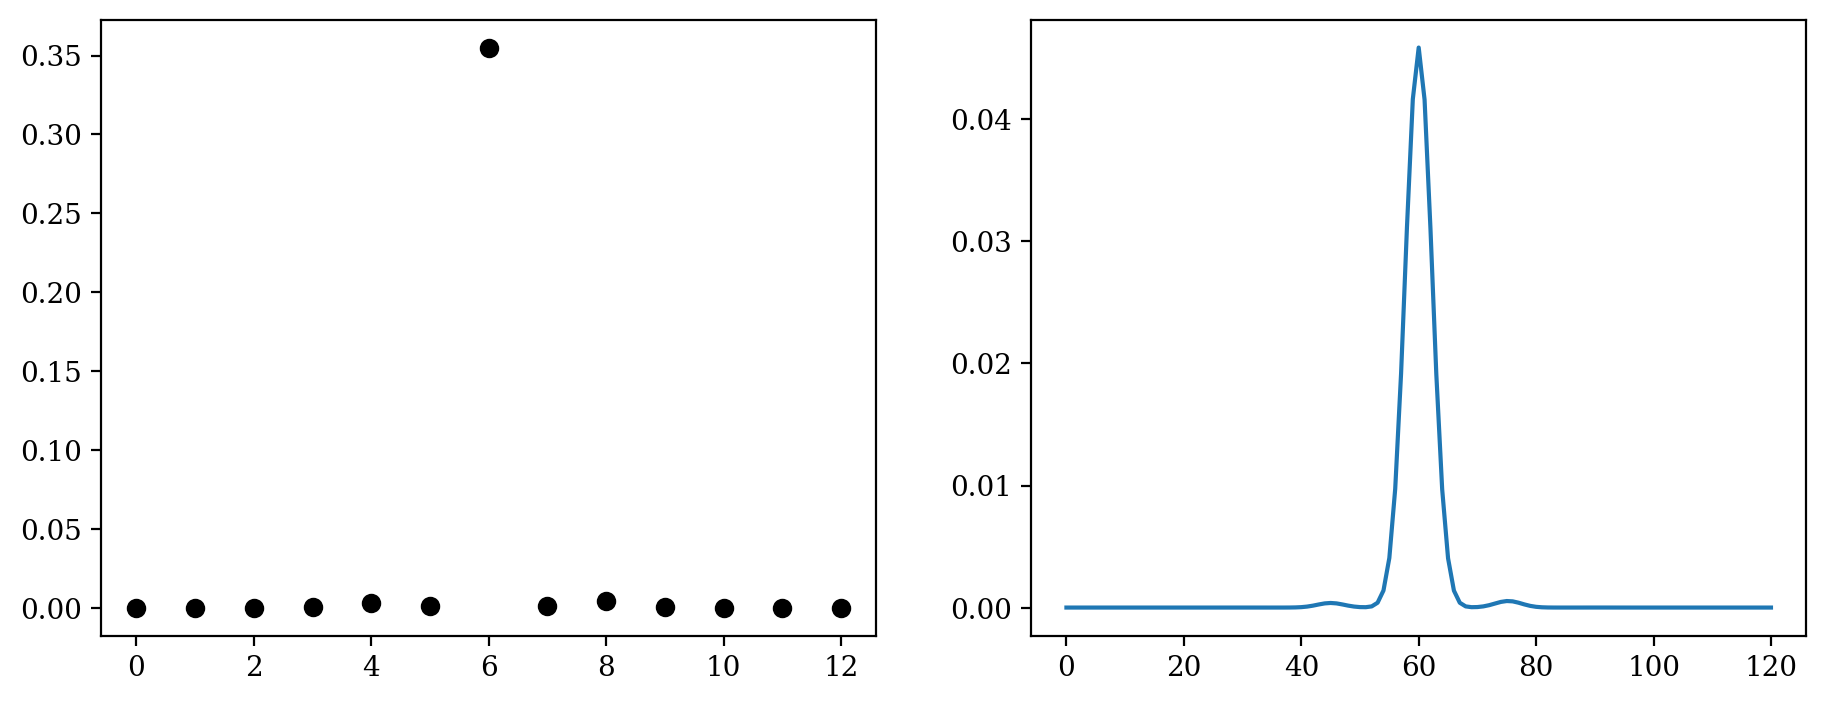

In [46]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(phiDensityGrid_hbark,'ko')
plt.subplot(1,2,2)
plt.plot(phiX3)

In [39]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
def scan_tauPi_init_gaussian(tPi, a3=0, a4=0, p3=0, p4=0, doppd=dopd, V0FArg=V0F, 
                             logging=False, progress_bar=False):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    px3 = p3*cos(a3)
    pz3 = p3*sin(a3)
    px4 = p4*cos(a4)
    pz4 = p4*sin(a4)
    
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=px3, pz3=pz3, px4=px4, pz4=pz4), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=V0FArg, phase=0, doppd=doppd, 
                print_every_t=0*dt, final_plot=False, progress_bar=progress_bar)
    

In [52]:
_ = scan_tauPi_init_gaussian(tauPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)

  0%|          | 0/39 [00:00<?, ?it/s]

In [53]:
tPiTest = np.append(np.arange(0.015,0,-dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)  

In [55]:
tPiTest[[1,2,3]]

array([0.014, 0.013, 0.012])

In [ ]:
tPiOutput = Parallel(n_jobs=N_JOBS)(
    delayed(lambda tPi: (tPi, scan_tauPi_init_gaussian(tPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)
           )(tPi) 
    for tPi in tqdm(tPiTest)
)     

In [ ]:
phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

for i in tqdm(range(len(tPiTest))):
    item = tPiOutput[i]
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
    phiDensityGrid[i] = phiX

    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])